In [1]:
import ROOT as rt
import array as arr
import math

Welcome to JupyROOT 6.24/02


In [2]:
# epsilon used to avoid bin edge nightmares (if you pick a value that lies on bin edge, it defaults to right bin)
EPSILON = 0.00001

In [3]:
DELTA_ETA_MAX = 1.4 - EPSILON

In [4]:
TRIG_PT_LOW = 4
TRIG_PT_HIGH = 8 - EPSILON
ASSOC_PT_LOW = 2
ASSOC_PT_HIGH = 4 - EPSILON

In [5]:
LSB_MIN = 1.085
LSB_MAX = 1.10 - EPSILON
SIG_MIN = 1.108 
SIG_MAX = 1.124 - EPSILON
RSB_MIN = 1.14
RSB_MAX = 1.155 - EPSILON

In [6]:
c = rt.TCanvas("main_canvas", "Main Canvas", 0, 10, 1920, 1080)

In [7]:
# a function to calculate parabola that passes through all three input points
def get_parabola(point_one, point_two, point_three):
    x1, x2, x3 = point_one[0], point_two[0], point_three[0]
    y1, y2, y3 = point_one[1], point_two[1], point_three[1]
    
    denom = (x1 - x2)*(x1 - x3)*(x2 - x3)
    
    A = (x3 * (y2 - y1) + x2 * (y1 - y3) + x1 * (y3 - y2)) / denom
    B = (x3**2 * (y1 - y2) + x2**2 * (y3 - y1) + x1**2 * (y2 - y3)) / denom
    C = (x2 * x3 * (x2 - x3) * y1 + x3 * x1 * (x3 - x1) * y2 + x1 * x2 * (x1 - x2) * y3) / denom
    
    return C, B, A
    

In [8]:
def make_mixed_corrections(same, mixed, mass_low=1.11, mass_high=1.12, is_hh=False):
    if is_hh:
        same3d = same
        same3d.Sumw2()
        mixed3d = mixed
        mixed3d.Sumw2()
    else:
        same.GetAxis(2).SetRangeUser(mass_low, mass_high)
        mixed.GetAxis(2).SetRangeUser(mass_low, mass_high)
        same3d = same.Projection(0, 1, 3)
        same3d.Sumw2()
        mixed3d = mixed.Projection(0, 1, 3)
        mixed3d.Sumw2()
        
    for zbin in range(10):
        same3d.GetZaxis().SetRange(zbin+1, zbin+1)
        same2d = same3d.Project3D("xye")
        same2d.SetName(f"same2dproj_zbin_{zbin}")

        mixed3d.GetZaxis().SetRange(zbin+1, zbin+1)
        mixed2d = mixed3d.Project3D("xye")
        mixed2d.SetName(f"mix2dproj_zbin_{zbin}")

        #scaling by average of bins adjacent to 0
        scale = 0.5*(mixed2d.Integral(mixed2d.GetXaxis().FindBin(-0.01),    #xmin
                                      mixed2d.GetXaxis().FindBin(0.01),     #xmax 
                                      mixed2d.GetYaxis().FindBin(0.0),      #ymin
                                      mixed2d.GetYaxis().FindBin(0.0)))     #ymax
        same2d.Divide(mixed2d)
        same2d.Scale(scale)
        
        if zbin == 0:
            same2d_total = same2d.Clone("2dproj_total")
        else:
            same2d_total.Add(same2d)

    return same2d_total
    

# 0-20 setup

In [9]:
input_file_0_20 = rt.TFile("../online/output/cent_0_20.root")
input_list_0_20 = input_file_0_20.Get("h-lambda")
input_file_0_20.Close()

In [11]:
trig_dist_0_20 = input_list_0_20.FindObject("fTriggerDist")
lambda_dist_0_20 = input_list_0_20.FindObject("fTriggeredLambdaDist")

In [12]:
h_h_0_20 = input_list_0_20.FindObject("fDphiHHEff")
h_h_0_20_noeff = input_list_0_20.FindObject("fDphiHH")
h_h_mixed_0_20 = input_list_0_20.FindObject("fDphiHHMixed")

In [13]:
h_lambda_0_20 = input_list_0_20.FindObject("fDphiHLambdaEff")
h_lambda_ls_0_20 = input_list_0_20.FindObject("fDphiHLambdaLS")
h_lambda_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_0_20 = input_list_0_20.FindObject("fDphiHLambdaLSMixed")

In [14]:
# Setting the trigger Pt (this is never changed again)
trig_dist_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_0_20_noeff.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_0_20.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [15]:
# Setting the associated Pt (this is never changed again)
lambda_dist_0_20.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_0_20_noeff.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_0_20.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [17]:
trig_pt_dist_0_20 = trig_dist_0_20.Projection(0).Clone("trig_pt_dist_0_20")
trig_phi_dist_0_20 = trig_dist_0_20.Projection(1).Clone("trig_phi_dist_0_20")
trig_eta_dist_0_20 = trig_dist_0_20.Projection(2).Clone("trig_eta_dist_0_20")
trig_2d_dist_0_20 = trig_dist_0_20.Projection(0, 3).Clone("trig_2d_dist_0_20")

trig_pt_dist_0_20.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_0_20.Sumw2()
trig_pt_dist_0_20.SetLineColor(rt.kRed)

trig_phi_dist_0_20.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_0_20.Sumw2()
trig_phi_dist_0_20.SetLineColor(rt.kRed)

trig_eta_dist_0_20.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_0_20.Sumw2()
trig_eta_dist_0_20.SetLineColor(rt.kRed)

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


In [1]:
# TODO: REMOVE THE SCALING ONCE EFFICIENCY CORRECTED DISTRIBUTION IS IMPLEMENTED
num_trigs_0_20 = trig_2d_dist_0_20.Integral()*(1/0.83)

NameError: name 'trig_2d_dist_0_20' is not defined

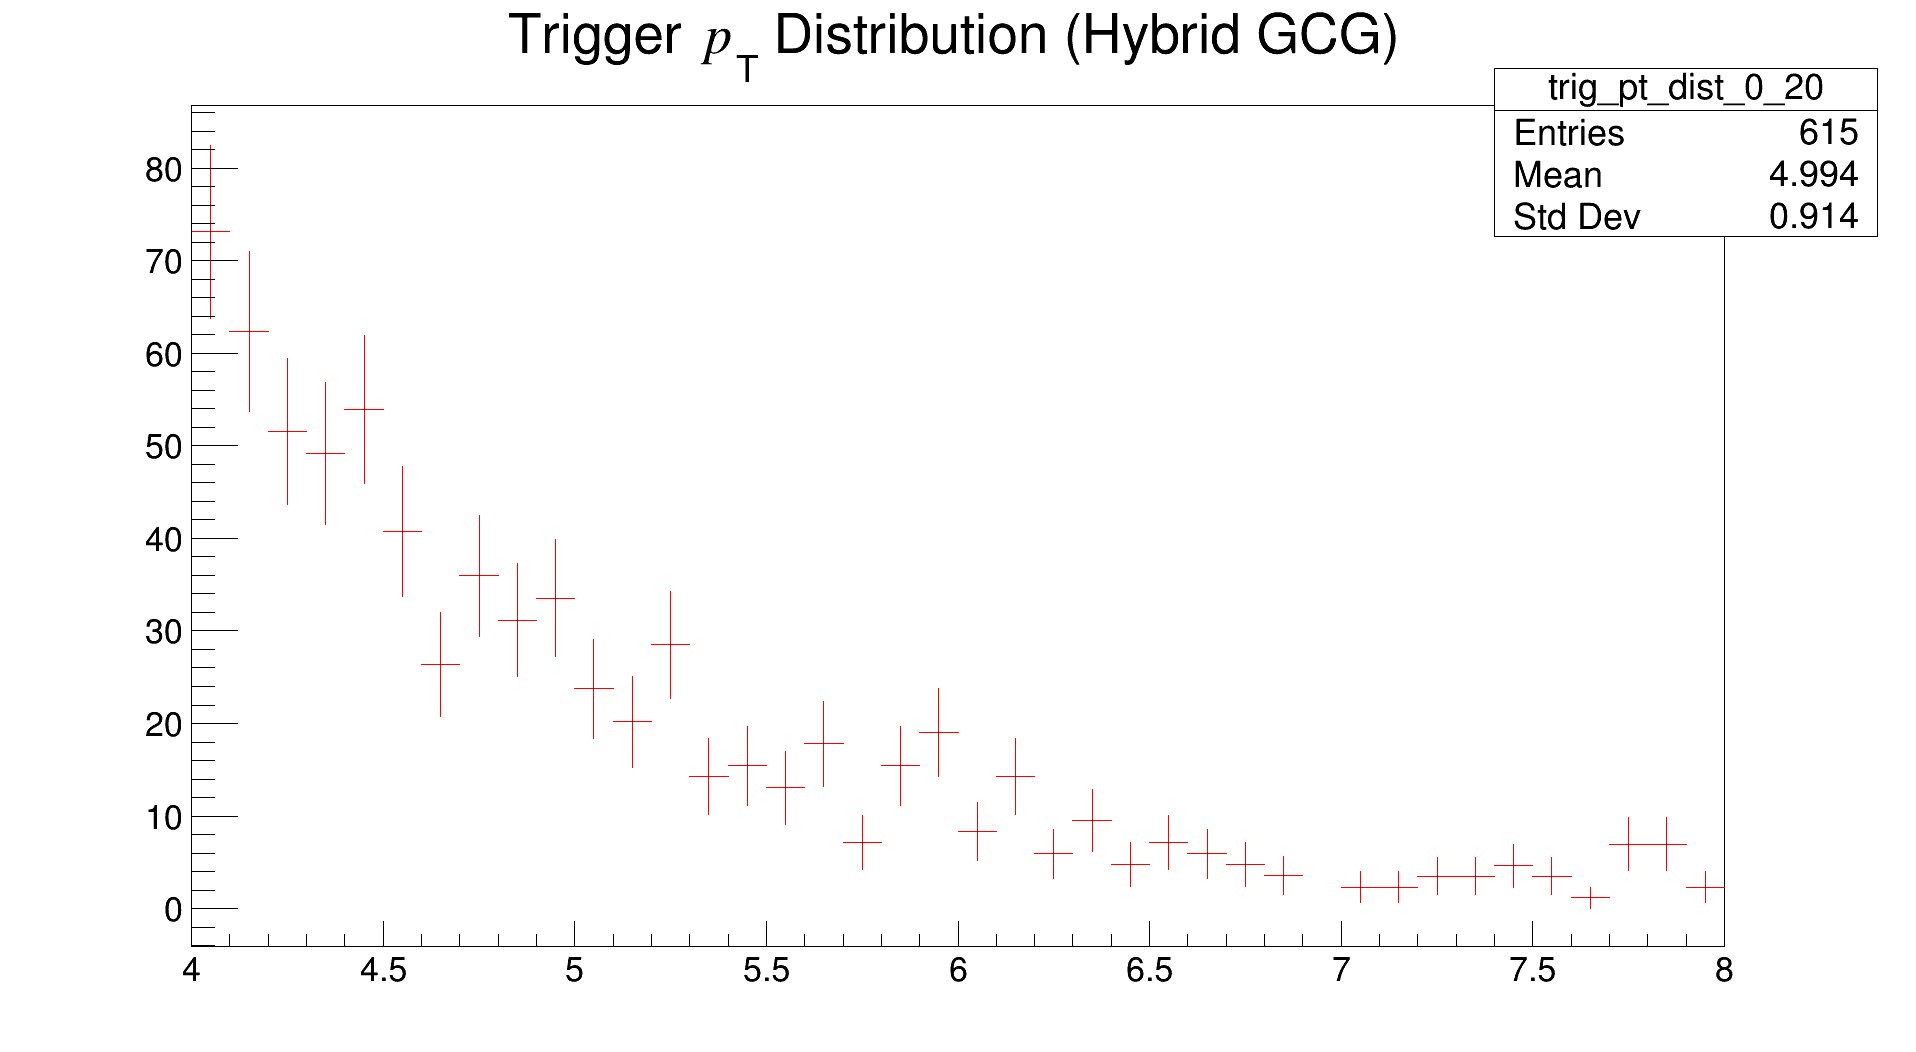

In [19]:
trig_pt_dist_0_20.Draw()
c.Draw()

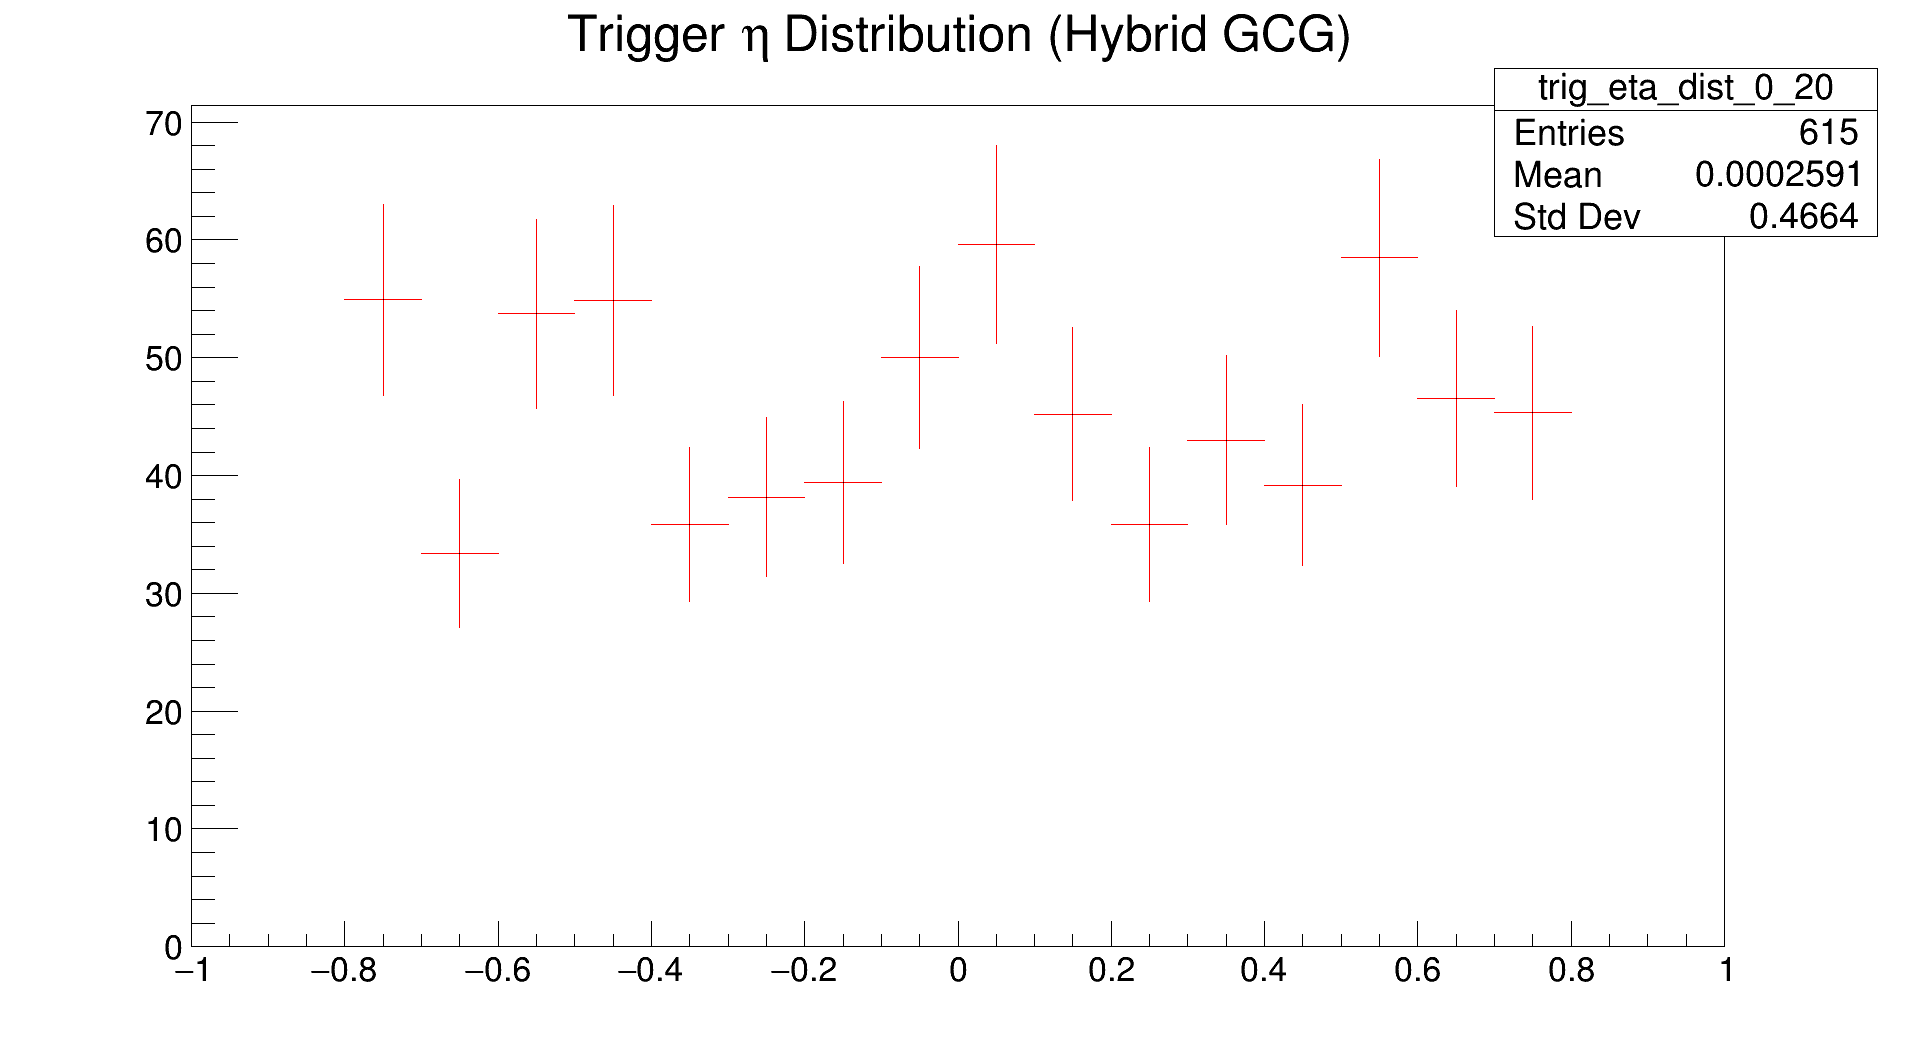

In [20]:
trig_eta_dist_0_20.Draw()
c.Draw()

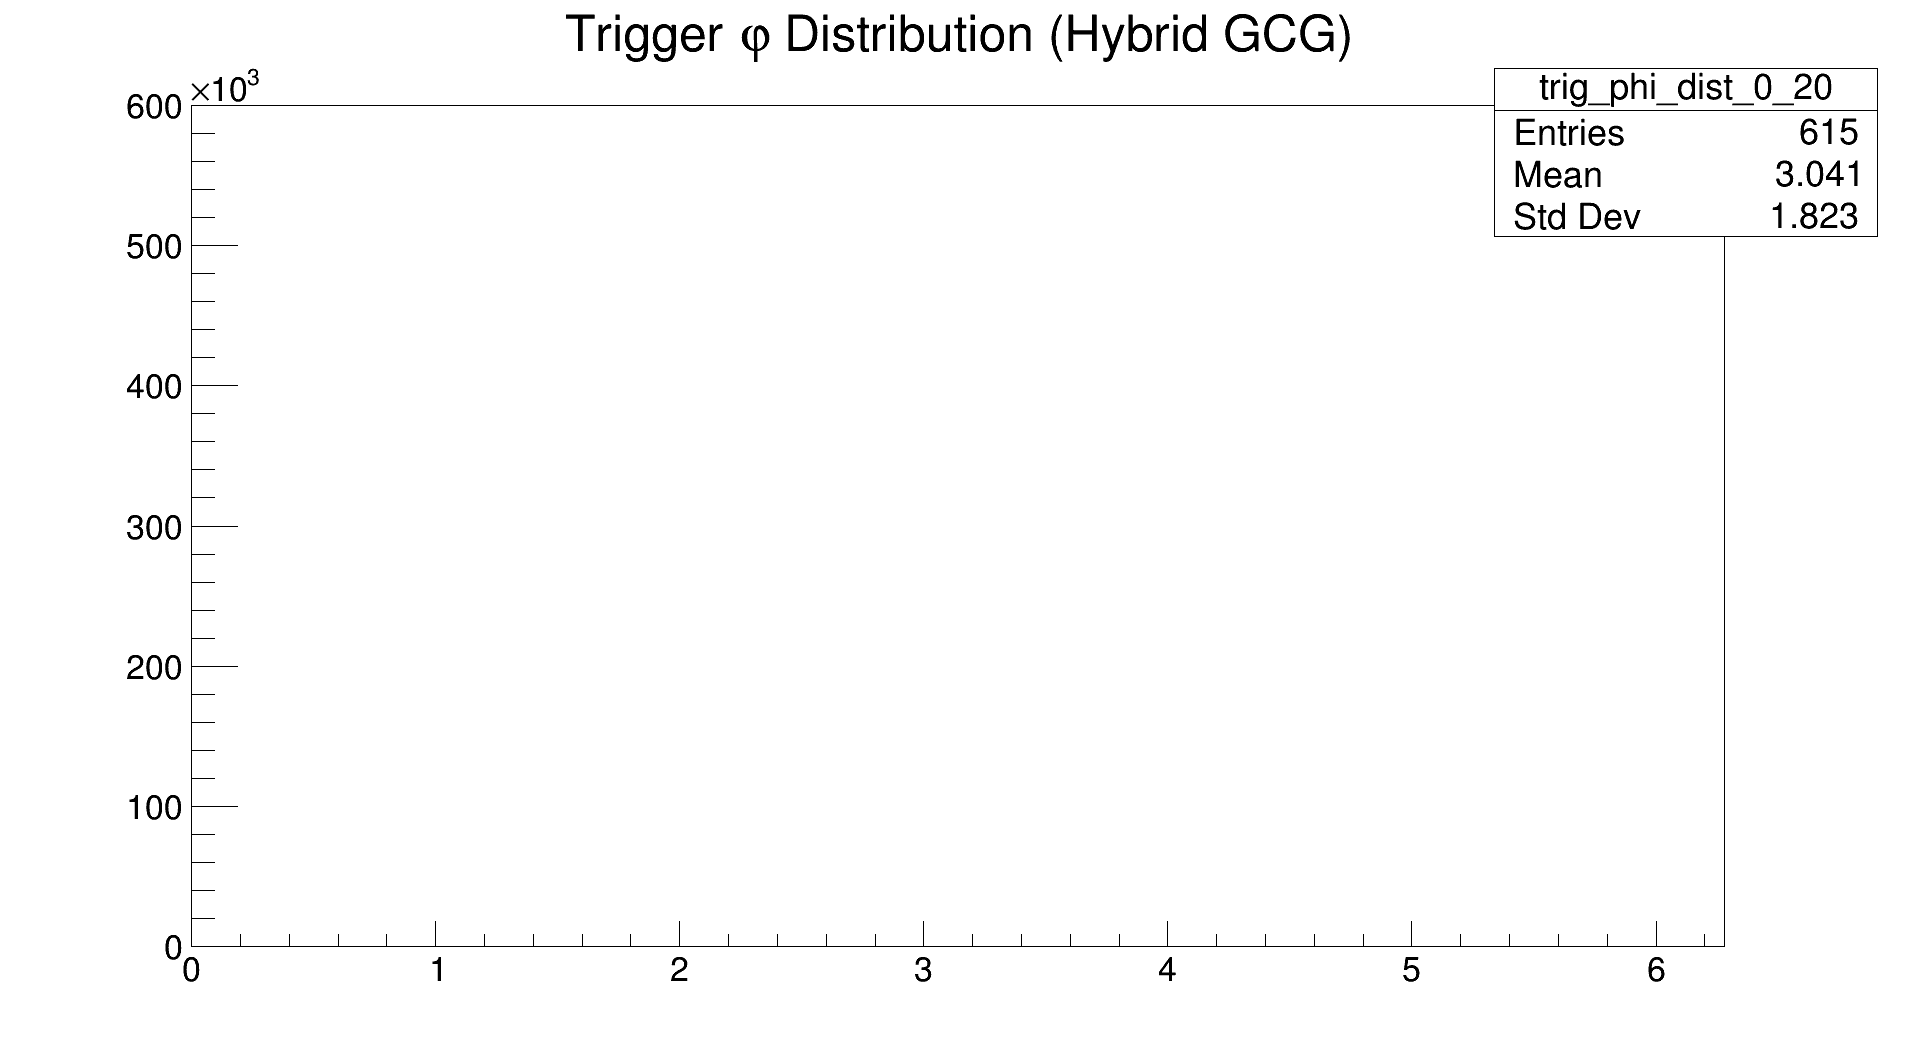

In [21]:
trig_phi_dist_0_20.Draw()
c.Draw()

### Signal analysis section

In [22]:
# eta cuts first
lambda_dist_0_20.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_0_20 = lambda_dist_0_20.Projection(3).Clone("lambda_mass_dist_0_20")

In [23]:
lambda_mass_dist_0_20.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_0_20.Sumw2()
lambda_mass_dist_0_20.SetLineWidth(2)
lambda_mass_dist_0_20.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_0_20.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

Warning in <TH1D::Sumw2>: Sum of squares of weights structure already created


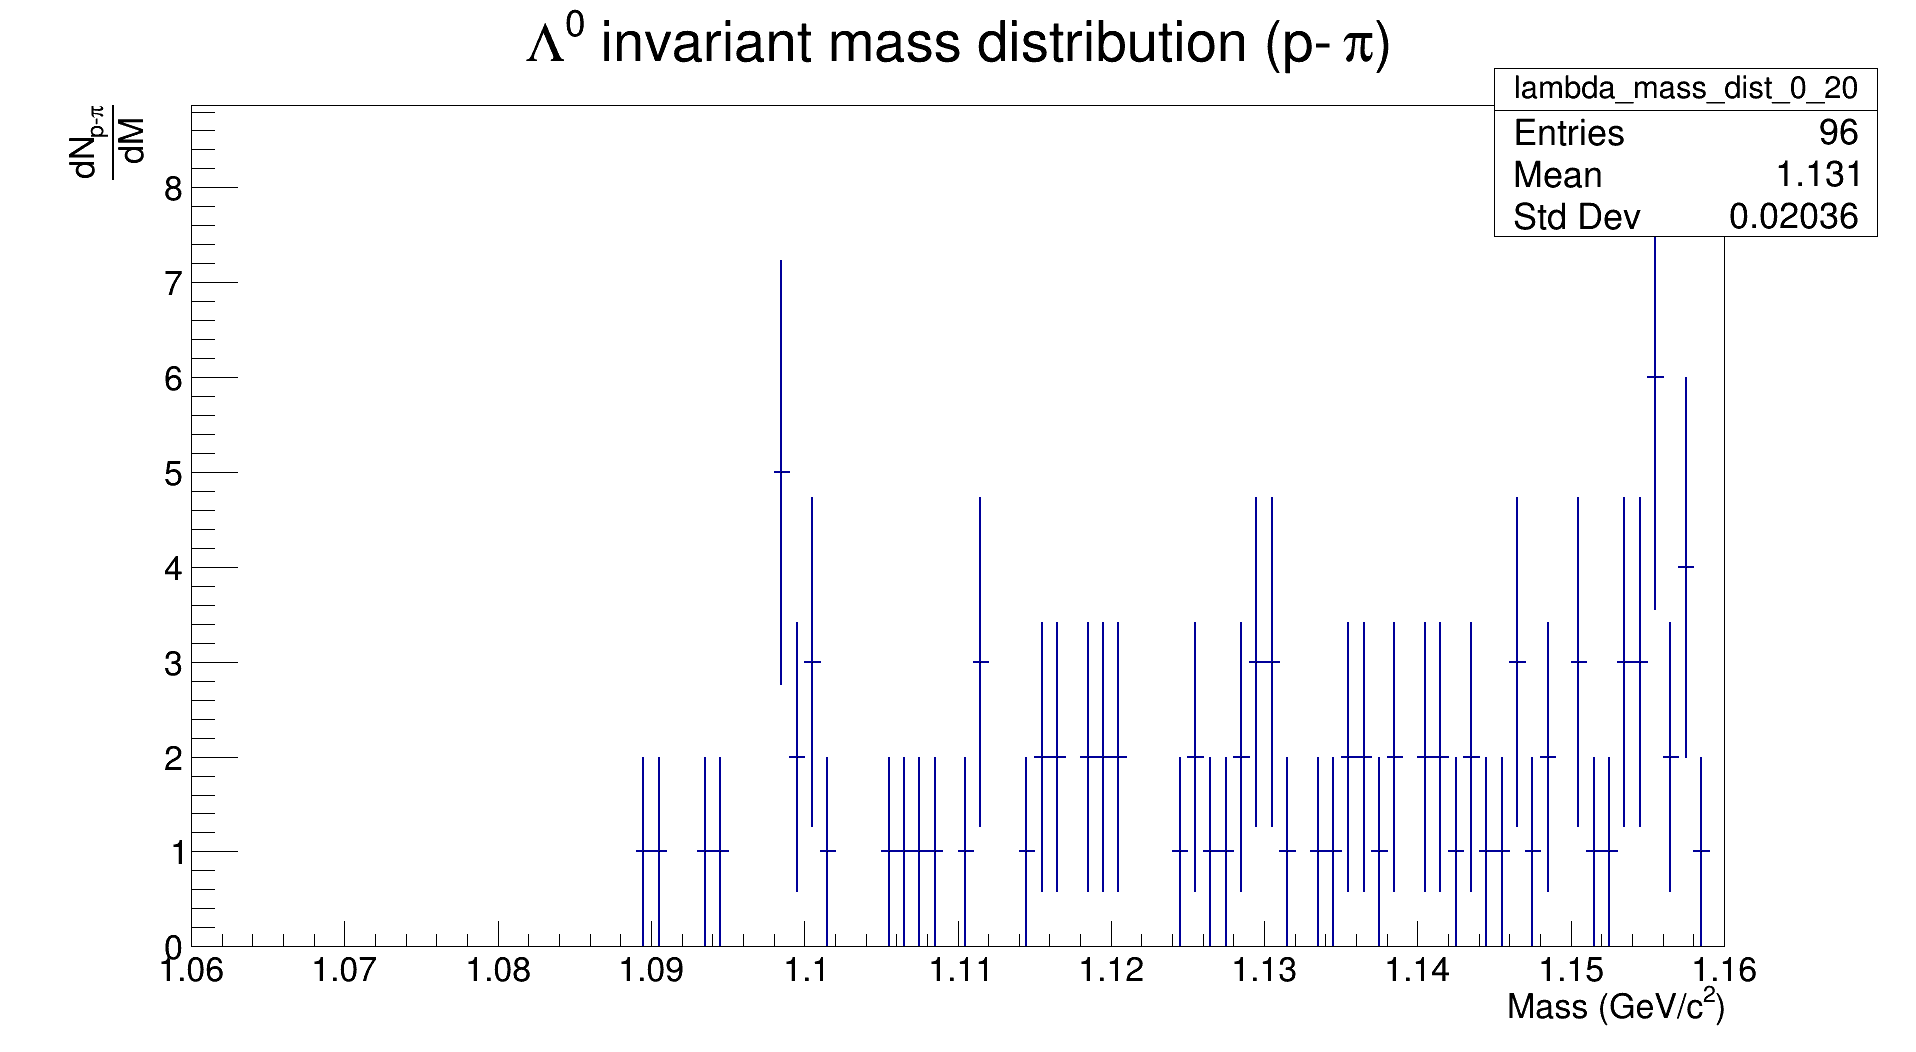

In [24]:
lambda_mass_dist_0_20.Draw()
c.Draw()

In [25]:
bin_1 = lambda_mass_dist_0_20.FindBin(1.09)
bin_2 = lambda_mass_dist_0_20.FindBin(1.15)
bin_3 = lambda_mass_dist_0_20.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_0_20.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_0_20.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_0_20.GetBinContent(bin_3)]
bg_starting_params_0_20 = get_parabola(point_one, point_two, point_three)

In [26]:
lambda_mass_fit_0_20 = rt.TF1("lambda_mass_fit_0_20", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_0_20.SetNpx(1000)
lambda_mass_fit_0_20.SetParameter(0, 1.36753e01)
lambda_mass_fit_0_20.FixParameter(1, 1.11581)
lambda_mass_fit_0_20.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_0_20.SetParameter(3, 6.04166e-03)
lambda_mass_fit_0_20.SetParameter(4, bg_starting_params_0_20[0])
lambda_mass_fit_0_20.SetParameter(5, bg_starting_params_0_20[1])
lambda_mass_fit_0_20.SetParameter(6, bg_starting_params_0_20[2])

 FCN=16.551 FROM MIGRAD    STATUS=FAILED        435 CALLS         436 TOTAL
                     EDM=457099    STRATEGY= 1  ERROR MATRIX UNCERTAINTY  50.0 per cent
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           1.36753e+01   5.80194e+00  -0.00000e+00   0.00000e+00
   2  p1           1.11581e+00     fixed    
   3  p2          -2.86303e-05   3.32731e-09  -0.00000e+00   7.26067e+10
   4  p3           6.04166e-03   1.41421e+00  -0.00000e+00   0.00000e+00
   5  p4           3.11610e+02   7.01817e+02  -0.00000e+00  -3.32455e+00
   6  p5          -5.49665e+02   1.55598e+01  -0.00000e+00  -3.91889e+00
   7  p6           2.43389e+02   5.19515e+02   0.00000e+00  -4.60854e+00


Warning in <Fit>: Abnormal termination of minimization.


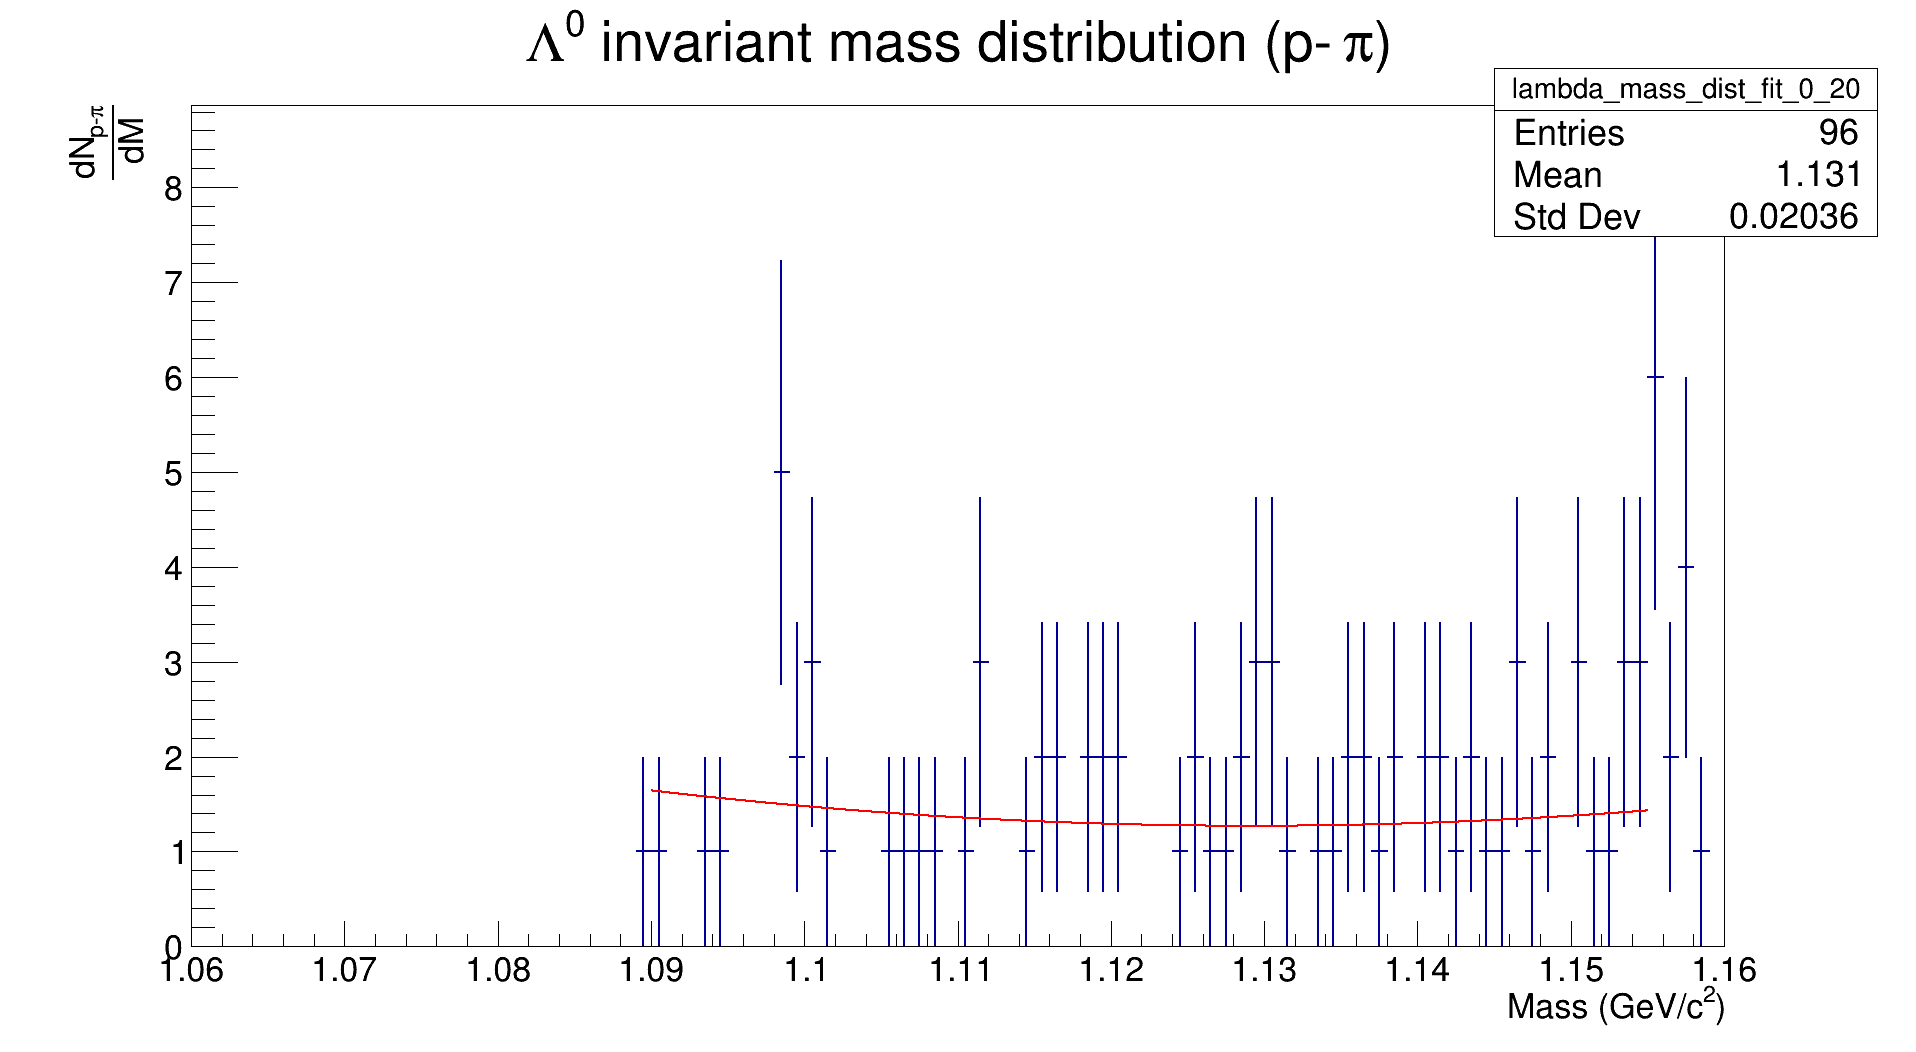

In [27]:
lambda_mass_dist_fit_0_20 = lambda_mass_dist_0_20.Clone("lambda_mass_dist_fit_0_20")
lambda_mass_dist_fit_0_20.Fit(lambda_mass_fit_0_20, "RS")
lambda_mass_dist_fit_0_20.Draw()
c.Draw()

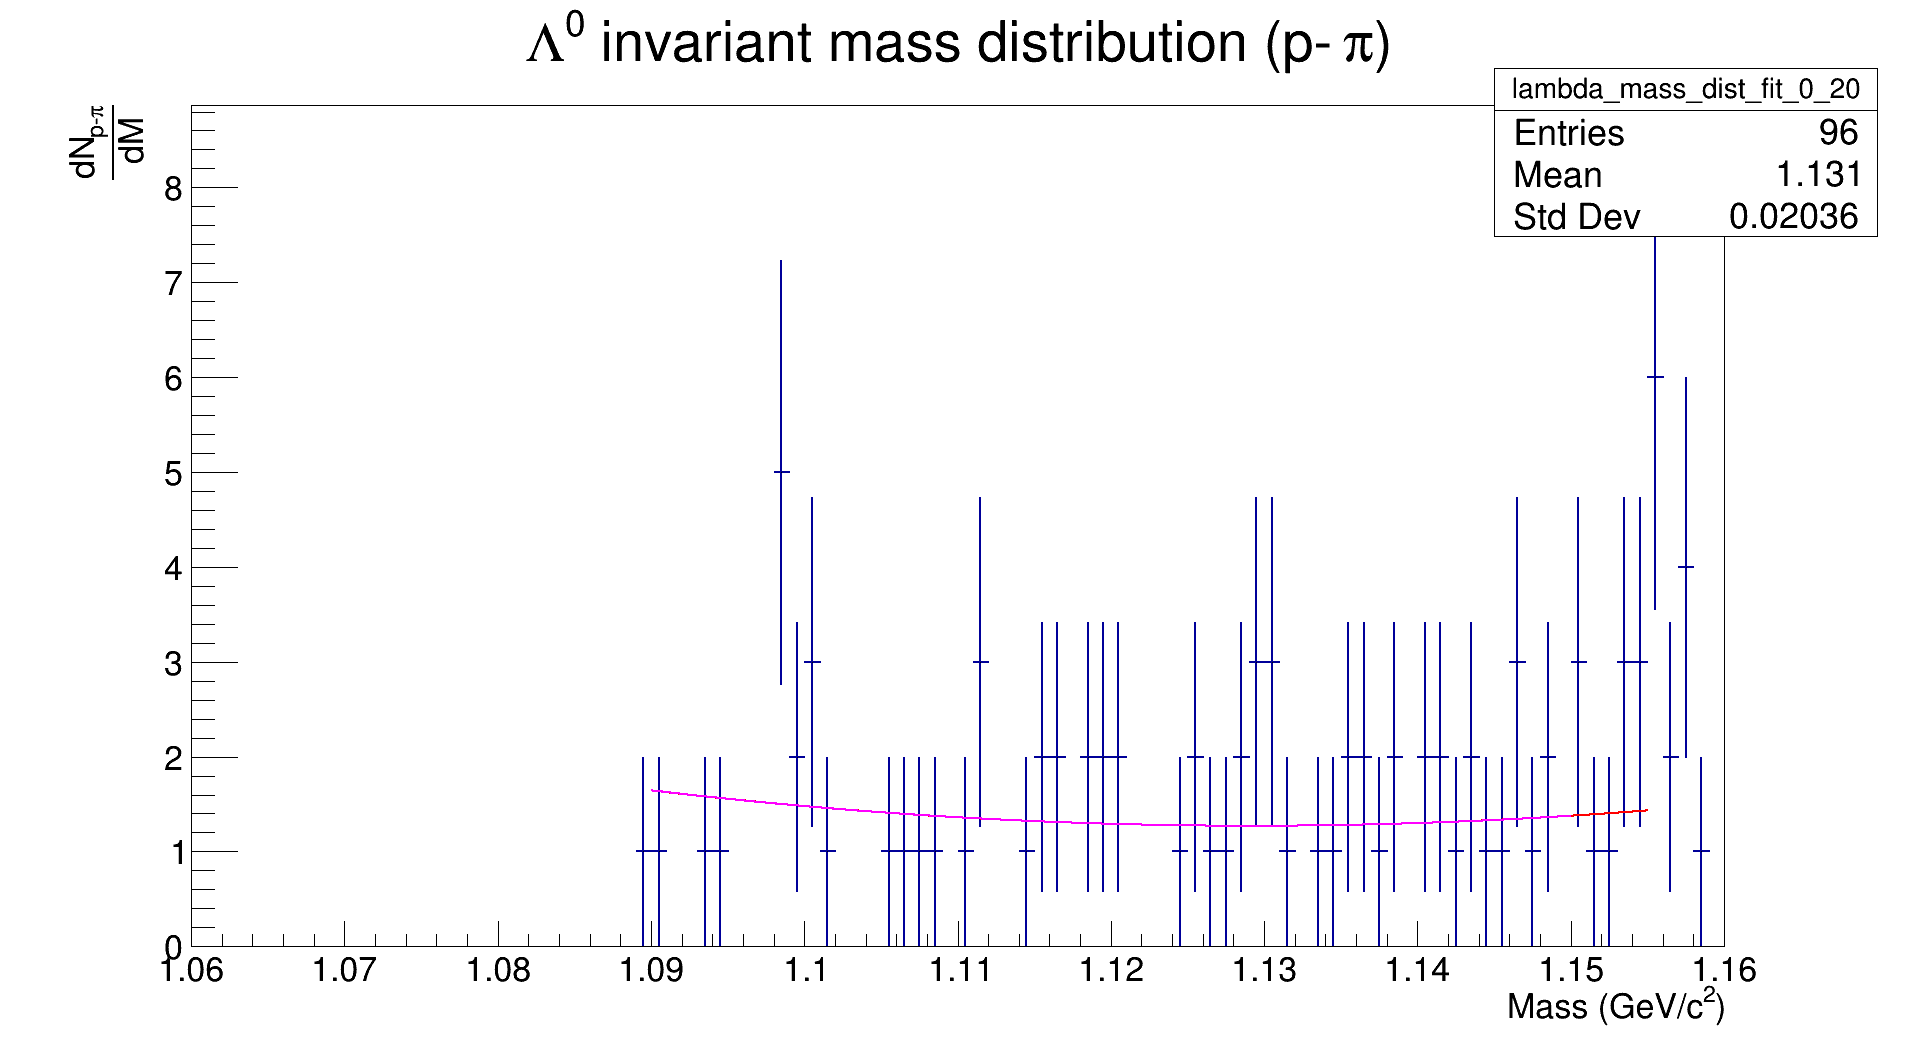

In [28]:
bg_fit_0_20 = rt.TF1("bg_fit_0_20", "pol2", 1.09, 1.15)
bg_fit_0_20.SetParameter(0, lambda_mass_fit_0_20.GetParameter(4))
bg_fit_0_20.SetParameter(1, lambda_mass_fit_0_20.GetParameter(5))
bg_fit_0_20.SetParameter(2, lambda_mass_fit_0_20.GetParameter(6))
bg_fit_0_20.SetNpx(1000)
bg_fit_0_20.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_0_20.Draw()
bg_fit_0_20.Draw("SAME")
c.Draw()

In [29]:
left_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MIN)
right_signal_bin_0_20 = lambda_mass_dist_fit_0_20.FindBin(SIG_MAX)

lambda_bg_0_20 = 0
lambda_total_0_20 = 0
for bin_num in range(left_signal_bin_0_20, right_signal_bin_0_20 + 1):
    bin_center = lambda_mass_dist_fit_0_20.GetBinCenter(bin_num)
    lambda_bg_0_20 += bg_fit_0_20.Eval(bin_center)
    lambda_total_0_20 += lambda_mass_dist_fit_0_20.GetBinContent(bin_num)

lambda_signal_0_20 = lambda_total_0_20 - lambda_bg_0_20
lambda_signal_total_ratio_0_20 = lambda_signal_0_20/lambda_total_0_20
lambda_signal_bg_ratio_0_20 = lambda_signal_0_20/lambda_bg_0_20
print(f"The 0-20 lambda signal is: {lambda_signal_0_20}")
print(f"The 0-20 lambda background is: {lambda_bg_0_20}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_0_20}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_0_20}")
print(f"The 0-20 lambda significance is: {lambda_signal_0_20/math.sqrt(lambda_signal_0_20 + lambda_bg_0_20)}")

The 0-20 lambda signal is: -5.10023787076949
The 0-20 lambda background is: 21.10023787076949
The 0-20 lambda S/B is: -0.24171470966376804
The 0-20 lambda S/T is: -0.31876486692309314
The 0-20 lambda significance is: -1.2750594676923726


### Mixed event correction section

In [30]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_0_20 = h_lambda_0_20.Projection(4, axes)
h_lambda_ls_0_20 = h_lambda_ls_0_20.Projection(4, axes)
h_lambda_mixed_0_20 = h_lambda_mixed_0_20.Projection(4, axes)
h_lambda_ls_mixed_0_20 = h_lambda_ls_mixed_0_20.Projection(4, axes)

In [31]:
h_h_0_20 = h_h_0_20.Projection(2, 3, 4)
h_h_mixed_0_20 = h_h_mixed_0_20.Projection(2, 3, 4)
h_h_0_20.Sumw2()
h_h_mixed_0_20.Sumw2()

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [32]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_0_20 = h_lambda_0_20.Projection(0, 1).Clone("h_lambda_2d_nomixcor_0_20")
h_lambda_ls_2d_nomixcor_0_20 = h_lambda_ls_0_20.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_0_20")
h_lambda_mixed_2d_0_20 = h_lambda_mixed_0_20.Projection(0, 1).Clone("h_lambda_mixed_2d_0_20")

In [33]:
h_h_2d_nomixcor_0_20 = h_h_0_20.Project3D("xye").Clone("h_h_2d_nomixcor_0_20")
h_h_mixed_2d_0_20 = h_h_mixed_0_20.Project3D("xye").Clone("h_h_mixed_2d_0_20")

In [34]:
h_lambda_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_0_20.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

In [35]:
h_h_2d_nomixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_0_20.GetYaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_0_20.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_0_20.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_0_20.GetYaxis().SetTitleOffset(1.3)

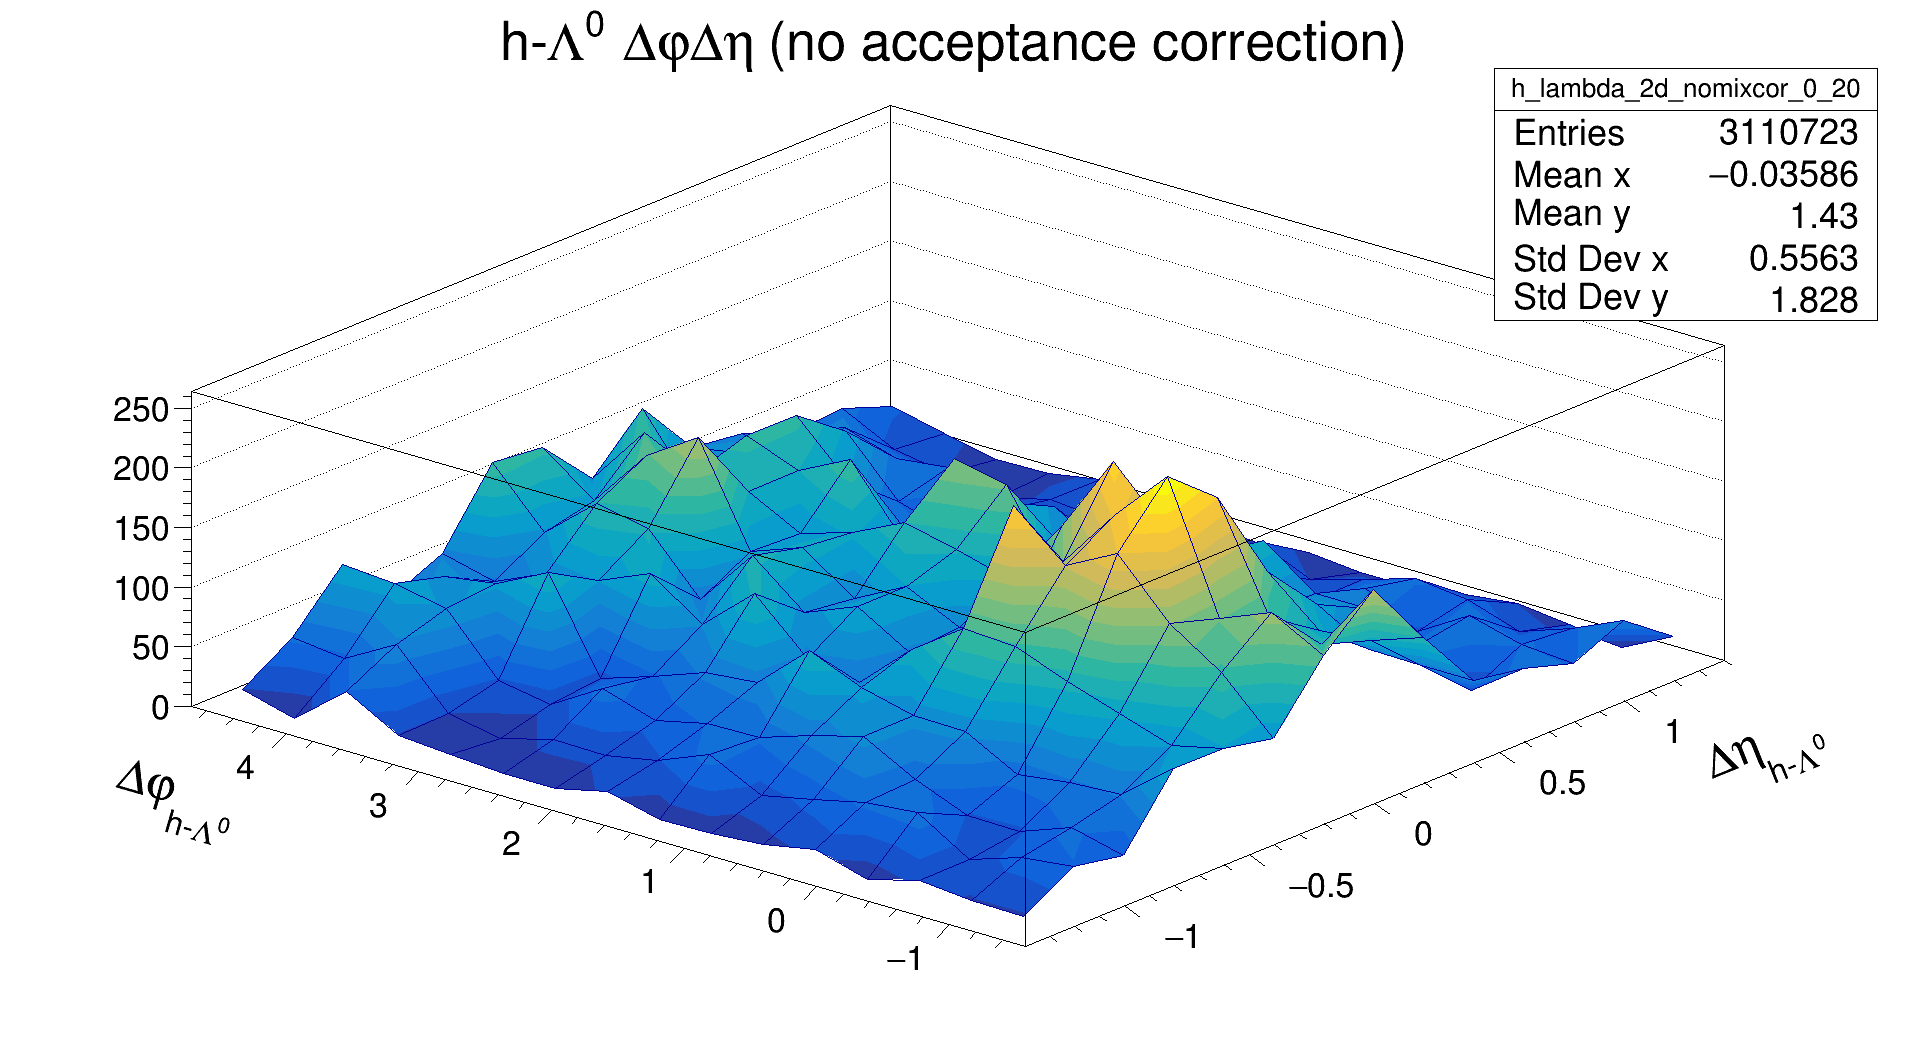

In [36]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

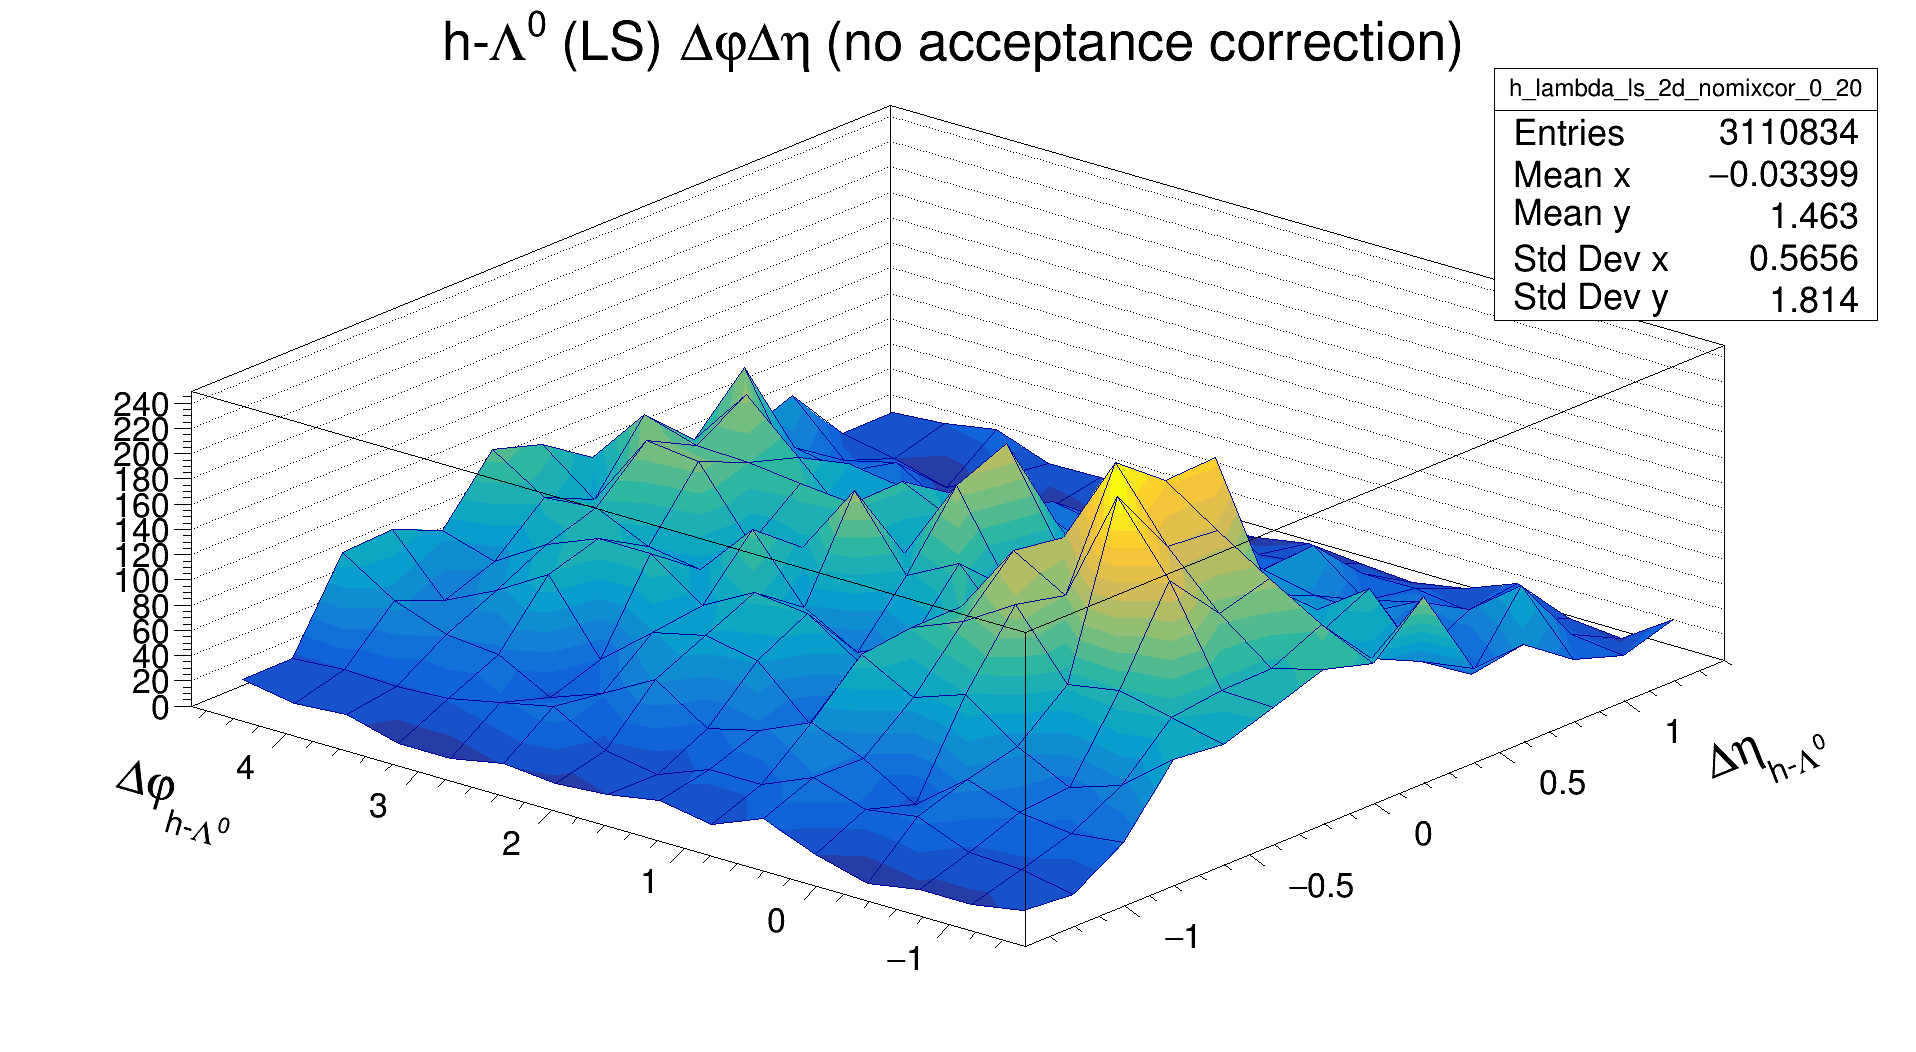

In [37]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_ls_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_ls_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

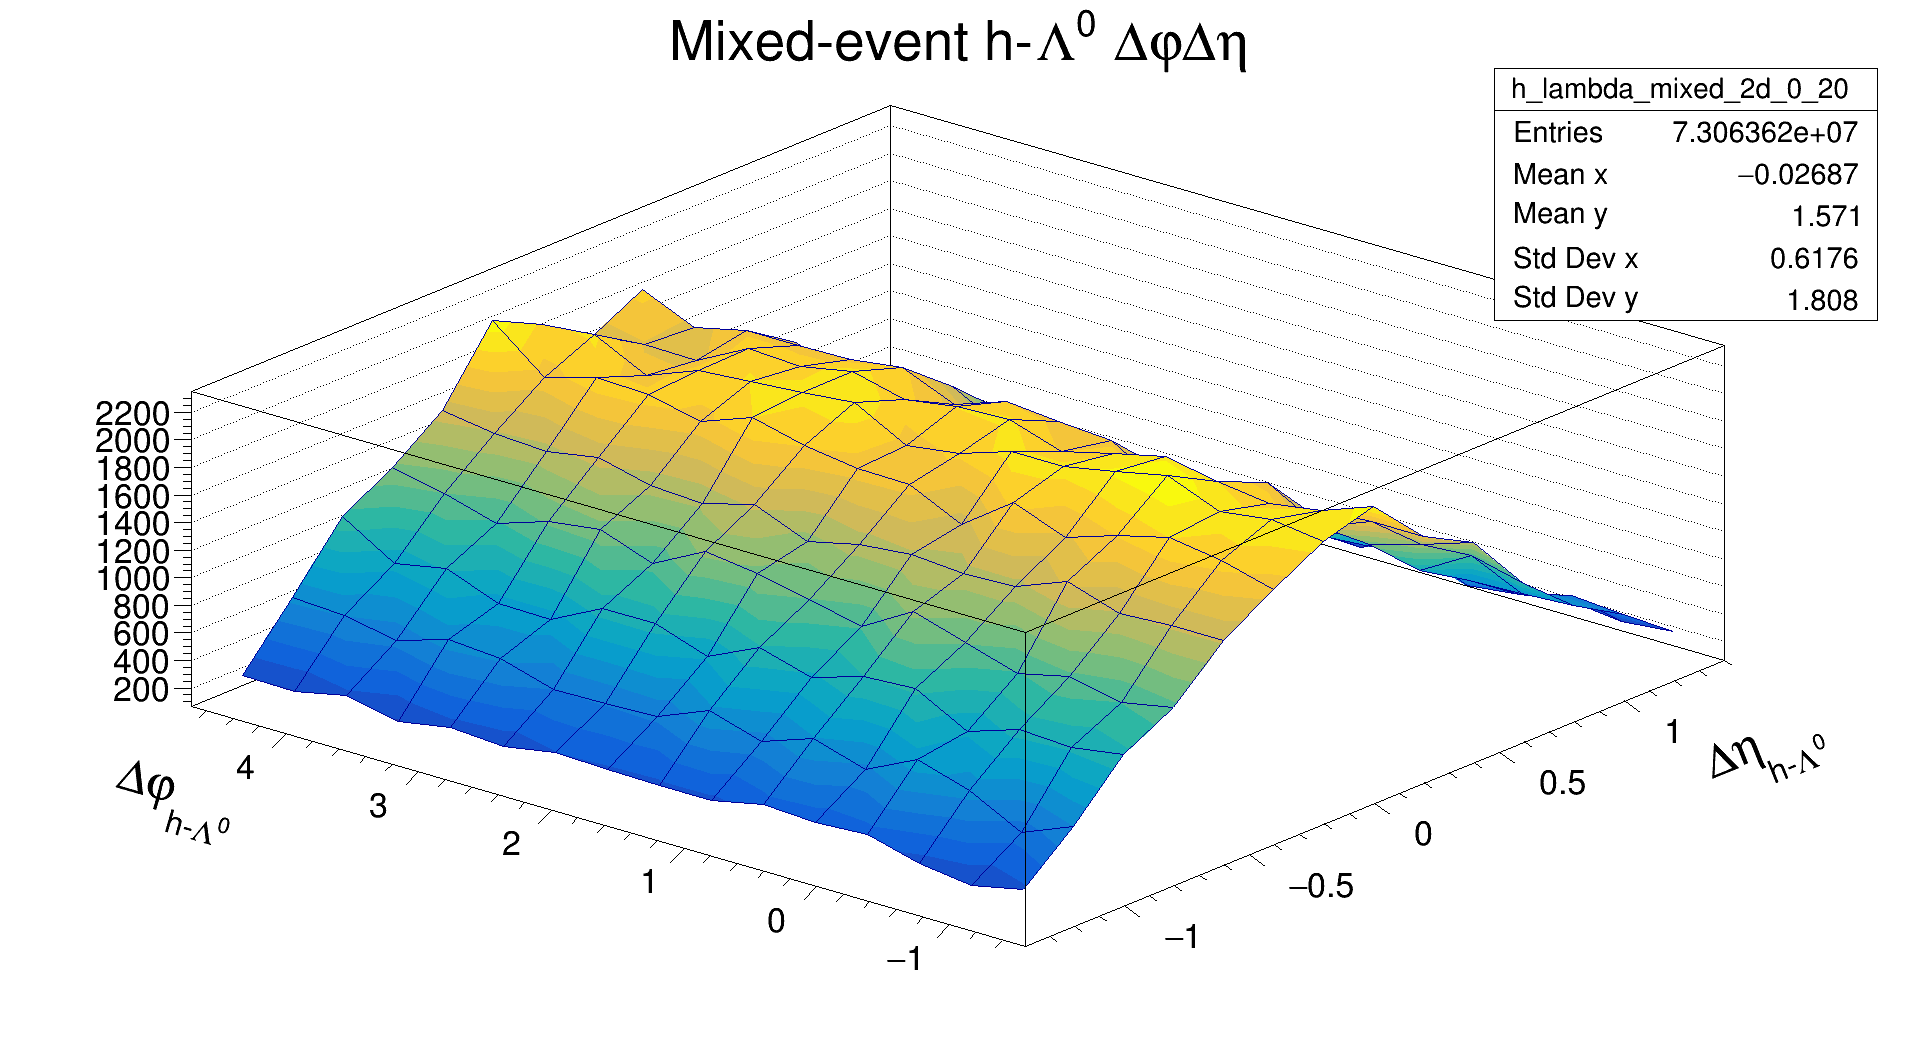

In [38]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_0_20.Draw("SURF1")
c.Draw()

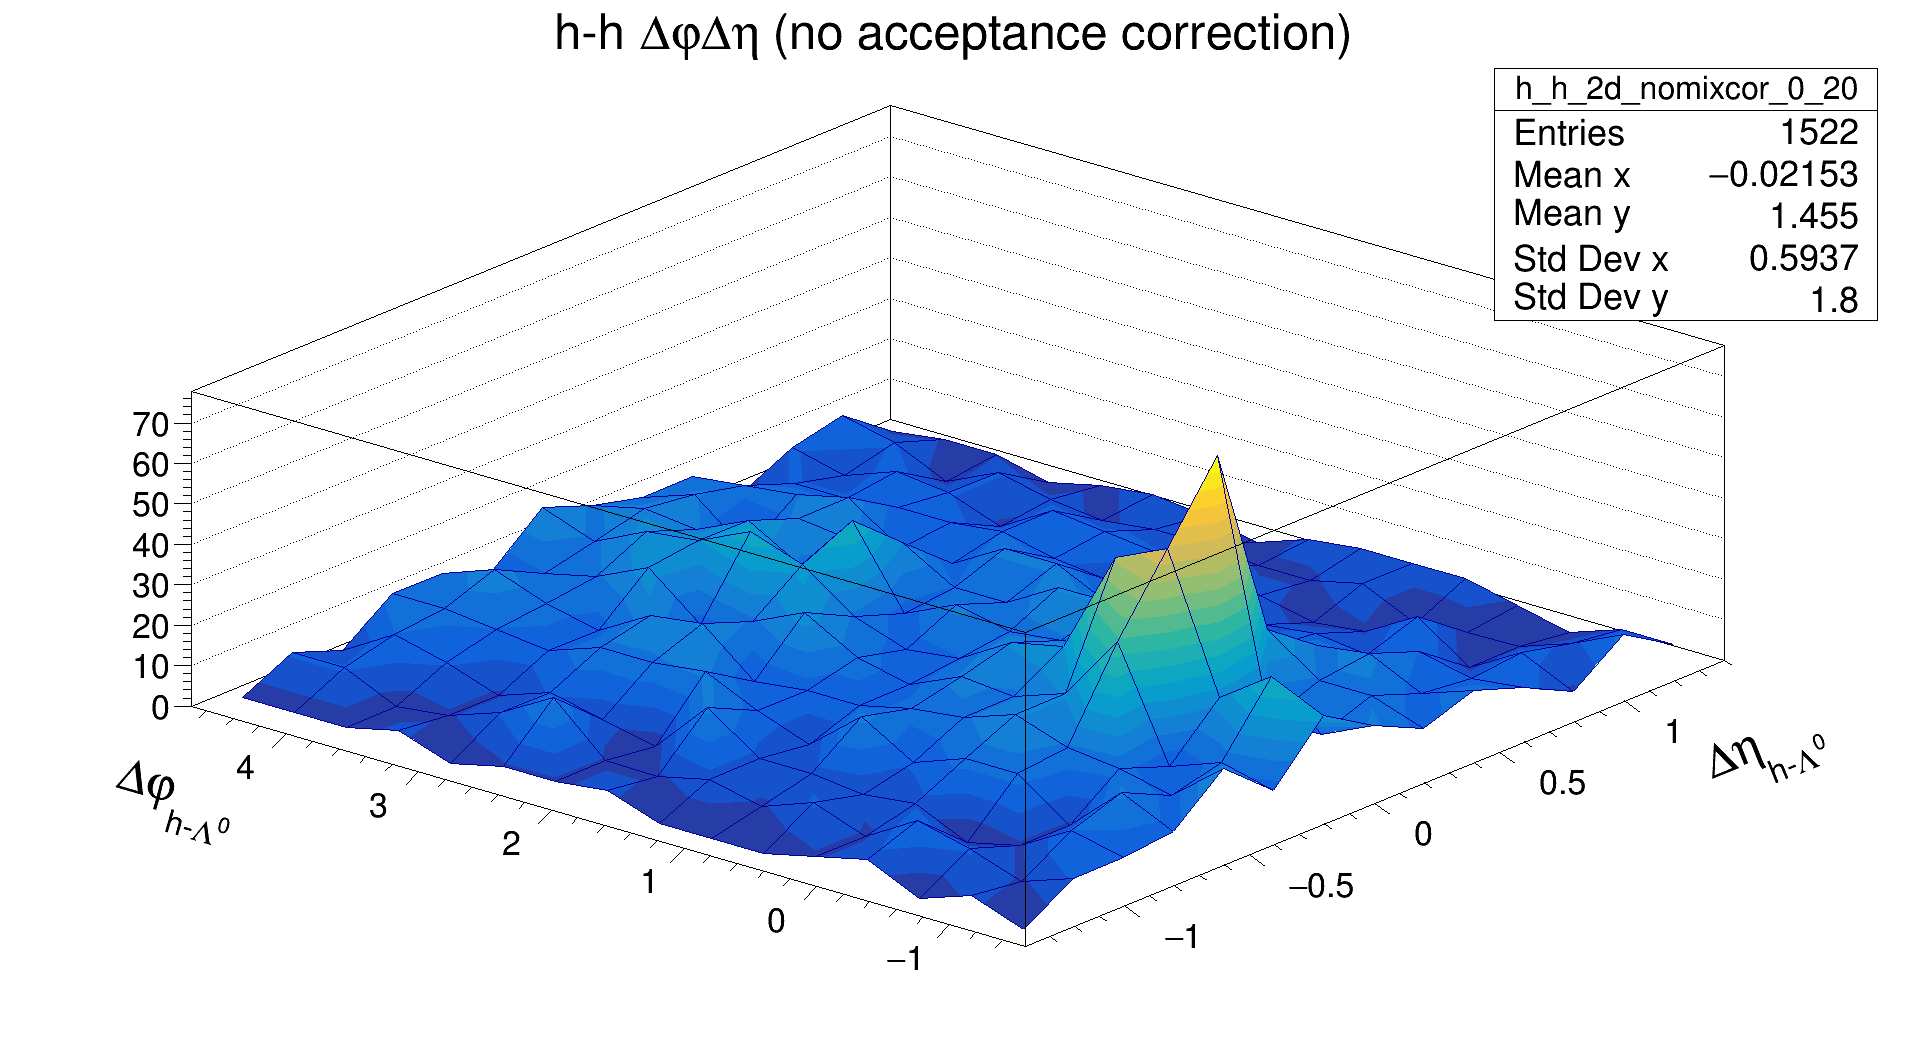

In [39]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_0_20.Draw("SURF1")
c.Draw()

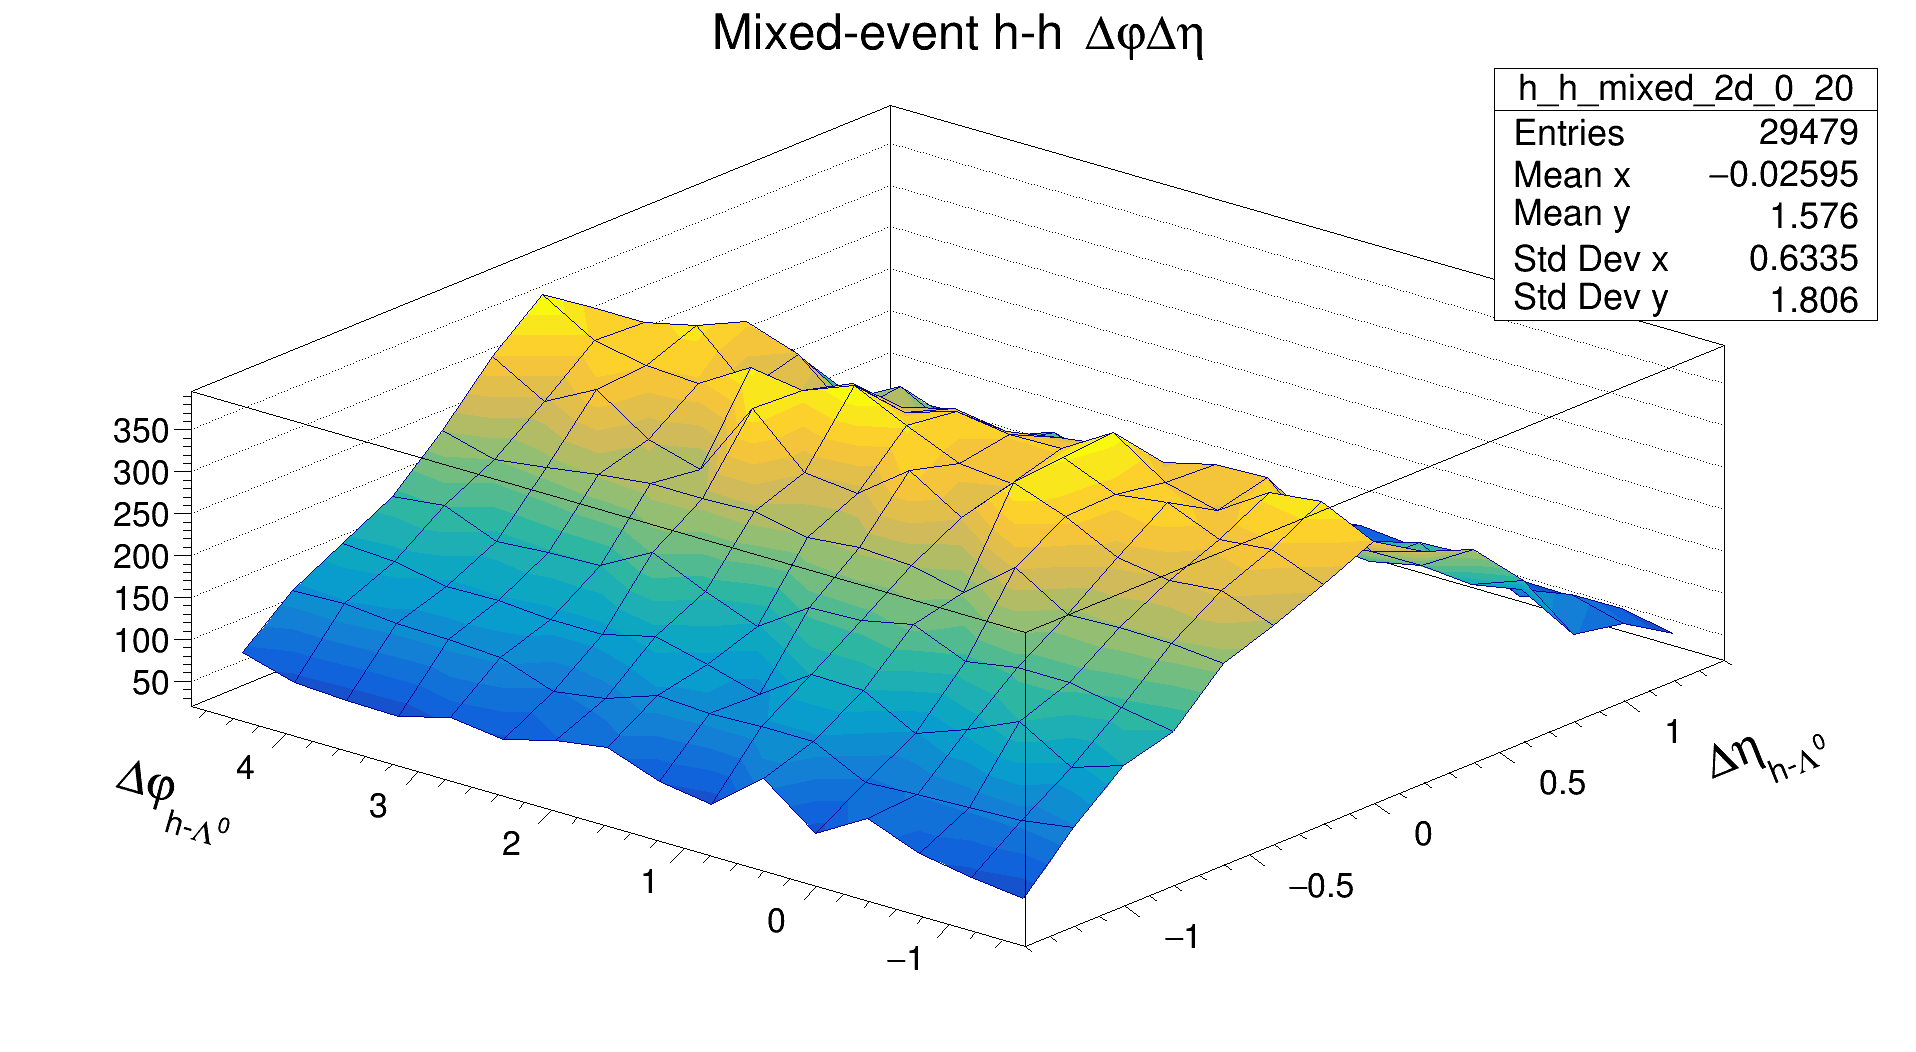

In [40]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_0_20.Draw("SURF1")
c.Draw()

In [41]:
h_lambda_2d_mixcor_lsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_0_20 = make_mixed_corrections(h_lambda_0_20, h_lambda_mixed_0_20, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_0_20 = make_mixed_corrections(h_lambda_ls_0_20, h_lambda_ls_mixed_0_20, RSB_MIN, RSB_MAX)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structur

In [42]:
h_h_2d_mixcor_0_20 = make_mixed_corrections(h_h_0_20, h_h_mixed_0_20, LSB_MIN, LSB_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [43]:
h_lambda_2d_mixcor_lsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_0_20.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_0_20.GetYaxis().SetTitleOffset(1.3)

In [44]:
h_h_2d_mixcor_0_20.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_0_20.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_0_20.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_0_20.GetYaxis().SetTitleOffset(1.3)

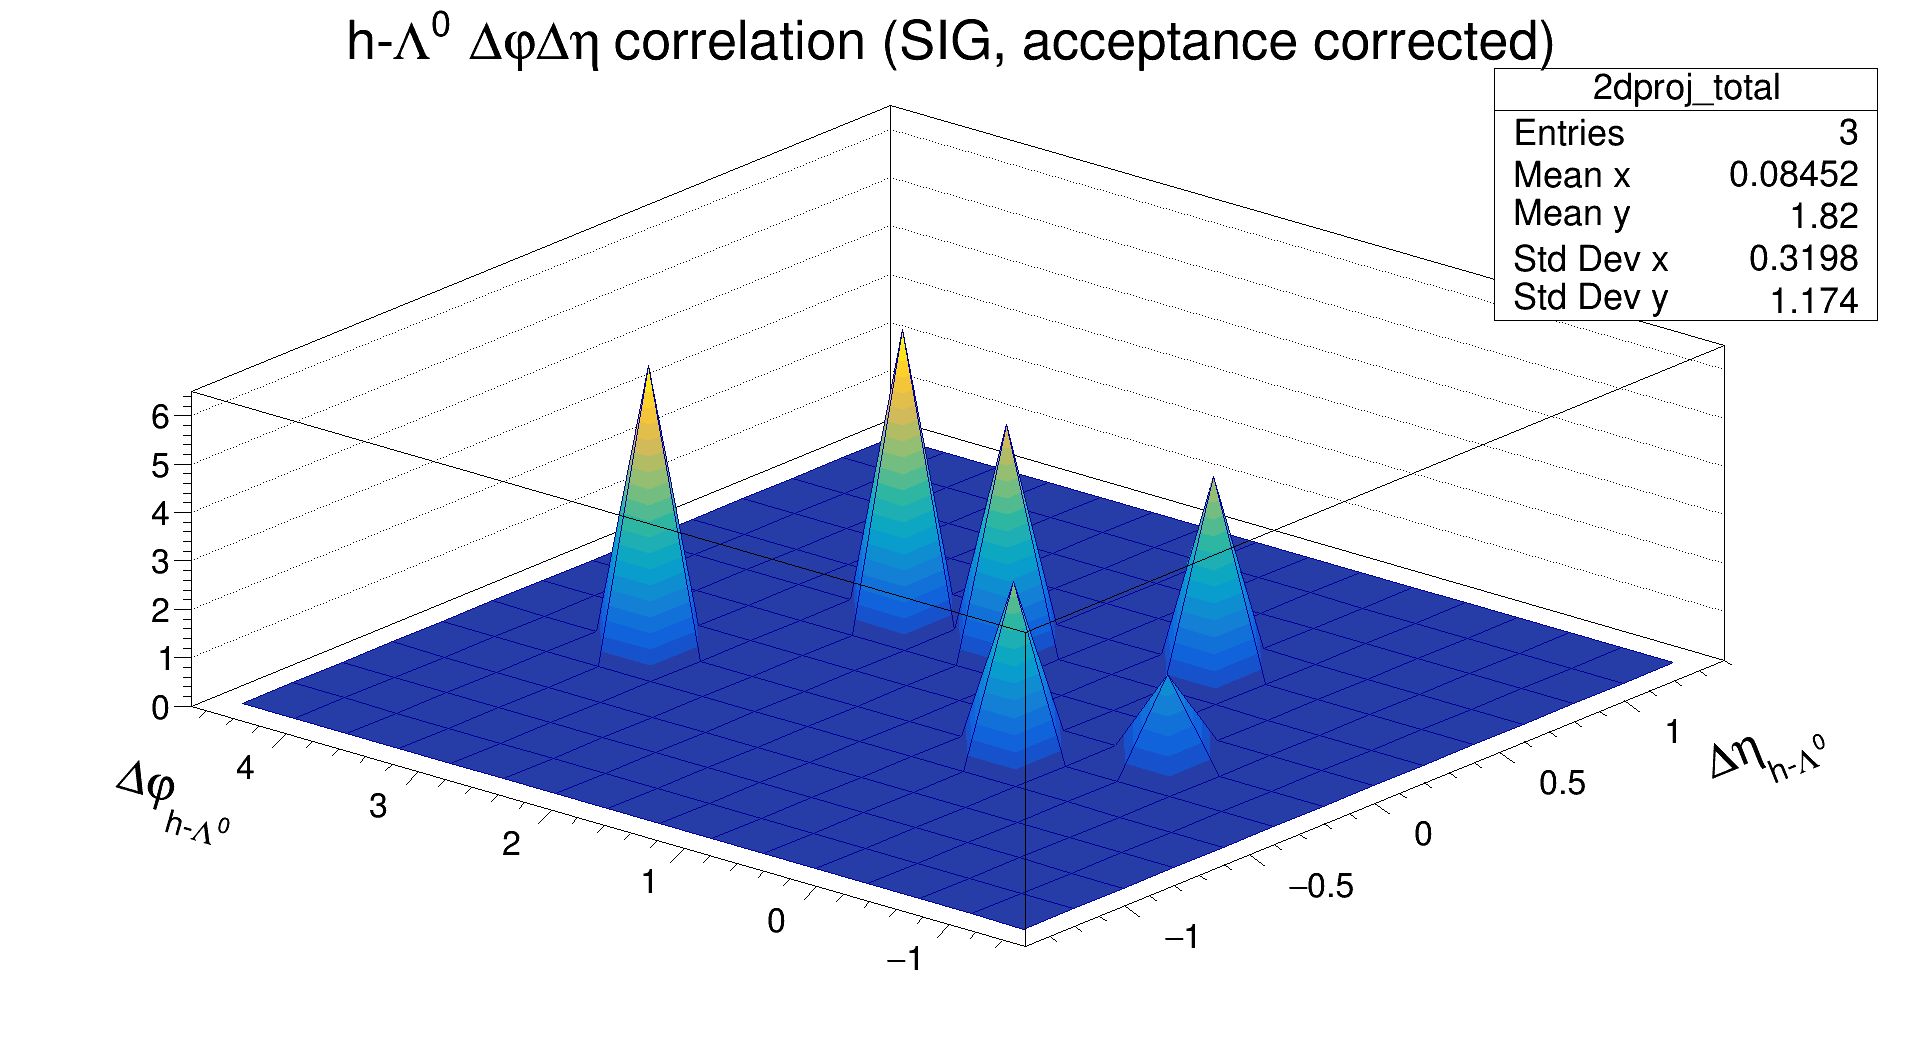

In [45]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_0_20.Draw("SURF1")
c.Draw()

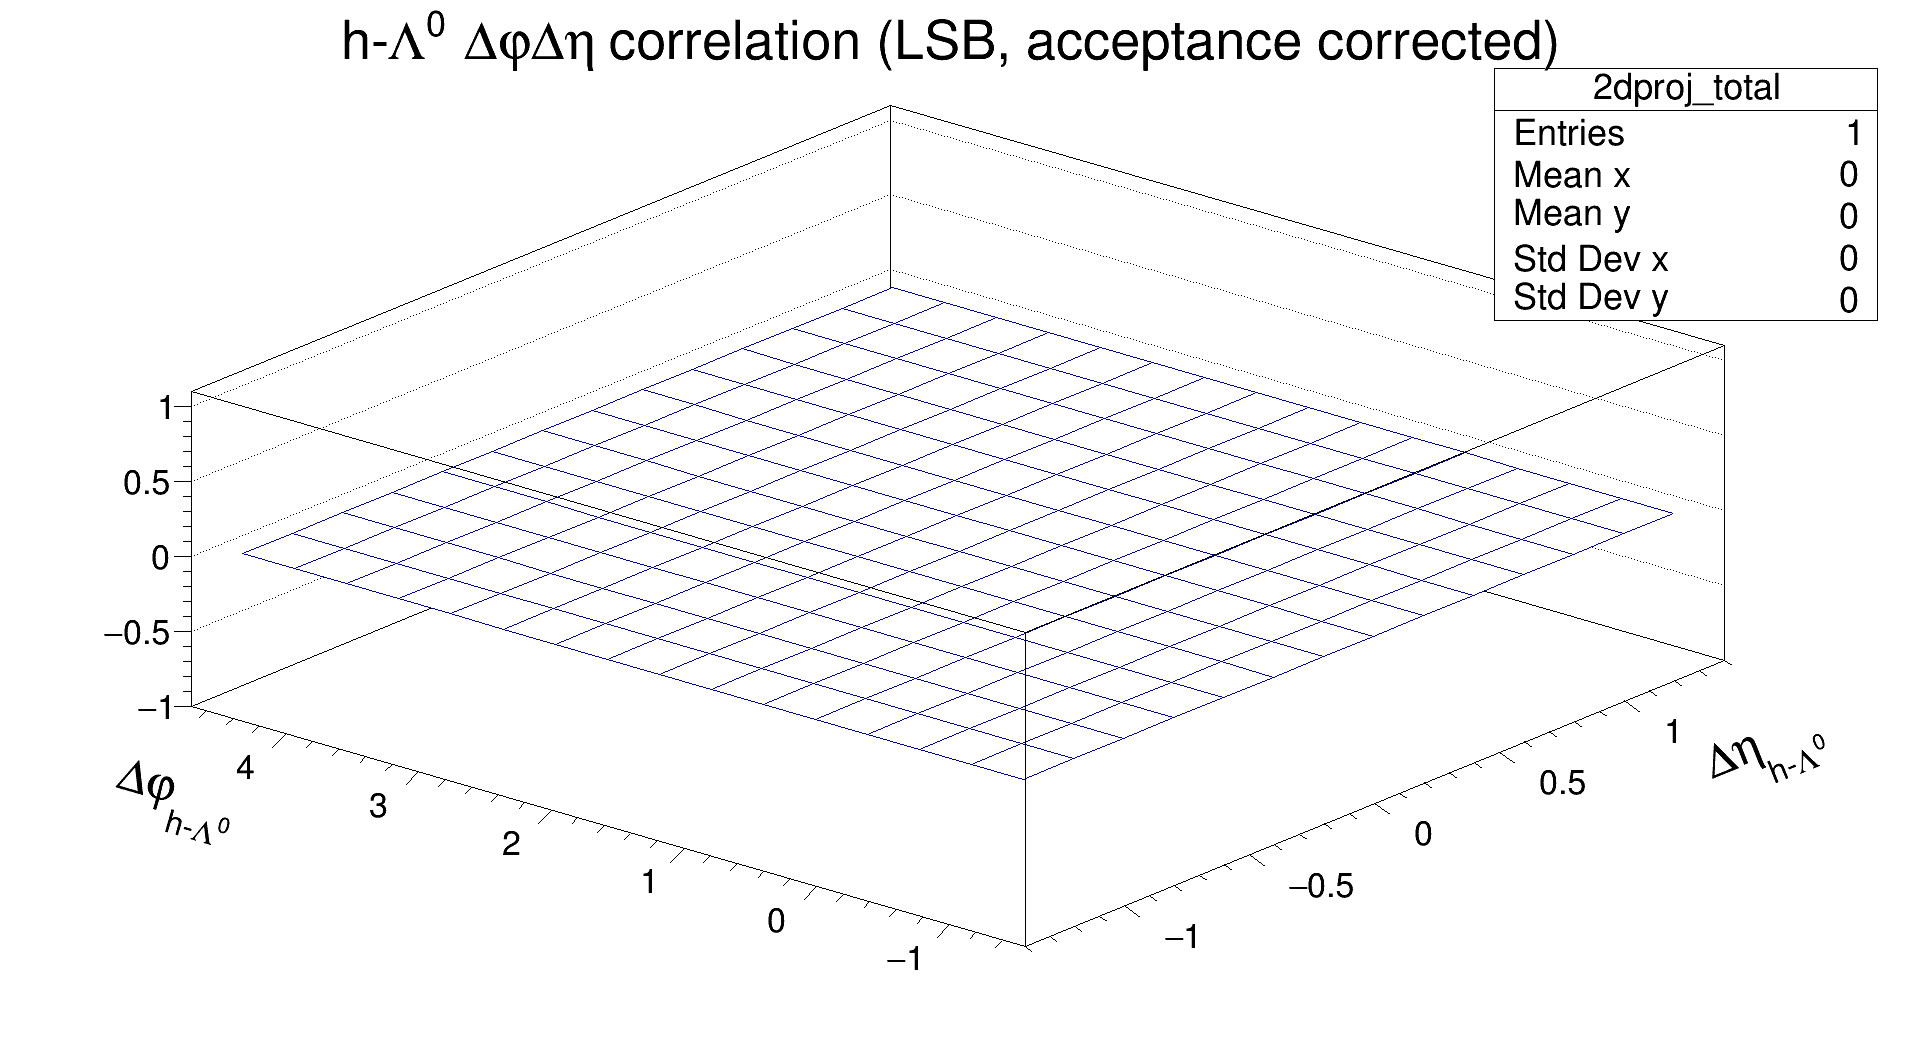

In [46]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_0_20.Draw("SURF1")
c.Draw()

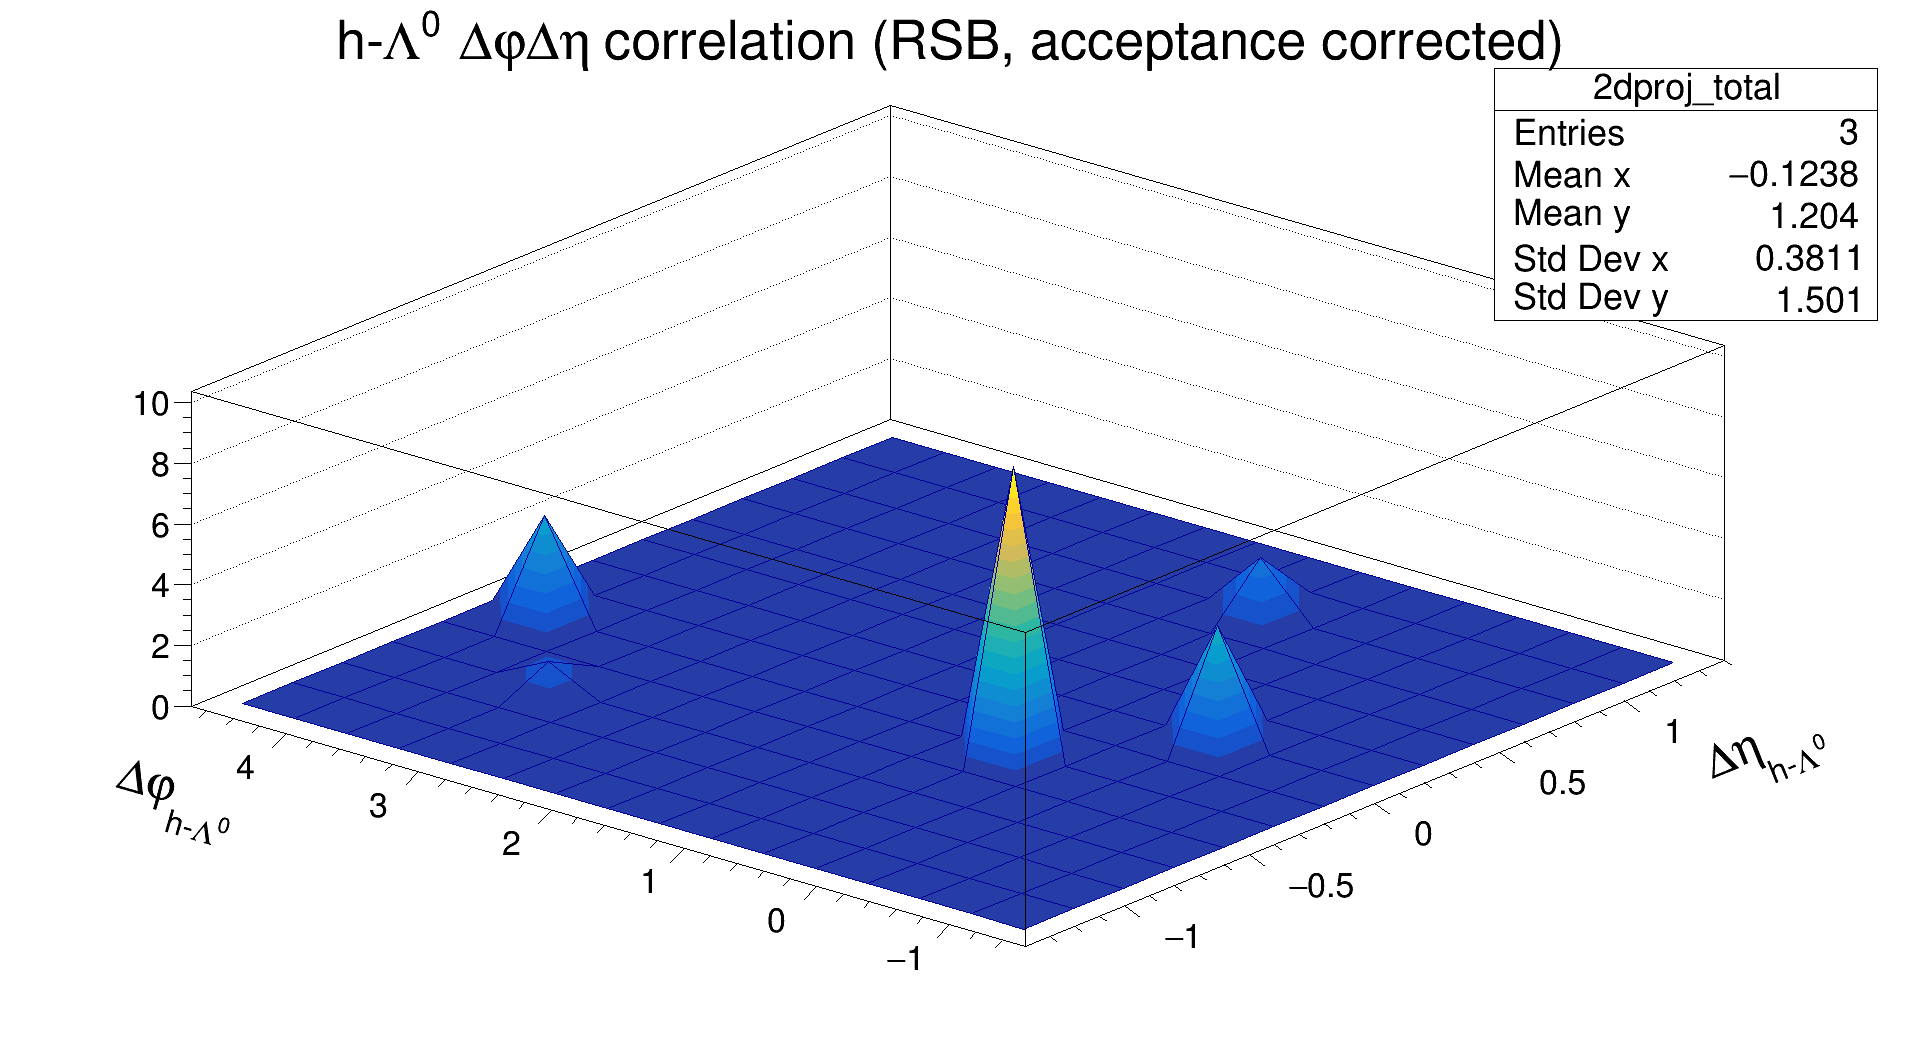

In [47]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_0_20.Draw("SURF1")
c.Draw()

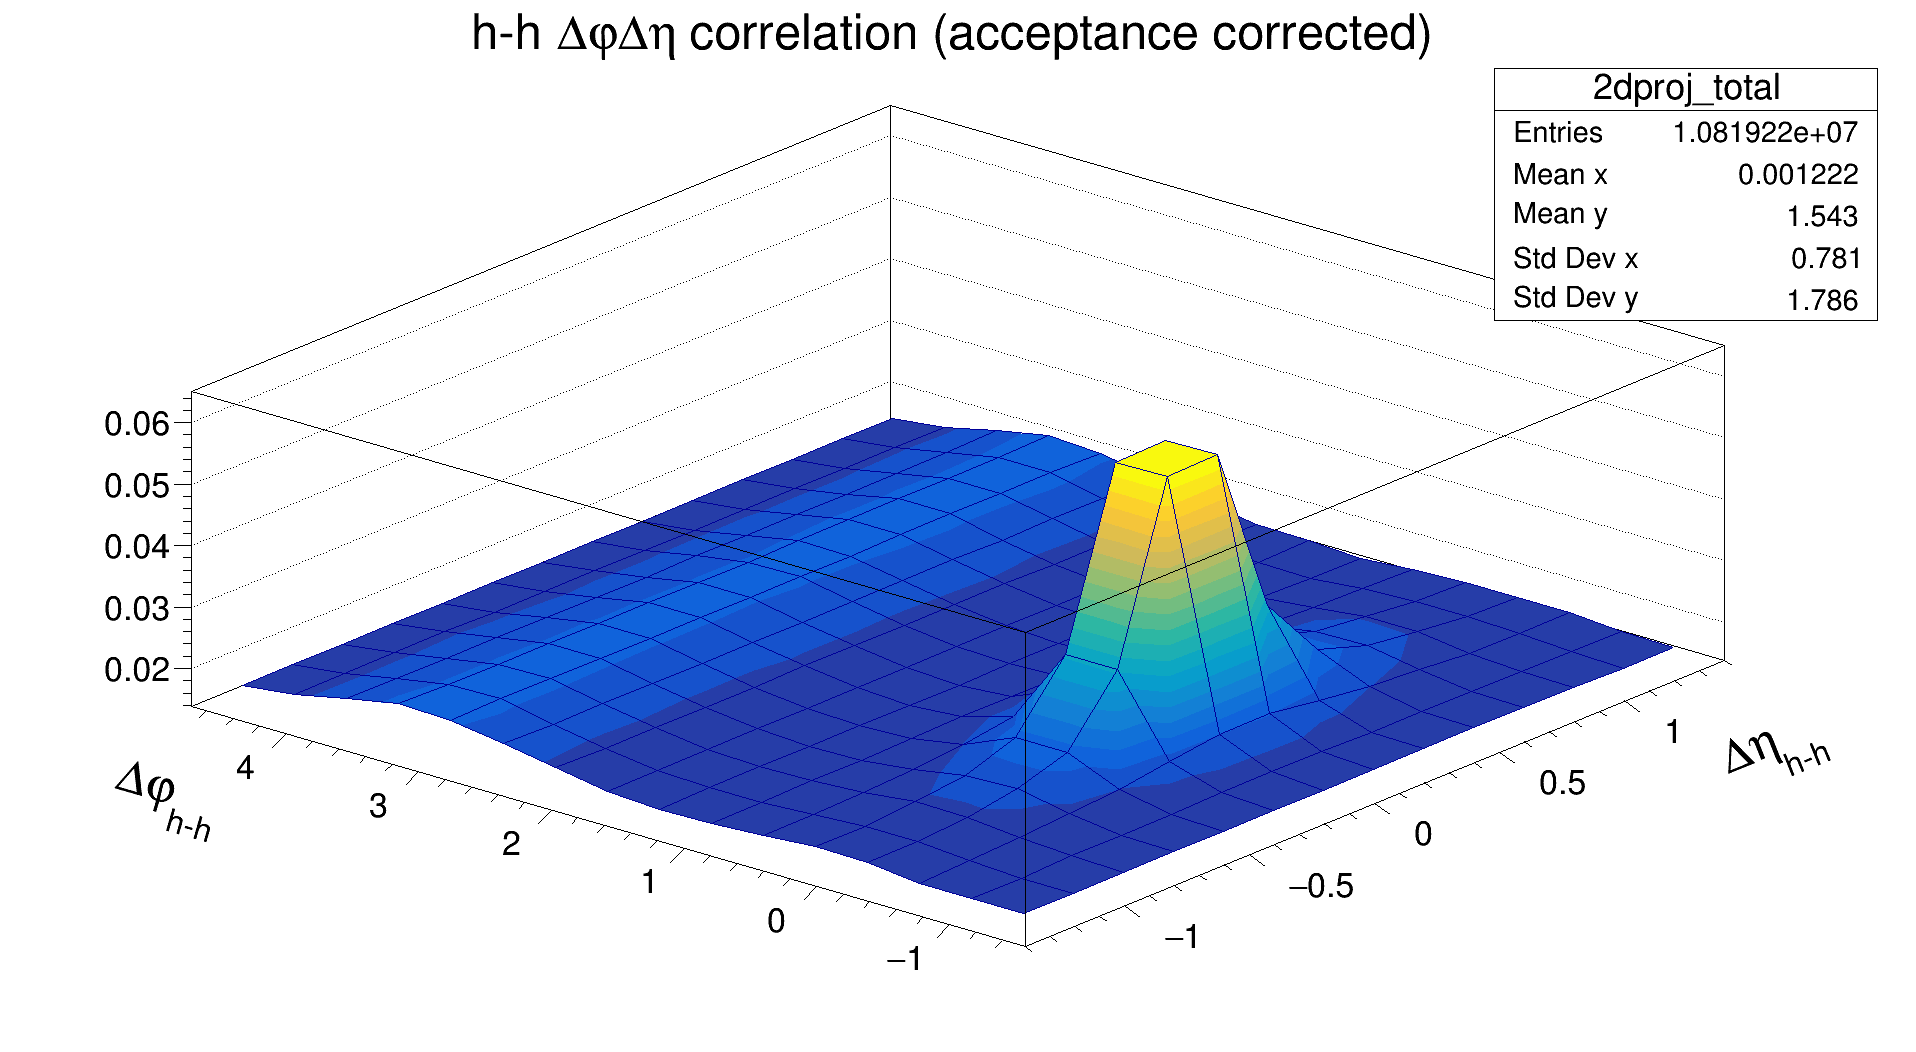

In [112]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_0_20.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_0_20.Draw("SURF1")
c.Draw()

In [49]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_2d_mixcor_rsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_lsb_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_sig_0_20.Scale(1.0/num_trigs_0_20)
h_lambda_ls_2d_mixcor_rsb_0_20.Scale(1.0/num_trigs_0_20)
h_h_2d_mixcor_0_20.Scale(1.0/num_trigs_0_20)

### Sideband subtraction section

In [49]:
# First comparing left and right sidebands
h_lambda_lsb_dphi_0_20 = h_lambda_2d_mixcor_lsb_0_20.ProjectionY("h_lambda_lsb_dphi_0_20")
h_lambda_rsb_dphi_0_20 = h_lambda_2d_mixcor_rsb_0_20.ProjectionY("h_lambda_rsb_dphi_0_20")
h_lambda_sig_dphi_0_20 = h_lambda_2d_mixcor_sig_0_20.ProjectionY("h_lambda_sig_dphi_0_20")
h_lambda_lsb_dphi_0_20.Scale(1/h_lambda_lsb_dphi_0_20.Integral())
h_lambda_rsb_dphi_0_20.Scale(1/h_lambda_rsb_dphi_0_20.Integral())
h_lambda_sig_dphi_0_20.Scale(1/h_lambda_sig_dphi_0_20.Integral())

In [50]:
h_lambda_lsb_dphi_0_20.SetTitle("h-#Lambda^{0} LSB (blue) vs RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_0_20.SetLineColor(rt.kBlue)
h_lambda_rsb_dphi_0_20.SetLineColor(rt.kRed)
h_lambda_sig_dphi_0_20.SetLineColor(rt.kGreen + 2)
h_lambda_lsb_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_lsb_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_lsb_dphi_0_20.GetXaxis().SetTitleOffset(0.5)
h_lambda_lsb_dphi_0_20.SetStats(0)
h_lambda_rsb_dphi_0_20.SetStats(0)
h_lambda_sig_dphi_0_20.SetStats(0)

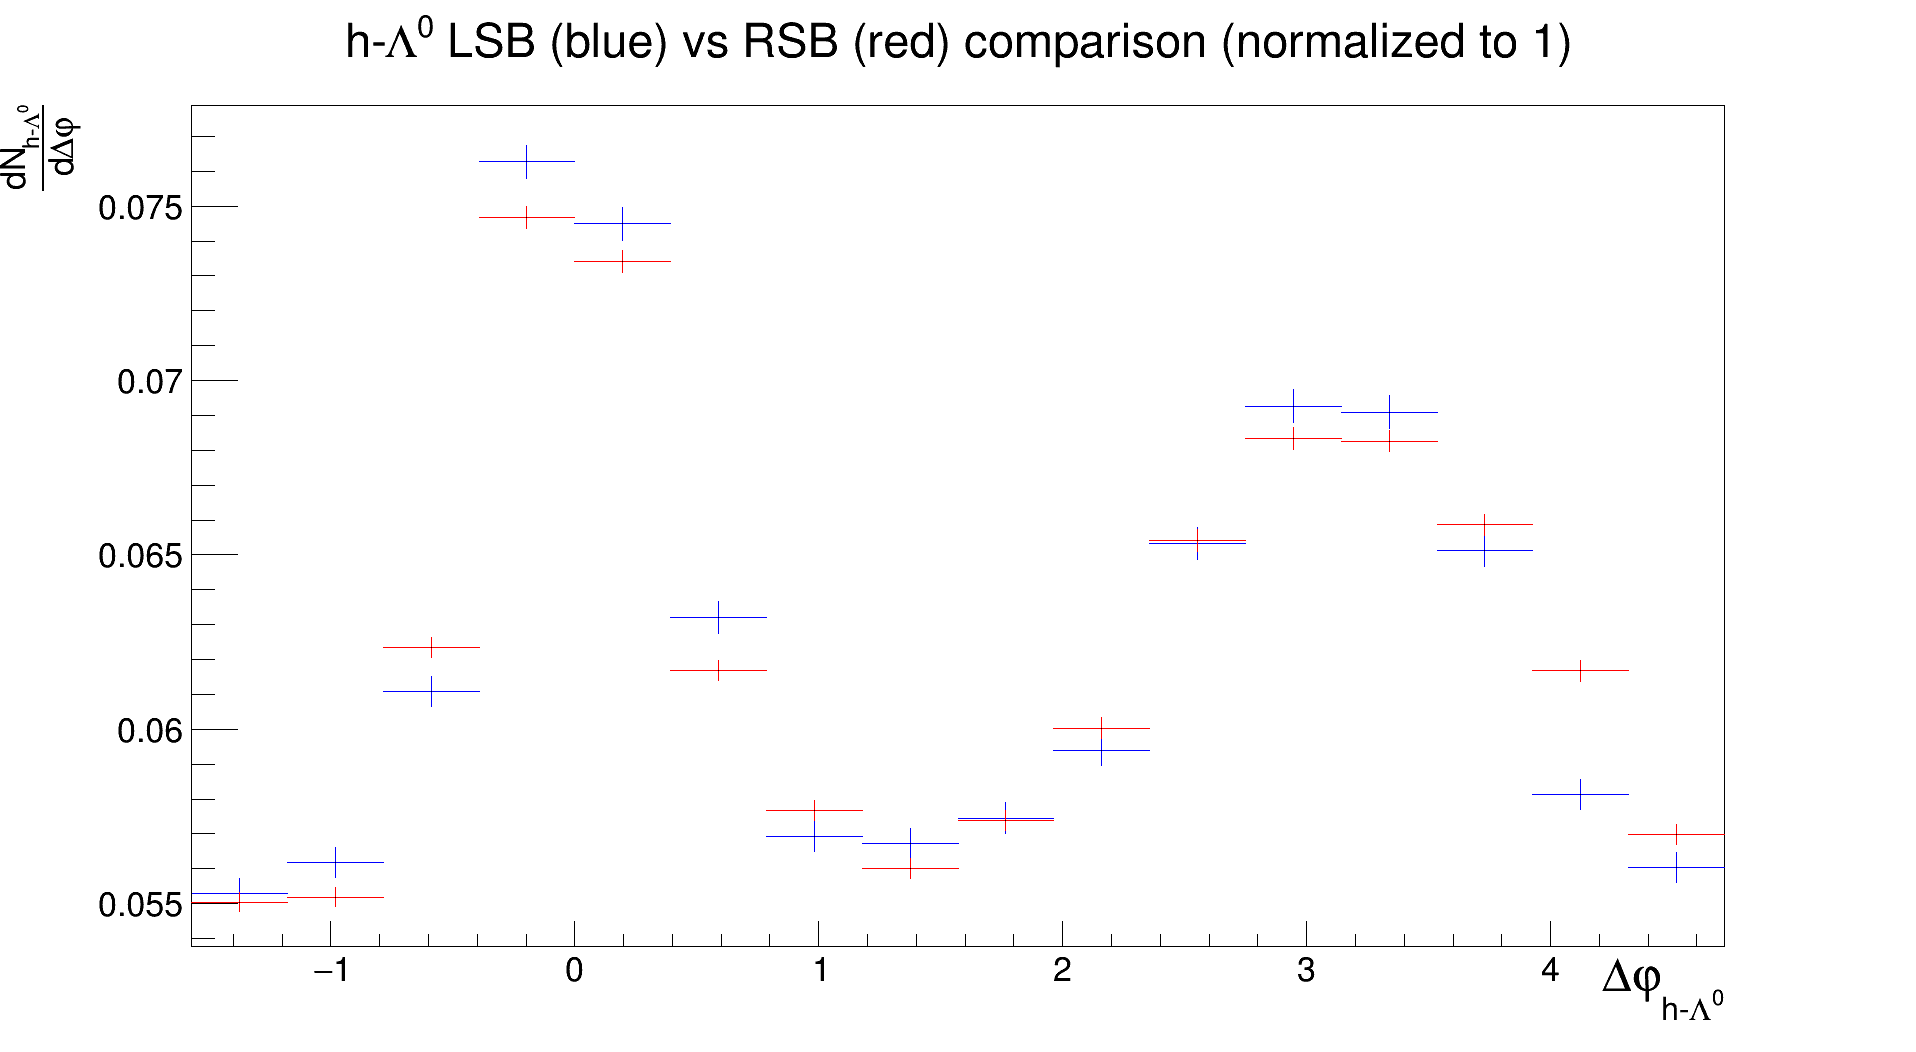

In [51]:
h_lambda_lsb_dphi_0_20.Draw()
h_lambda_rsb_dphi_0_20.Draw("SAME")
c.Draw()

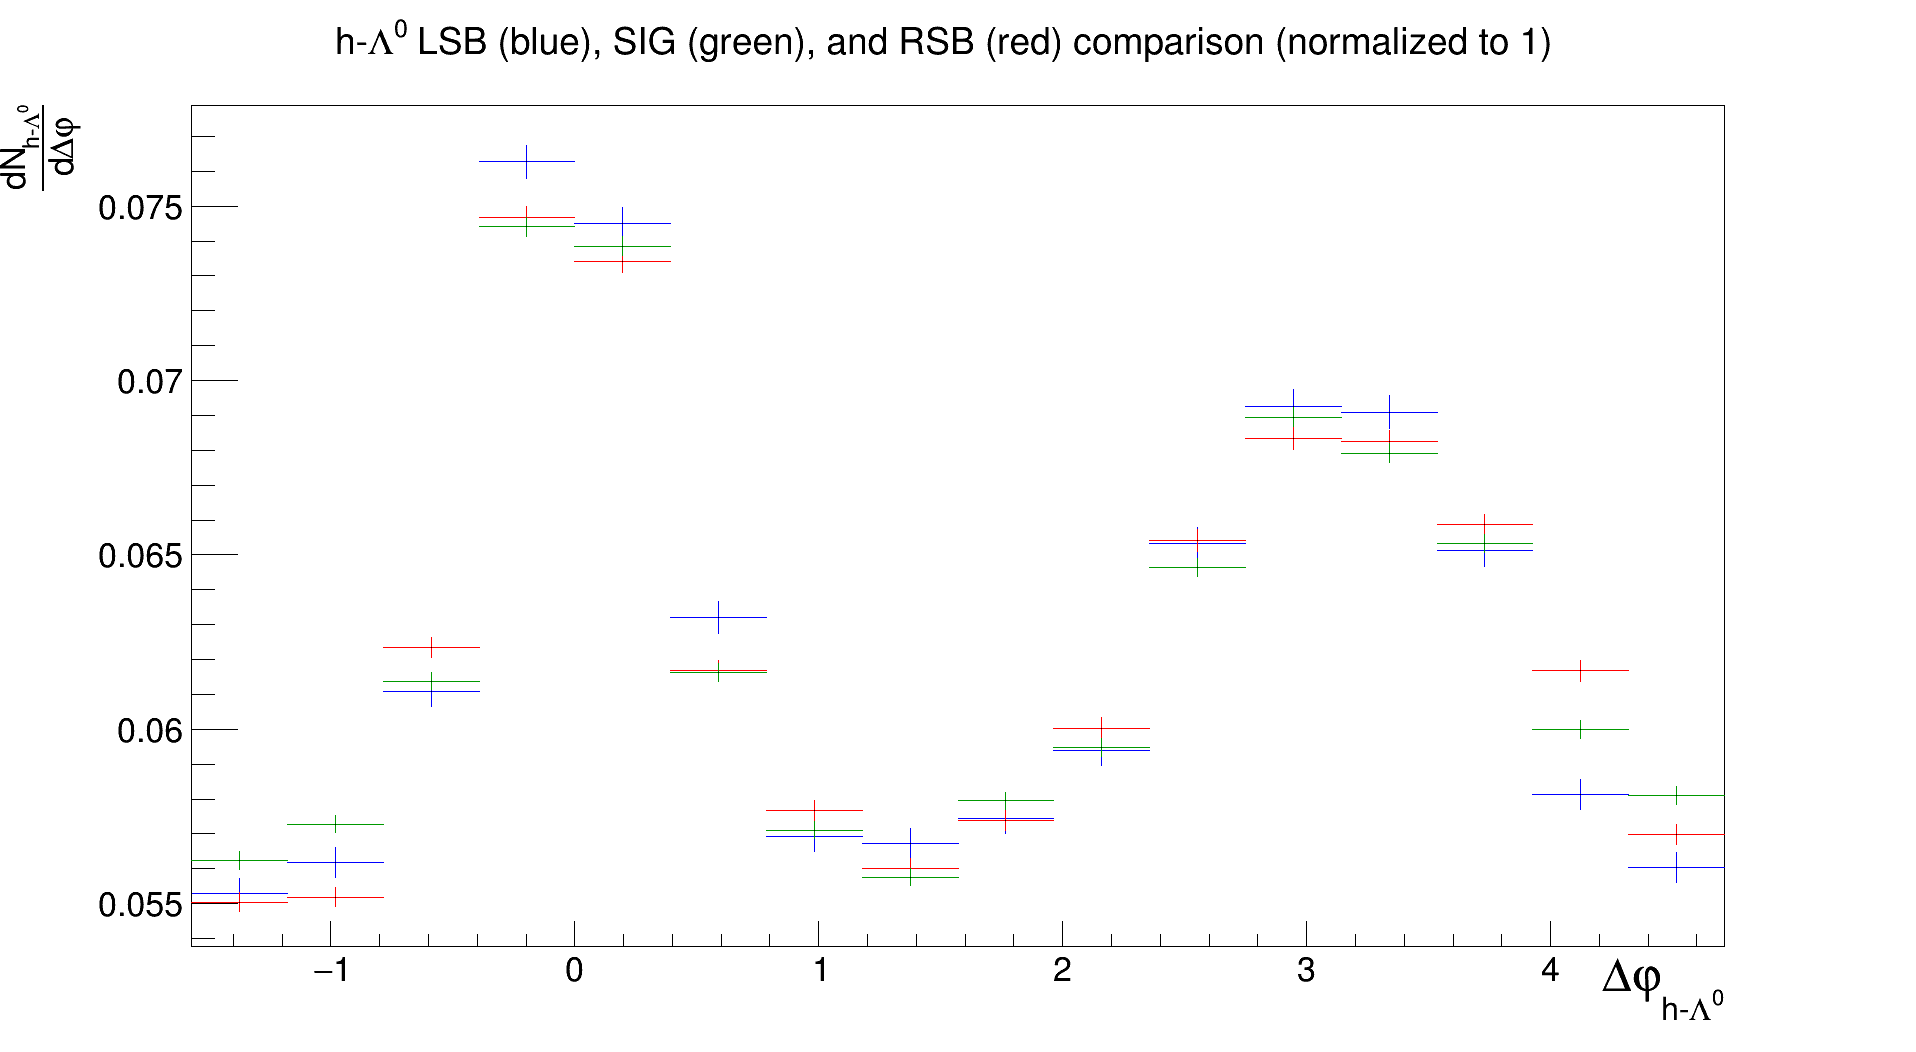

In [52]:
h_lambda_lsb_dphi_0_20.SetTitle("h-#Lambda^{0} LSB (blue), SIG (green), and RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_0_20.Draw()
h_lambda_rsb_dphi_0_20.Draw("SAME")
h_lambda_sig_dphi_0_20.Draw("SAME")
c.Draw()

In [53]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_0_20 = h_lambda_2d_mixcor_sig_0_20.Clone("h_lambda_2d_subtracted_0_20")
bg_integral_0_20 = (1 - lambda_signal_total_ratio_0_20)*h_lambda_2d_subtracted_0_20.Integral()
h_lambda_2d_subtracted_0_20.Add(h_lambda_2d_mixcor_rsb_0_20, -bg_integral_0_20)

True

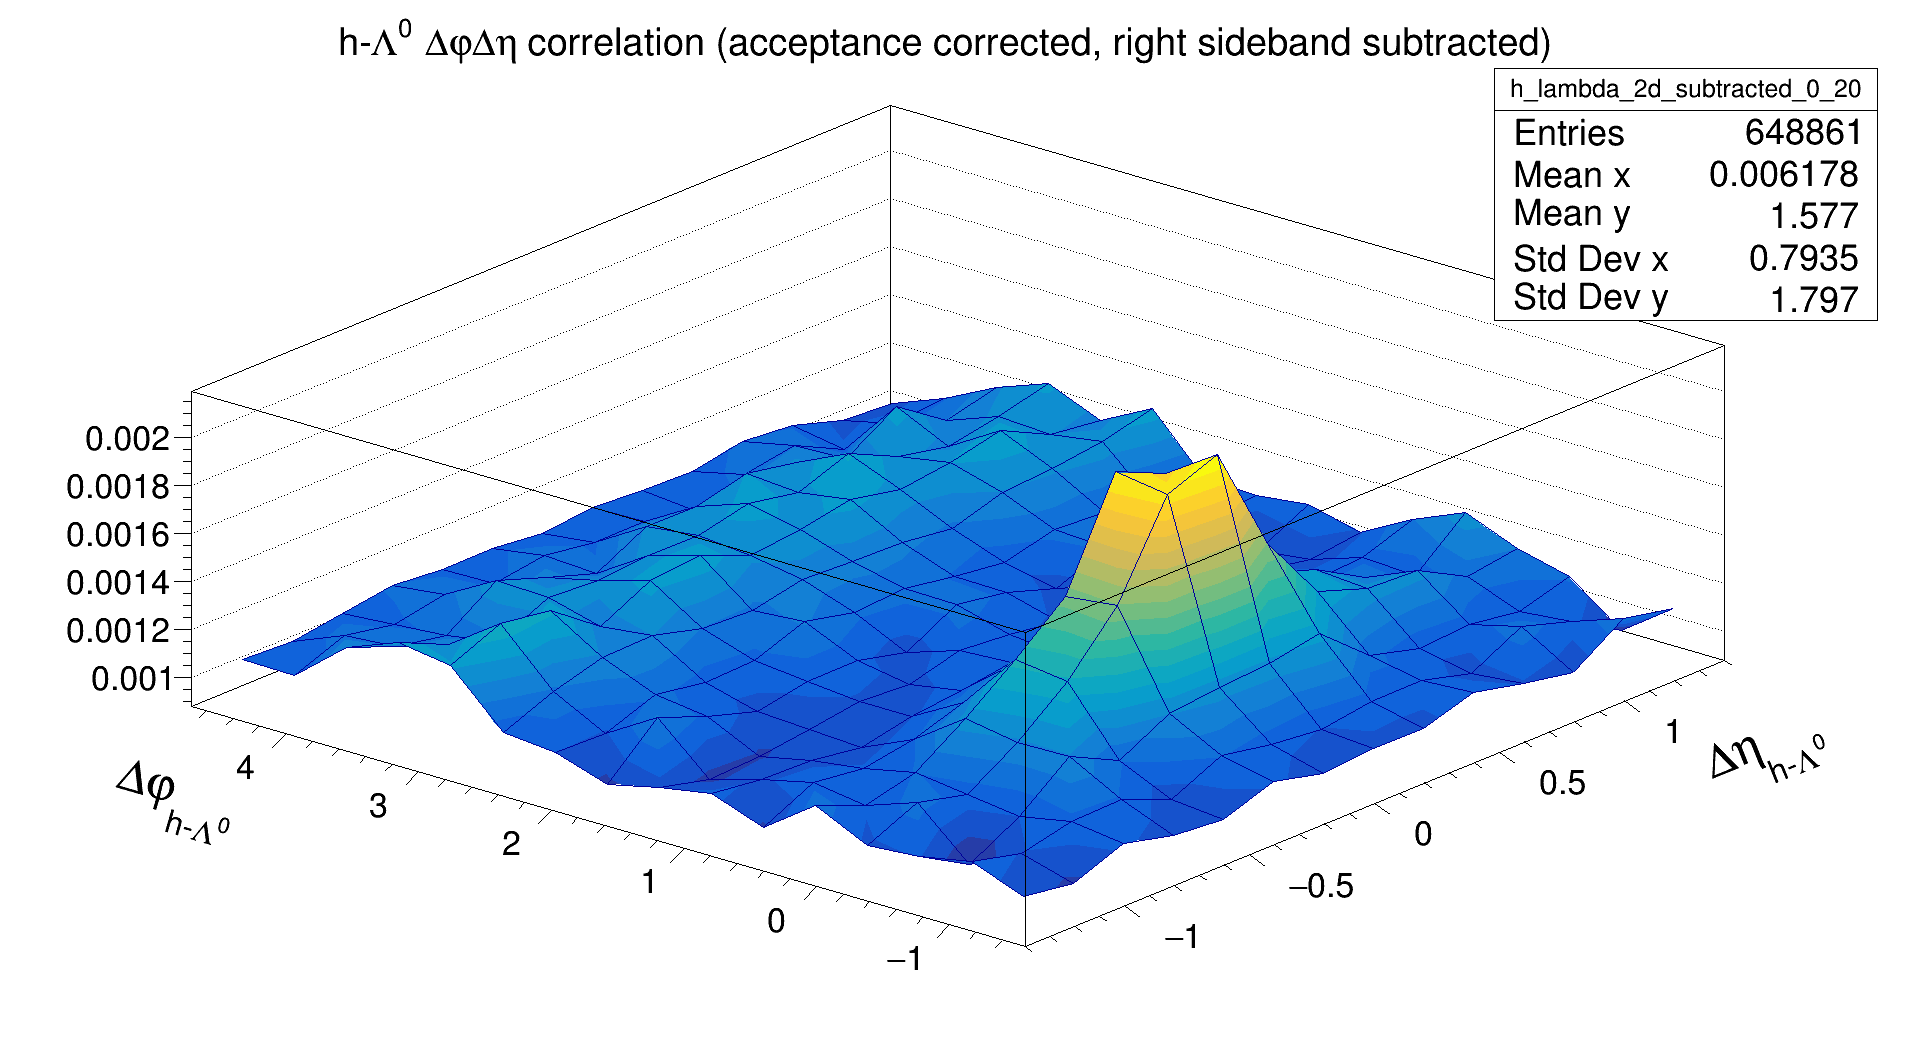

In [54]:
h_lambda_2d_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_0_20.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [55]:
h_lambda_dphi_subtracted_0_20 = h_lambda_2d_subtracted_0_20.ProjectionY("h_lambda_dphi_subtracted_0_20")
h_lambda_dphi_subtracted_0_20.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_lambda_dphi_subtracted_0_20.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_0_20.SetLineWidth(3)
h_lambda_dphi_subtracted_0_20.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_0_20.GetXaxis().SetTitleOffset(0.5)

In [56]:
ue_line_0_20 = rt.TF1("ue_line_0_20", "pol0", -2, 6)
ue_upper_line_0_20 = rt.TF1("ue_upper_line_0_20", "pol0", -2, 6)
ue_lower_line_0_20 = rt.TF1("ue_lower_line_0_20", "pol0", -2, 6)
zero_line_0_20 = rt.TF1("zero_line_0_20", "pol0", -2, 6)
zero_upper_line_0_20 = rt.TF1("zero_upper_line_0_20", "pol0", -2, 6)
zero_lower_line_0_20 = rt.TF1("zero_lower_line_0_20", "pol0", -2, 6)
ue_avg_0_20 = (h_lambda_dphi_subtracted_0_20.GetBinContent(1) 
               + h_lambda_dphi_subtracted_0_20.GetBinContent(8)
               + h_lambda_dphi_subtracted_0_20.GetBinContent(9)
               + h_lambda_dphi_subtracted_0_20.GetBinContent(16))/4

ue_avg_error_0_20 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_0_20.GetBinError(1)**2 
               + h_lambda_dphi_subtracted_0_20.GetBinError(8)**2
               + h_lambda_dphi_subtracted_0_20.GetBinError(9)**2
               + h_lambda_dphi_subtracted_0_20.GetBinError(16)**2))


ue_line_0_20.SetParameter(0, ue_avg_0_20)
ue_line_0_20.SetLineColor(rt.kViolet - 6)
ue_line_0_20.SetLineWidth(3)
ue_line_0_20.SetLineStyle(rt.kSolid)

ue_upper_line_0_20.SetParameter(0, ue_avg_0_20 + ue_avg_error_0_20)
ue_upper_line_0_20.SetLineColor(rt.kViolet - 6)
ue_upper_line_0_20.SetLineStyle(rt.kDashed)

ue_lower_line_0_20.SetParameter(0, ue_avg_0_20 - ue_avg_error_0_20)
ue_lower_line_0_20.SetLineColor(rt.kViolet - 6)
ue_lower_line_0_20.SetLineStyle(rt.kDashed)

zero_line_0_20.SetParameter(0, 0)
zero_line_0_20.SetLineColor(rt.kViolet - 6)
zero_line_0_20.SetLineWidth(3)
zero_line_0_20.SetLineStyle(rt.kSolid)
zero_upper_line_0_20.SetParameter(0, ue_avg_error_0_20)
zero_upper_line_0_20.SetLineColor(rt.kViolet - 6)
zero_upper_line_0_20.SetLineStyle(rt.kDashed)
zero_lower_line_0_20.SetParameter(0, -ue_avg_error_0_20)
zero_lower_line_0_20.SetLineColor(rt.kViolet - 6)
zero_lower_line_0_20.SetLineStyle(rt.kDashed)

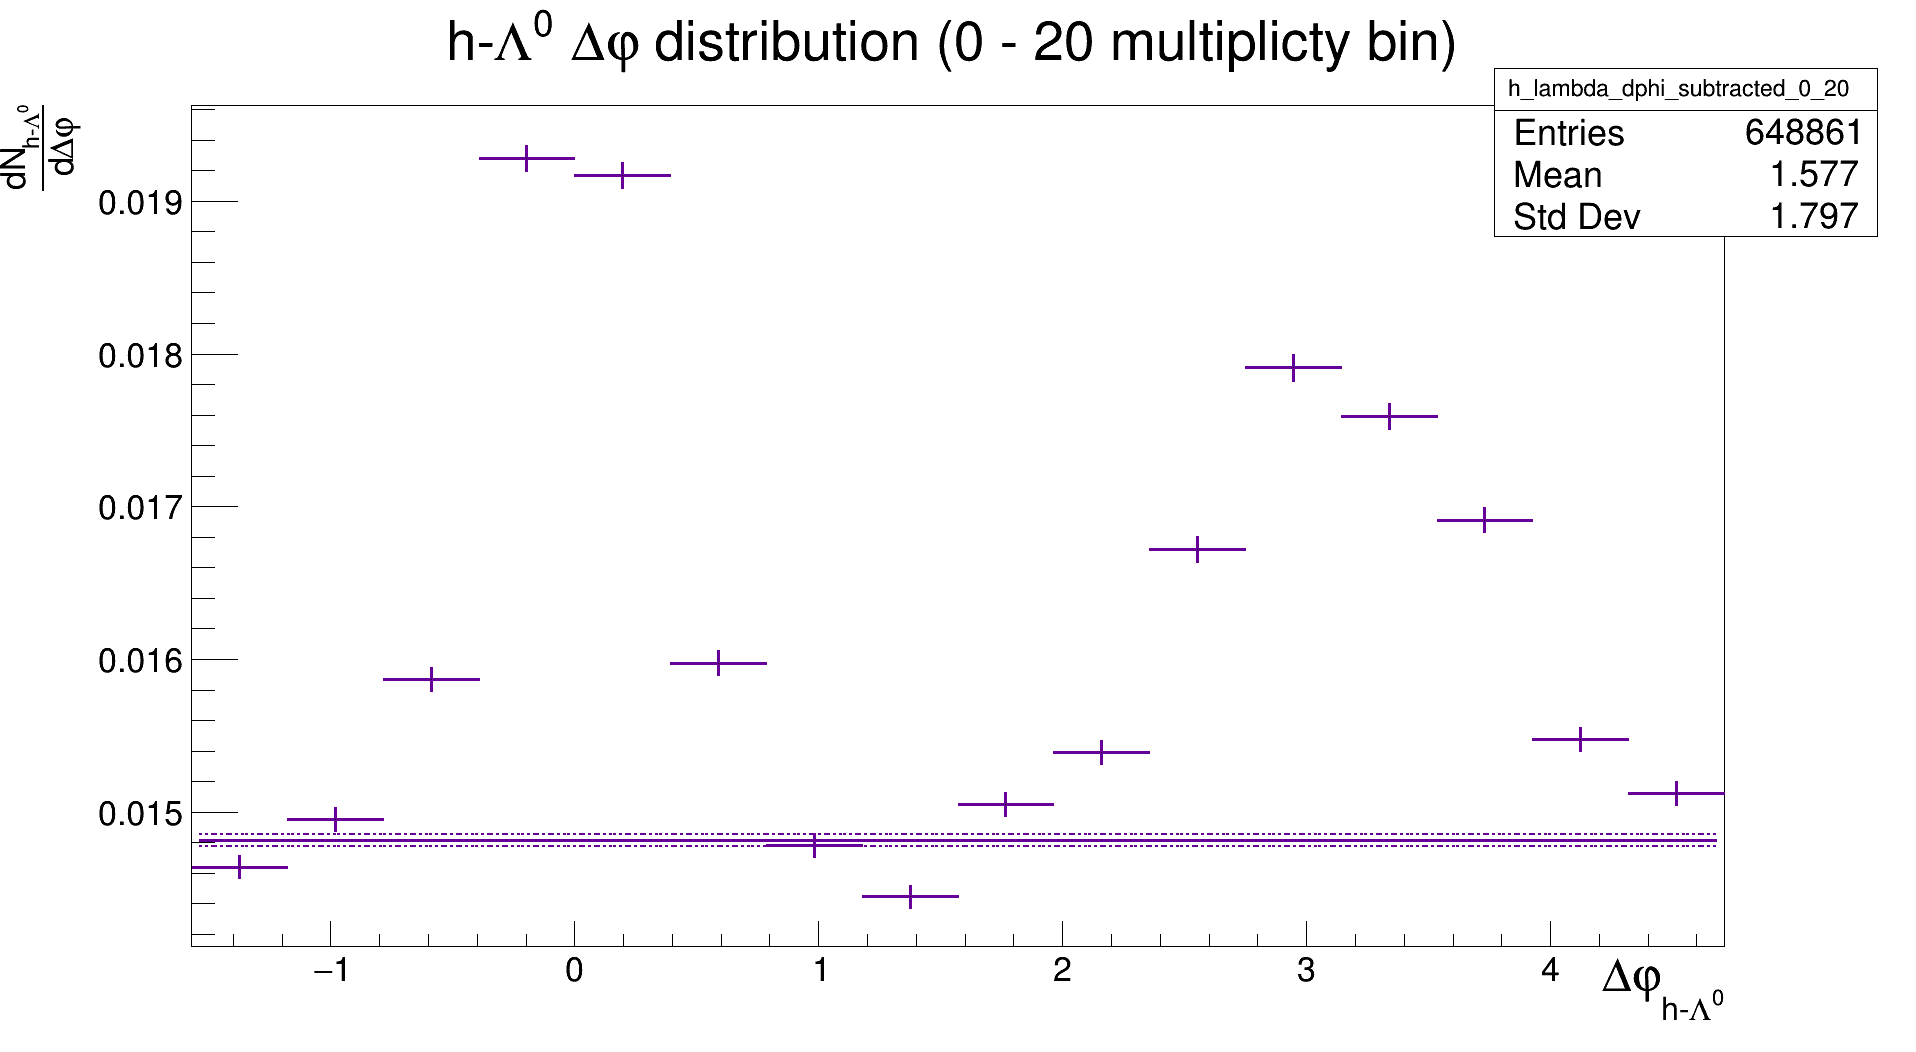

In [57]:
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [58]:
h_lambda_dphi_fit_0_20 = rt.TF1("h_lambda_dphi_fit_0_20", "gaus(0) + gaus(3) + pol0(6)", -math.pi/2, 3*math.pi/2)
h_lambda_dphi_fit_0_20.SetParameter(0, 0.01)

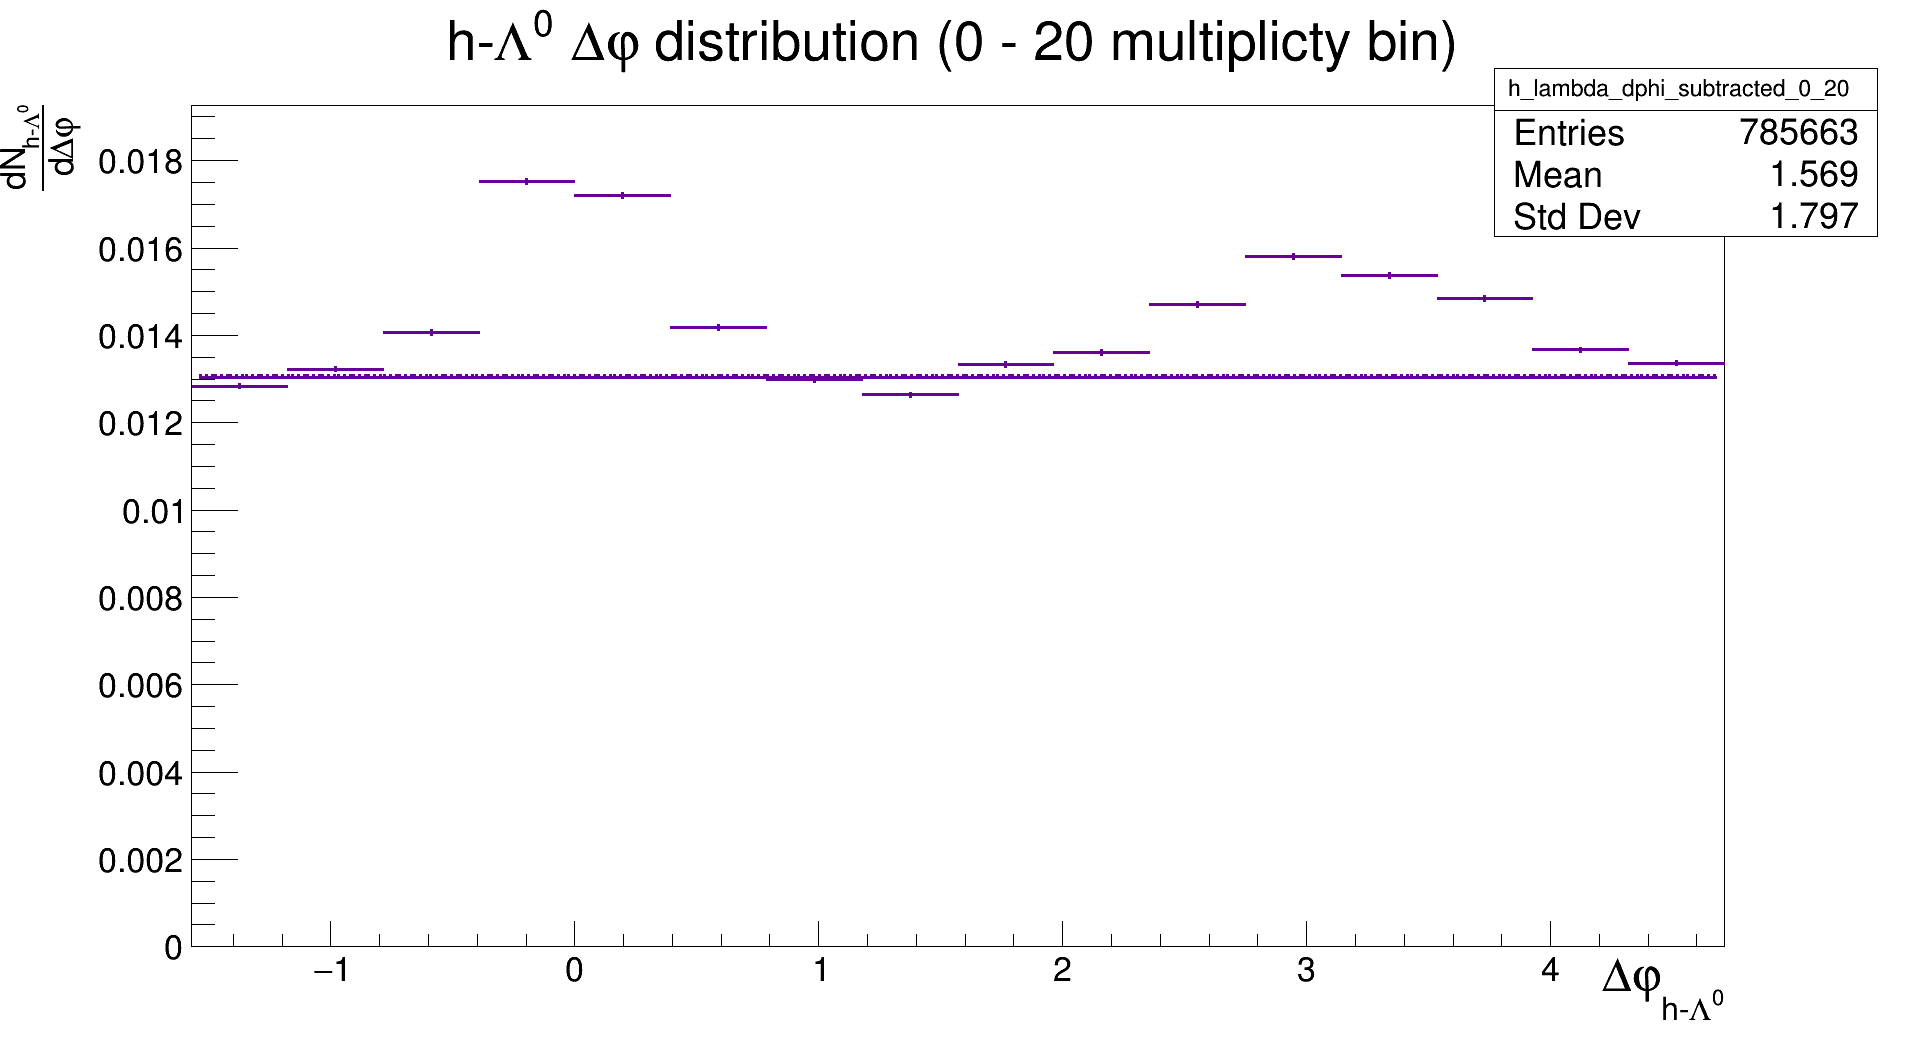

In [58]:
h_lambda_dphi_subtracted_0_20.GetYaxis().SetRangeUser(0, h_lambda_dphi_subtracted_0_20.GetMaximum()*1.1)
h_lambda_dphi_subtracted_0_20.Draw()
ue_line_0_20.Draw("SAME")
ue_upper_line_0_20.Draw("SAME")
ue_lower_line_0_20.Draw("SAME")
c.Draw()

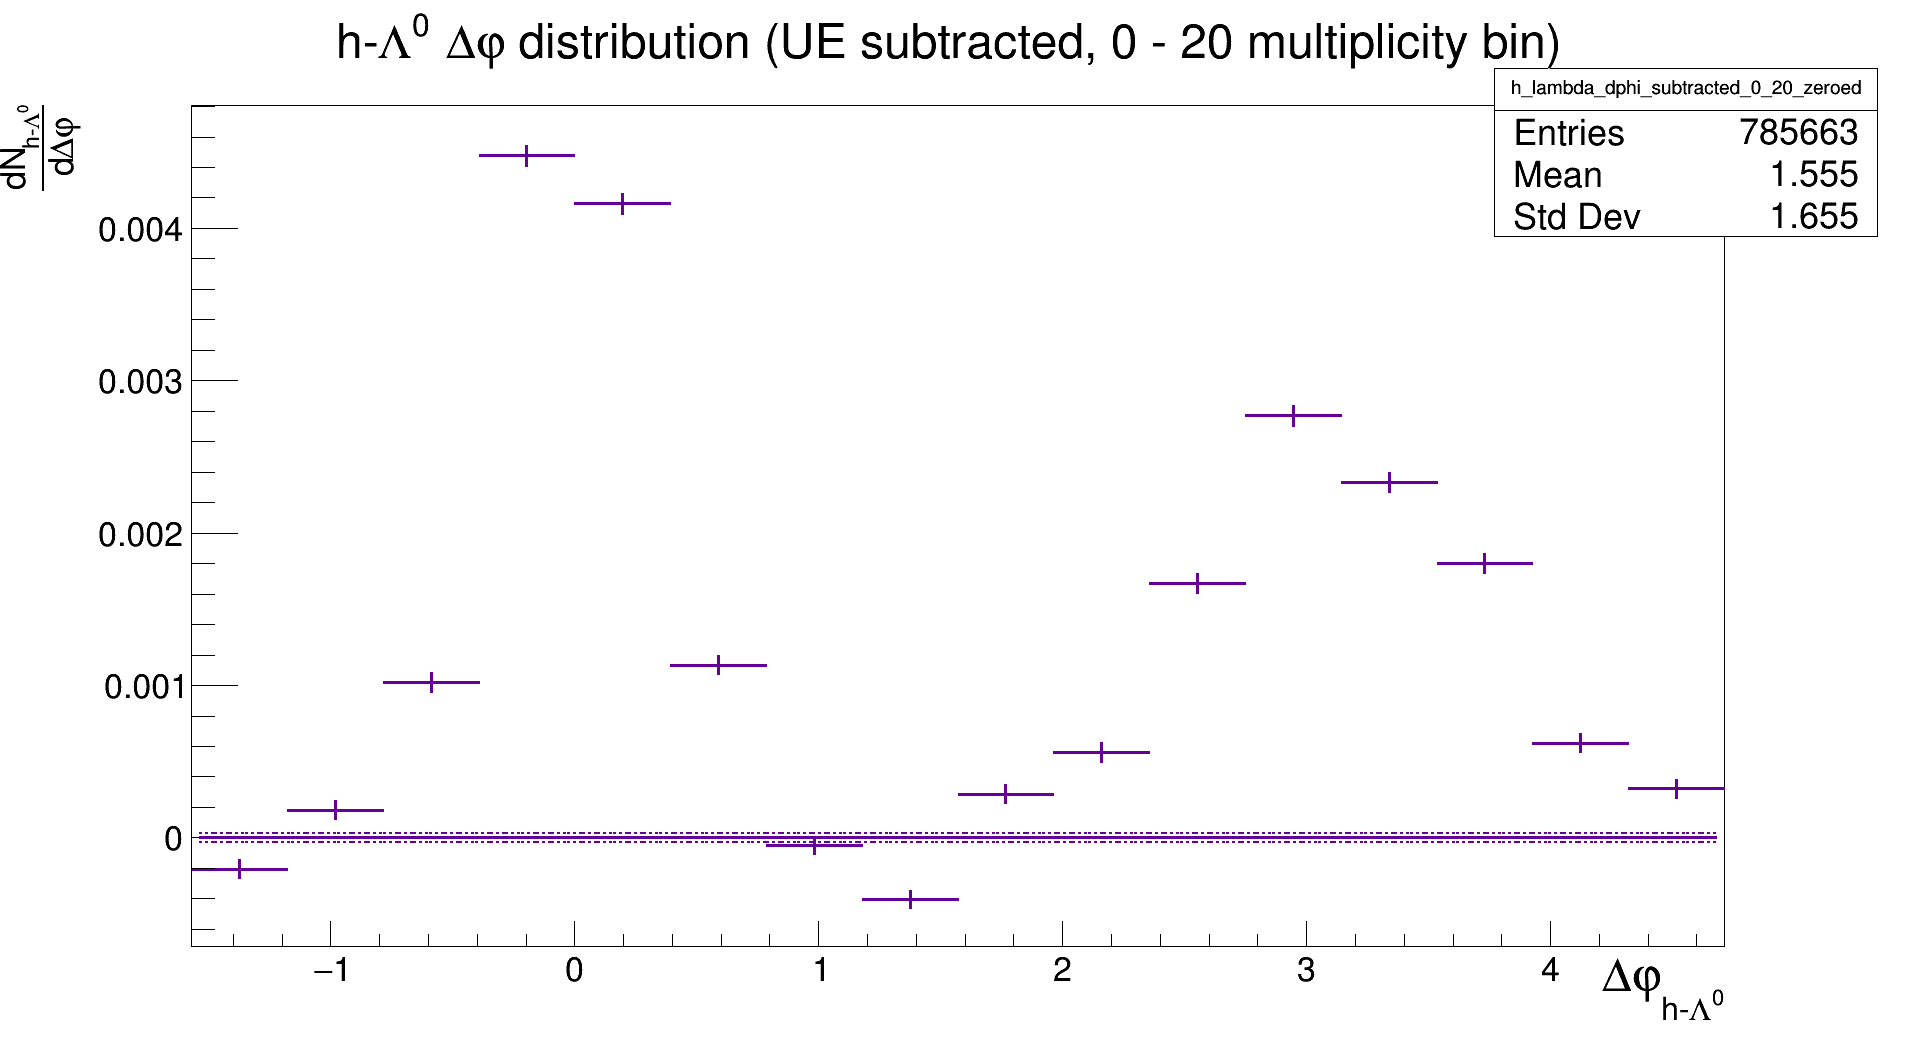

In [59]:
h_lambda_dphi_subtracted_0_20_zeroed = h_lambda_dphi_subtracted_0_20.Clone("h_lambda_dphi_subtracted_0_20_zeroed")
h_lambda_dphi_subtracted_0_20_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_lambda_dphi_subtracted_0_20_zeroed.Add(ue_line_0_20, -1)
h_lambda_dphi_subtracted_0_20_zeroed.Draw()
zero_line_0_20.Draw("SAME")
zero_upper_line_0_20.Draw("SAME")
zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [60]:
DPHI_BINS = h_lambda_dphi_subtracted_0_20.GetNbinsX()

In [61]:
h_lambda_total_integral_0_20 = 0
h_lambda_near_integral_0_20 = 0
h_lambda_away_integral_0_20 = 0
h_lambda_ue_integral_0_20 = ue_avg_0_20*DPHI_BINS

h_lambda_total_integral_error_0_20 = 0
h_lambda_near_integral_error_0_20 = 0
h_lambda_away_integral_error_0_20 = 0
h_lambda_ue_integral_error_0_20 = ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_0_20 += h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num)
    h_lambda_total_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
    if bin_num < 9:
        h_lambda_near_integral_0_20 += (h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num) - ue_avg_0_20)
        h_lambda_near_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_near_integral_error_0_20 += ue_avg_error_0_20**2
    else:
        h_lambda_away_integral_0_20 += (h_lambda_dphi_subtracted_0_20.GetBinContent(bin_num) - ue_avg_0_20)
        h_lambda_away_integral_error_0_20 += h_lambda_dphi_subtracted_0_20.GetBinError(bin_num)**2
        h_lambda_away_integral_error_0_20 += ue_avg_error_0_20**2
h_lambda_total_integral_error_0_20 = math.sqrt(h_lambda_total_integral_error_0_20)
h_lambda_near_integral_error_0_20 = math.sqrt(h_lambda_near_integral_error_0_20)
h_lambda_away_integral_error_0_20 = math.sqrt(h_lambda_away_integral_error_0_20)

In [62]:
h_h_dphi_0_20 = h_h_2d_mixcor_0_20.ProjectionY("h_h_dphi_0_20")
h_h_dphi_0_20.SetTitle("h-h #Delta#varphi distribution (0 - 20 multiplicty bin)")
h_h_dphi_0_20.SetLineColor(rt.kBlue)
h_h_dphi_0_20.SetLineWidth(3)
h_h_dphi_0_20.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_0_20.GetXaxis().SetTitleSize(0.05)
h_h_dphi_0_20.GetXaxis().SetTitleOffset(0.5)

In [63]:
hh_ue_line_0_20 = rt.TF1("hh_ue_line_0_20", "pol0", -2, 6)
hh_ue_upper_line_0_20 = rt.TF1("hh_ue_upper_line_0_20", "pol0", -2, 6)
hh_ue_lower_line_0_20 = rt.TF1("hh_ue_lower_line_0_20", "pol0", -2, 6)
hh_zero_line_0_20 = rt.TF1("hh_zero_line_0_20", "pol0", -2, 6)
hh_zero_upper_line_0_20 = rt.TF1("hh_zero_upper_line_0_20", "pol0", -2, 6)
hh_zero_lower_line_0_20 = rt.TF1("hh_zero_lower_line_0_20", "pol0", -2, 6)
hh_ue_avg_0_20 = (h_h_dphi_0_20.GetBinContent(1) 
               + h_h_dphi_0_20.GetBinContent(8)
               + h_h_dphi_0_20.GetBinContent(9)
               + h_h_dphi_0_20.GetBinContent(16))/4

hh_ue_avg_error_0_20 = (1/4)*(math.sqrt(h_h_dphi_0_20.GetBinError(1)**2 
               + h_h_dphi_0_20.GetBinError(8)**2
               + h_h_dphi_0_20.GetBinError(9)**2
               + h_h_dphi_0_20.GetBinError(16)**2))


hh_ue_line_0_20.SetParameter(0, hh_ue_avg_0_20)
hh_ue_line_0_20.SetLineColor(rt.kBlue)
hh_ue_line_0_20.SetLineWidth(3)
hh_ue_line_0_20.SetLineStyle(rt.kSolid)

hh_ue_upper_line_0_20.SetParameter(0, hh_ue_avg_0_20 + hh_ue_avg_error_0_20)
hh_ue_upper_line_0_20.SetLineColor(rt.kBlue)
hh_ue_upper_line_0_20.SetLineStyle(rt.kDashed)

hh_ue_lower_line_0_20.SetParameter(0, hh_ue_avg_0_20 - hh_ue_avg_error_0_20)
hh_ue_lower_line_0_20.SetLineColor(rt.kBlue)
hh_ue_lower_line_0_20.SetLineStyle(rt.kDashed)

hh_zero_line_0_20.SetParameter(0, 0)
hh_zero_line_0_20.SetLineColor(rt.kBlue)
hh_zero_line_0_20.SetLineWidth(3)
hh_zero_line_0_20.SetLineStyle(rt.kSolid)
hh_zero_upper_line_0_20.SetParameter(0, hh_ue_avg_error_0_20)
hh_zero_upper_line_0_20.SetLineColor(rt.kBlue)
hh_zero_upper_line_0_20.SetLineStyle(rt.kDashed)
hh_zero_lower_line_0_20.SetParameter(0, -hh_ue_avg_error_0_20)
hh_zero_lower_line_0_20.SetLineColor(rt.kBlue)
hh_zero_lower_line_0_20.SetLineStyle(rt.kDashed)

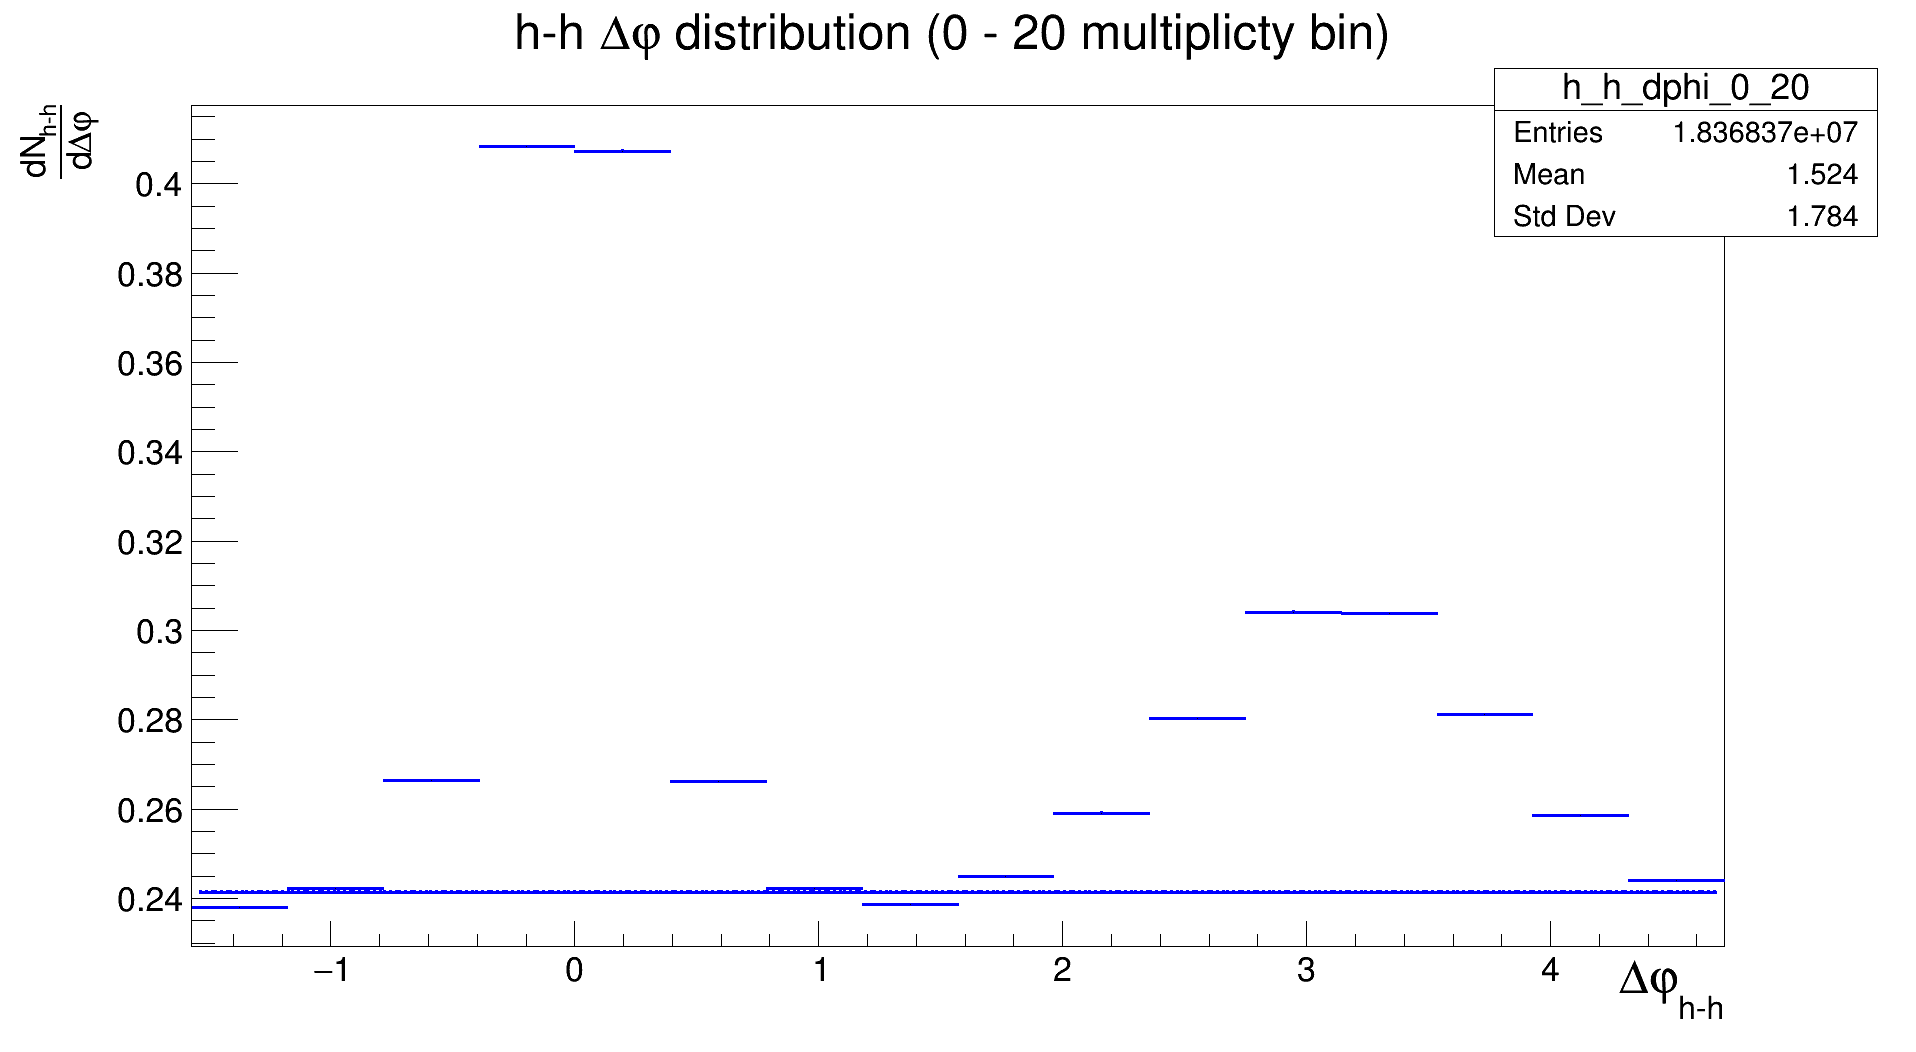

In [64]:
h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

In [65]:
print(h_h_dphi_0_20.GetBinContent(4))

0.4083608734145684


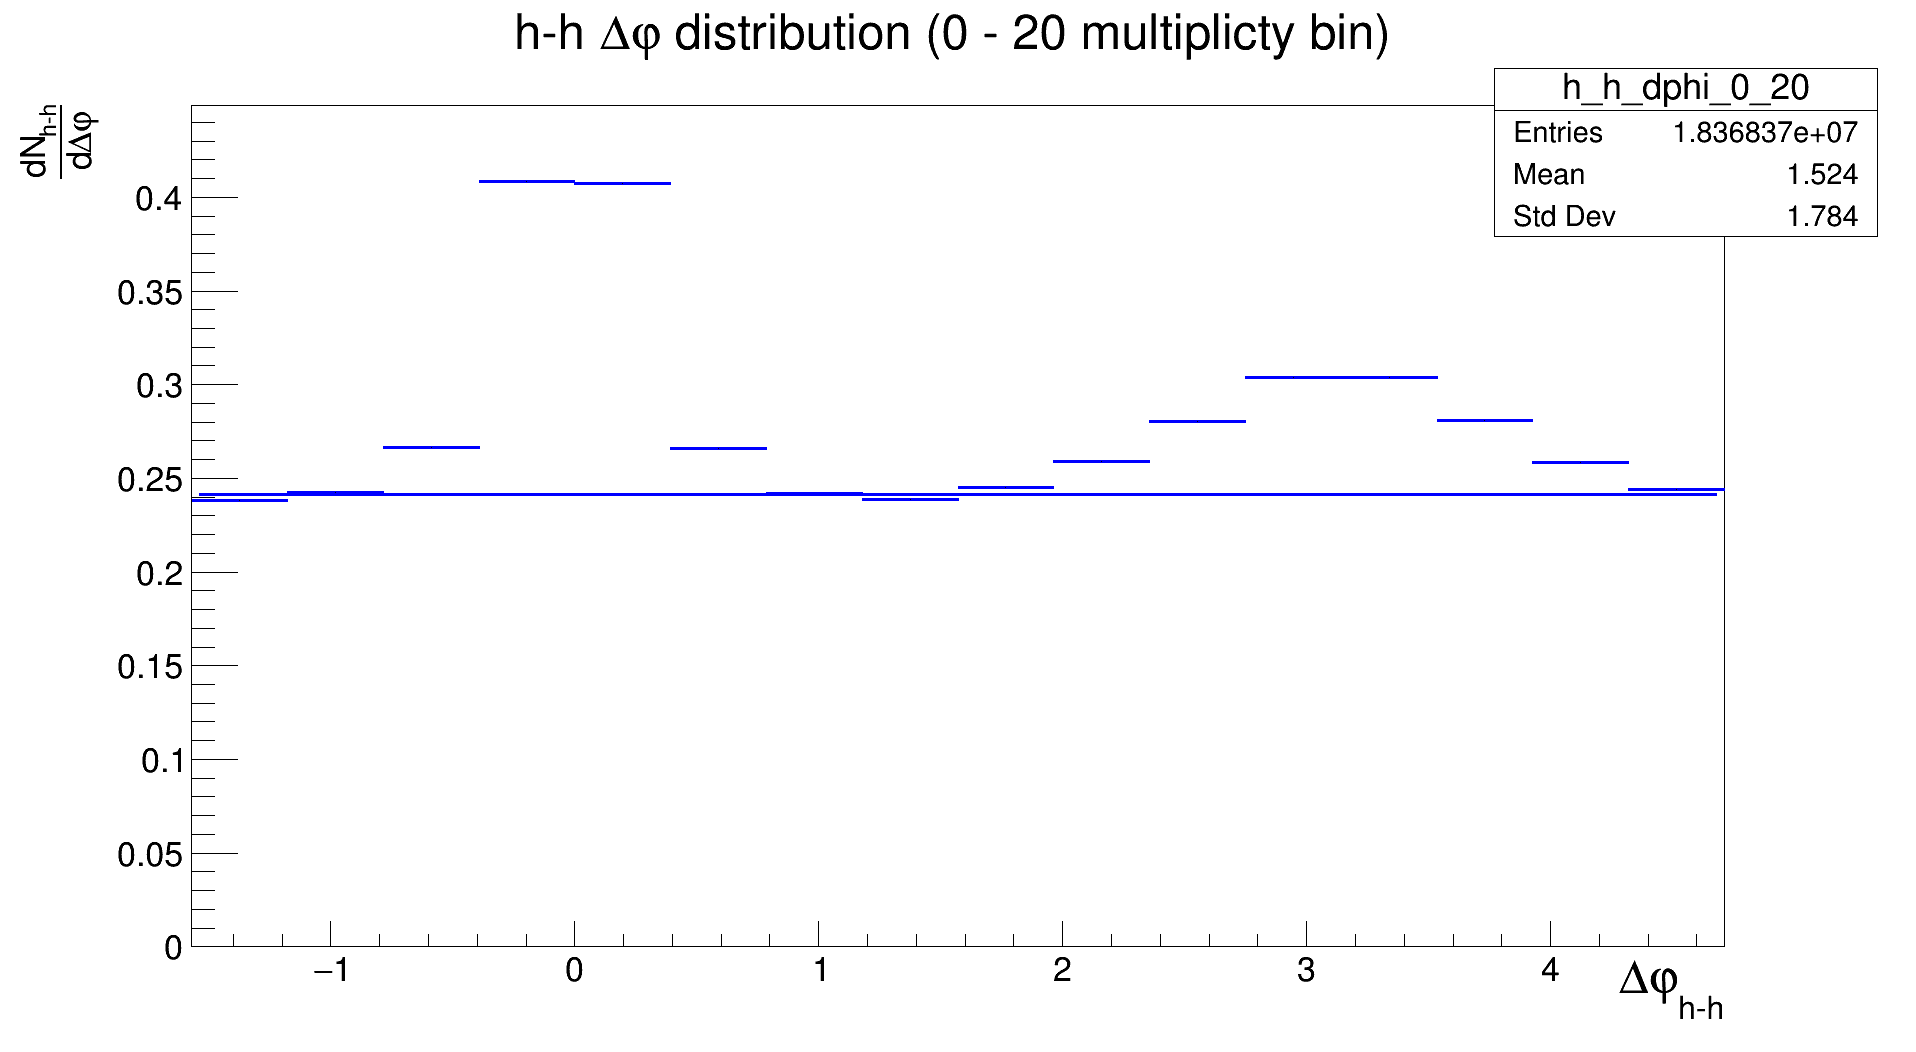

In [66]:
h_h_dphi_0_20.GetYaxis().SetRangeUser(0, h_h_dphi_0_20.GetMaximum()*1.1)
h_h_dphi_0_20.Draw()
hh_ue_line_0_20.Draw("SAME")
hh_ue_upper_line_0_20.Draw("SAME")
hh_ue_lower_line_0_20.Draw("SAME")
c.Draw()

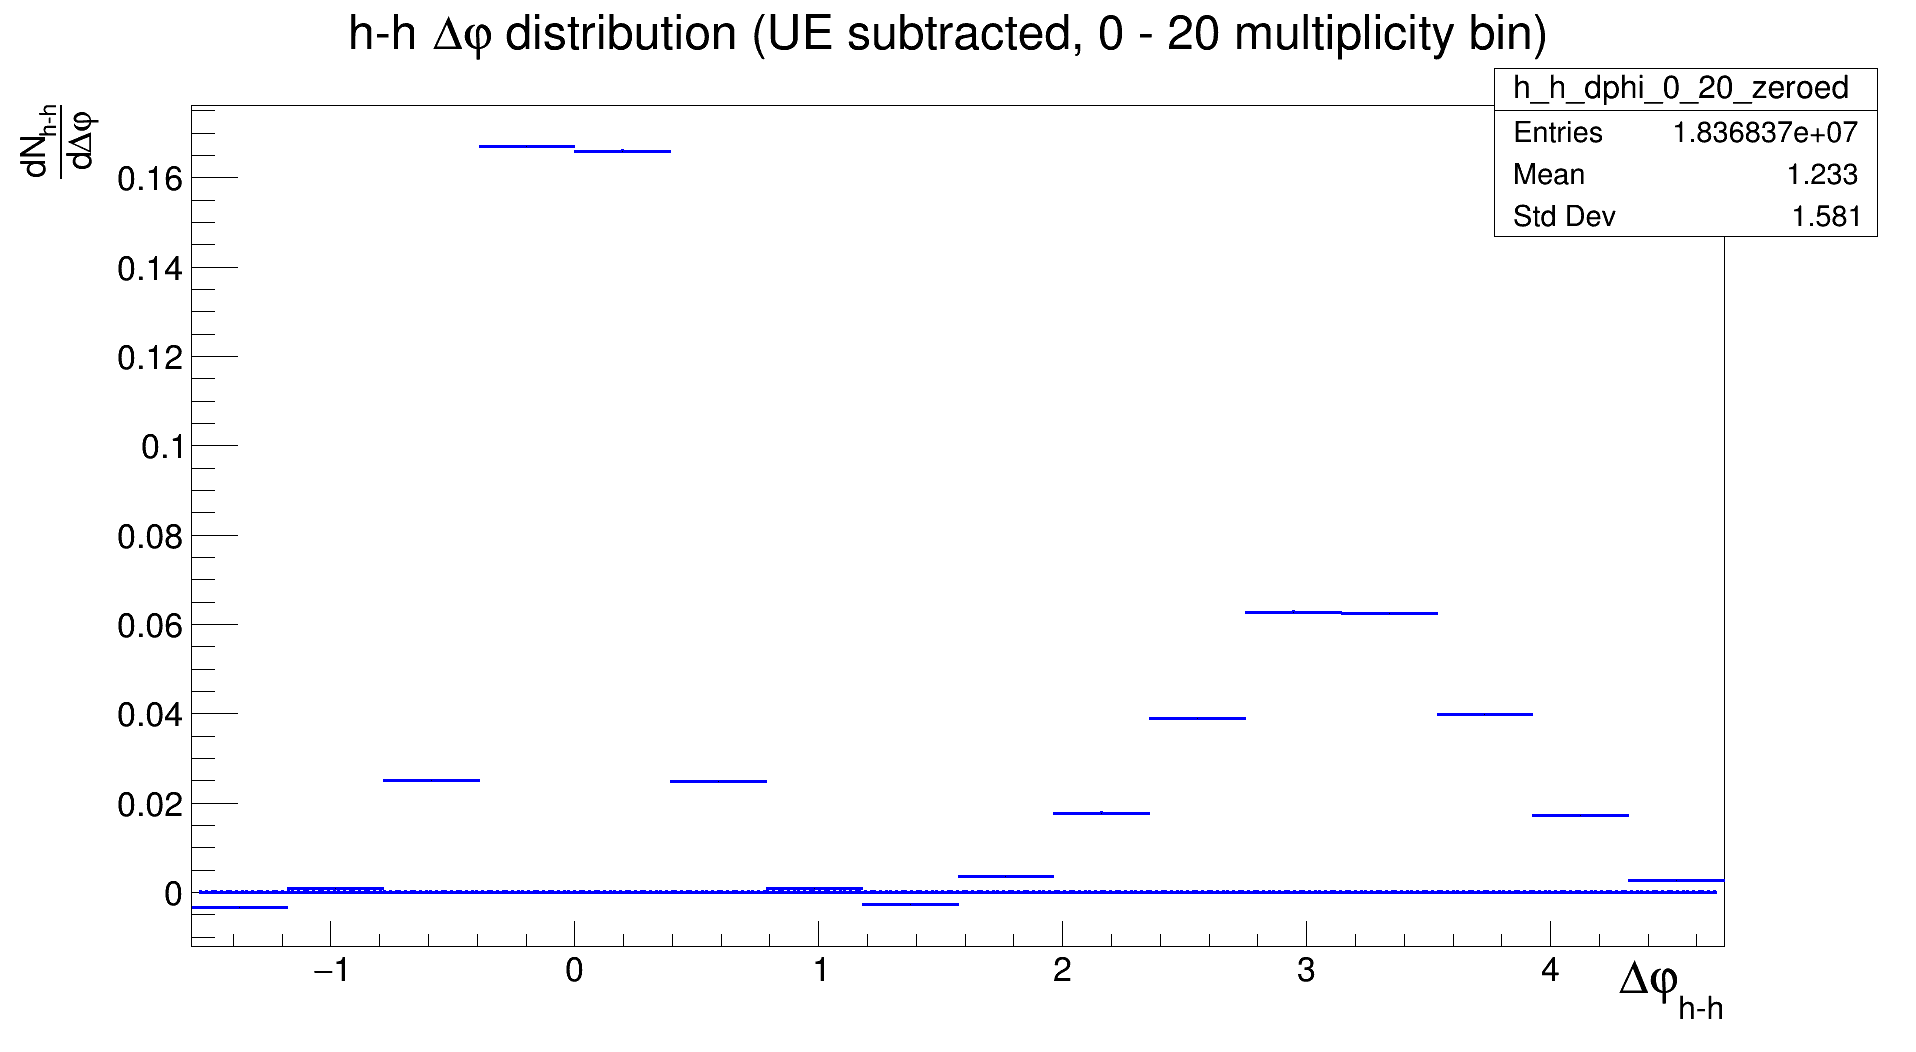

In [67]:
h_h_dphi_0_20_zeroed = h_h_dphi_0_20.Clone("h_h_dphi_0_20_zeroed")
h_h_dphi_0_20_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 0 - 20 multiplicity bin)")
h_h_dphi_0_20_zeroed.Add(hh_ue_line_0_20, -1)
h_h_dphi_0_20_zeroed.Draw()
hh_zero_line_0_20.Draw("SAME")
hh_zero_upper_line_0_20.Draw("SAME")
hh_zero_lower_line_0_20.Draw("SAME")
c.Draw()

In [68]:
h_h_total_integral_0_20 = 0
h_h_near_integral_0_20 = 0
h_h_away_integral_0_20 = 0
h_h_ue_integral_0_20 = hh_ue_avg_0_20*DPHI_BINS

h_h_total_integral_error_0_20 = 0
h_h_near_integral_error_0_20 = 0
h_h_away_integral_error_0_20 = 0
h_h_ue_integral_error_0_20 = hh_ue_avg_error_0_20*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_0_20 += h_h_dphi_0_20.GetBinContent(bin_num)
    h_h_total_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
    if bin_num < 9:
        h_h_near_integral_0_20 += (h_h_dphi_0_20.GetBinContent(bin_num) - hh_ue_avg_0_20)
        h_h_near_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_near_integral_error_0_20 += hh_ue_avg_error_0_20**2
    else:
        h_h_away_integral_0_20 += (h_h_dphi_0_20.GetBinContent(bin_num) - hh_ue_avg_0_20)
        h_h_away_integral_error_0_20 += h_h_dphi_0_20.GetBinError(bin_num)**2
        h_h_away_integral_error_0_20 += hh_ue_avg_error_0_20**2
h_h_total_integral_error_0_20 = math.sqrt(h_h_total_integral_error_0_20)
h_h_near_integral_error_0_20 = math.sqrt(h_h_near_integral_error_0_20)
h_h_away_integral_error_0_20 = math.sqrt(h_h_away_integral_error_0_20)

In [69]:
near_ratio_0_20 = h_lambda_near_integral_0_20/h_h_near_integral_0_20
away_ratio_0_20 = h_lambda_away_integral_0_20/h_h_away_integral_0_20
ue_ratio_0_20 = h_lambda_ue_integral_0_20/h_h_ue_integral_0_20
total_ratio_0_20 = h_lambda_total_integral_0_20/h_h_total_integral_0_20

near_ratio_error_0_20 = near_ratio_0_20*math.sqrt((h_lambda_near_integral_error_0_20/h_lambda_near_integral_0_20)**2
                                                 + (h_h_near_integral_error_0_20/h_h_near_integral_0_20)**2)
away_ratio_error_0_20 = away_ratio_0_20*math.sqrt((h_lambda_away_integral_error_0_20/h_lambda_away_integral_0_20)**2
                                                 + (h_h_away_integral_error_0_20/h_h_away_integral_0_20)**2)
ue_ratio_error_0_20 = ue_ratio_0_20*math.sqrt((h_lambda_ue_integral_error_0_20/h_lambda_ue_integral_0_20)**2
                                                 + (h_h_ue_integral_error_0_20/h_h_ue_integral_0_20)**2)
total_ratio_error_0_20 = total_ratio_0_20*math.sqrt((h_lambda_total_integral_error_0_20/h_lambda_total_integral_0_20)**2
                                                 + (h_h_total_integral_error_0_20/h_h_total_integral_0_20)**2)

# 20 - 50 setup

In [70]:
input_file_20_50 = rt.TFile("../online/output/cent_20_50.root")
input_list_20_50 = input_file_20_50.Get("h-lambda")
input_file_20_50.Close()

In [71]:
trig_dist_20_50 = input_list_20_50.FindObject("fTriggerDist")
lambda_dist_20_50 = input_list_20_50.FindObject("fTriggeredLambdaDist")

In [72]:
h_h_20_50 = input_list_20_50.FindObject("fDphiHHEff")
h_h_mixed_20_50 = input_list_20_50.FindObject("fDphiHHMixed")

In [73]:
h_lambda_20_50 = input_list_20_50.FindObject("fDphiHLambdaEff")
h_lambda_ls_20_50 = input_list_20_50.FindObject("fDphiHLambdaLS")
h_lambda_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_20_50 = input_list_20_50.FindObject("fDphiHLambdaLSMixed")

In [74]:
# Setting the trigger Pt (this is never changed again)
trig_dist_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [75]:
# Setting the associated Pt (this is never changed again)
lambda_dist_20_50.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_20_50.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [76]:
trig_pt_dist_20_50 = trig_dist_20_50.Projection(0).Clone("trig_pt_dist_20_50")
trig_phi_dist_20_50 = trig_dist_20_50.Projection(1).Clone("trig_phi_dist_20_50")
trig_eta_dist_20_50 = trig_dist_20_50.Projection(2).Clone("trig_eta_dist_20_50")
trig_2d_dist_20_50 = trig_dist_20_50.Projection(0, 3).Clone("trig_2d_dist_20_50")

trig_pt_dist_20_50.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_20_50.Sumw2()
trig_pt_dist_20_50.SetLineColor(rt.kRed)

trig_phi_dist_20_50.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_20_50.Sumw2()
trig_phi_dist_20_50.SetLineColor(rt.kRed)

trig_eta_dist_20_50.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_20_50.Sumw2()
trig_eta_dist_20_50.SetLineColor(rt.kRed)

Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_1 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_2 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fTriggerDist_proj_3_0 (Potential memory leak).


In [77]:
num_trigs_20_50 = trig_2d_dist_20_50.Integral()

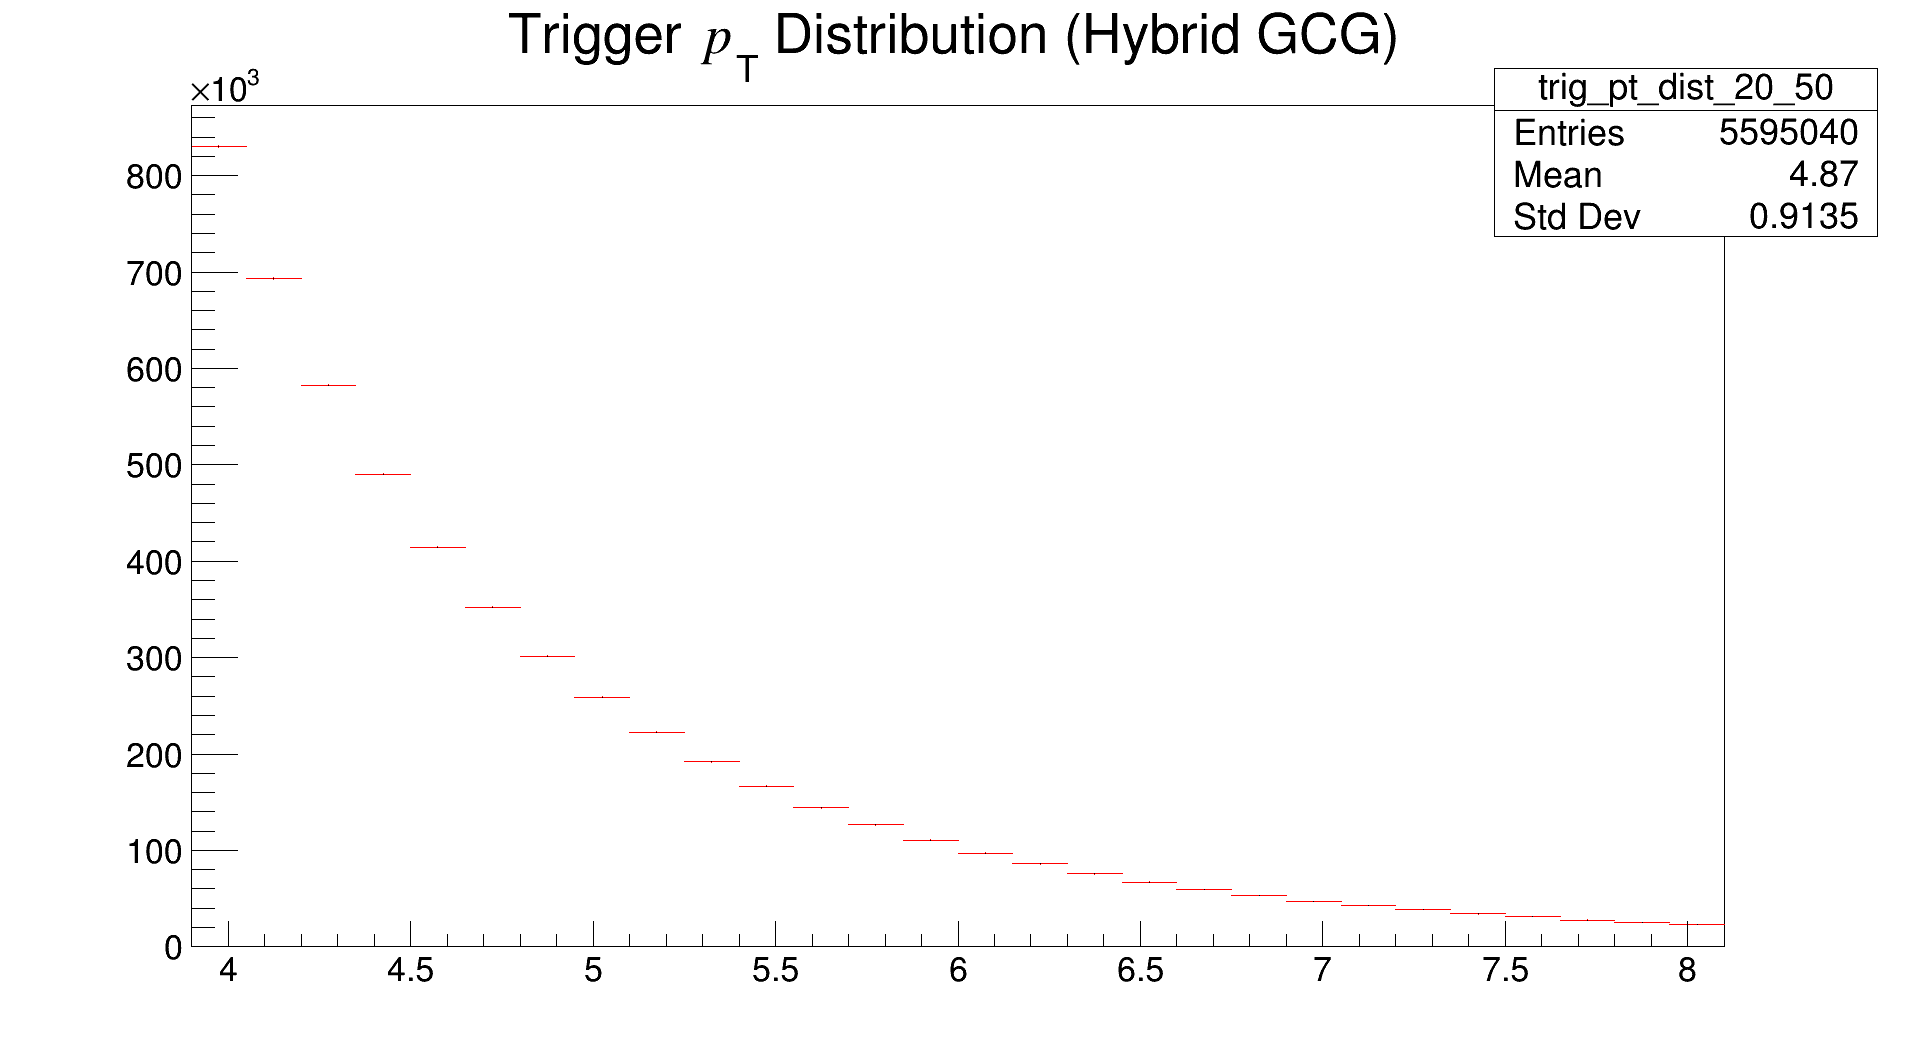

In [78]:
trig_pt_dist_20_50.Draw()
c.Draw()

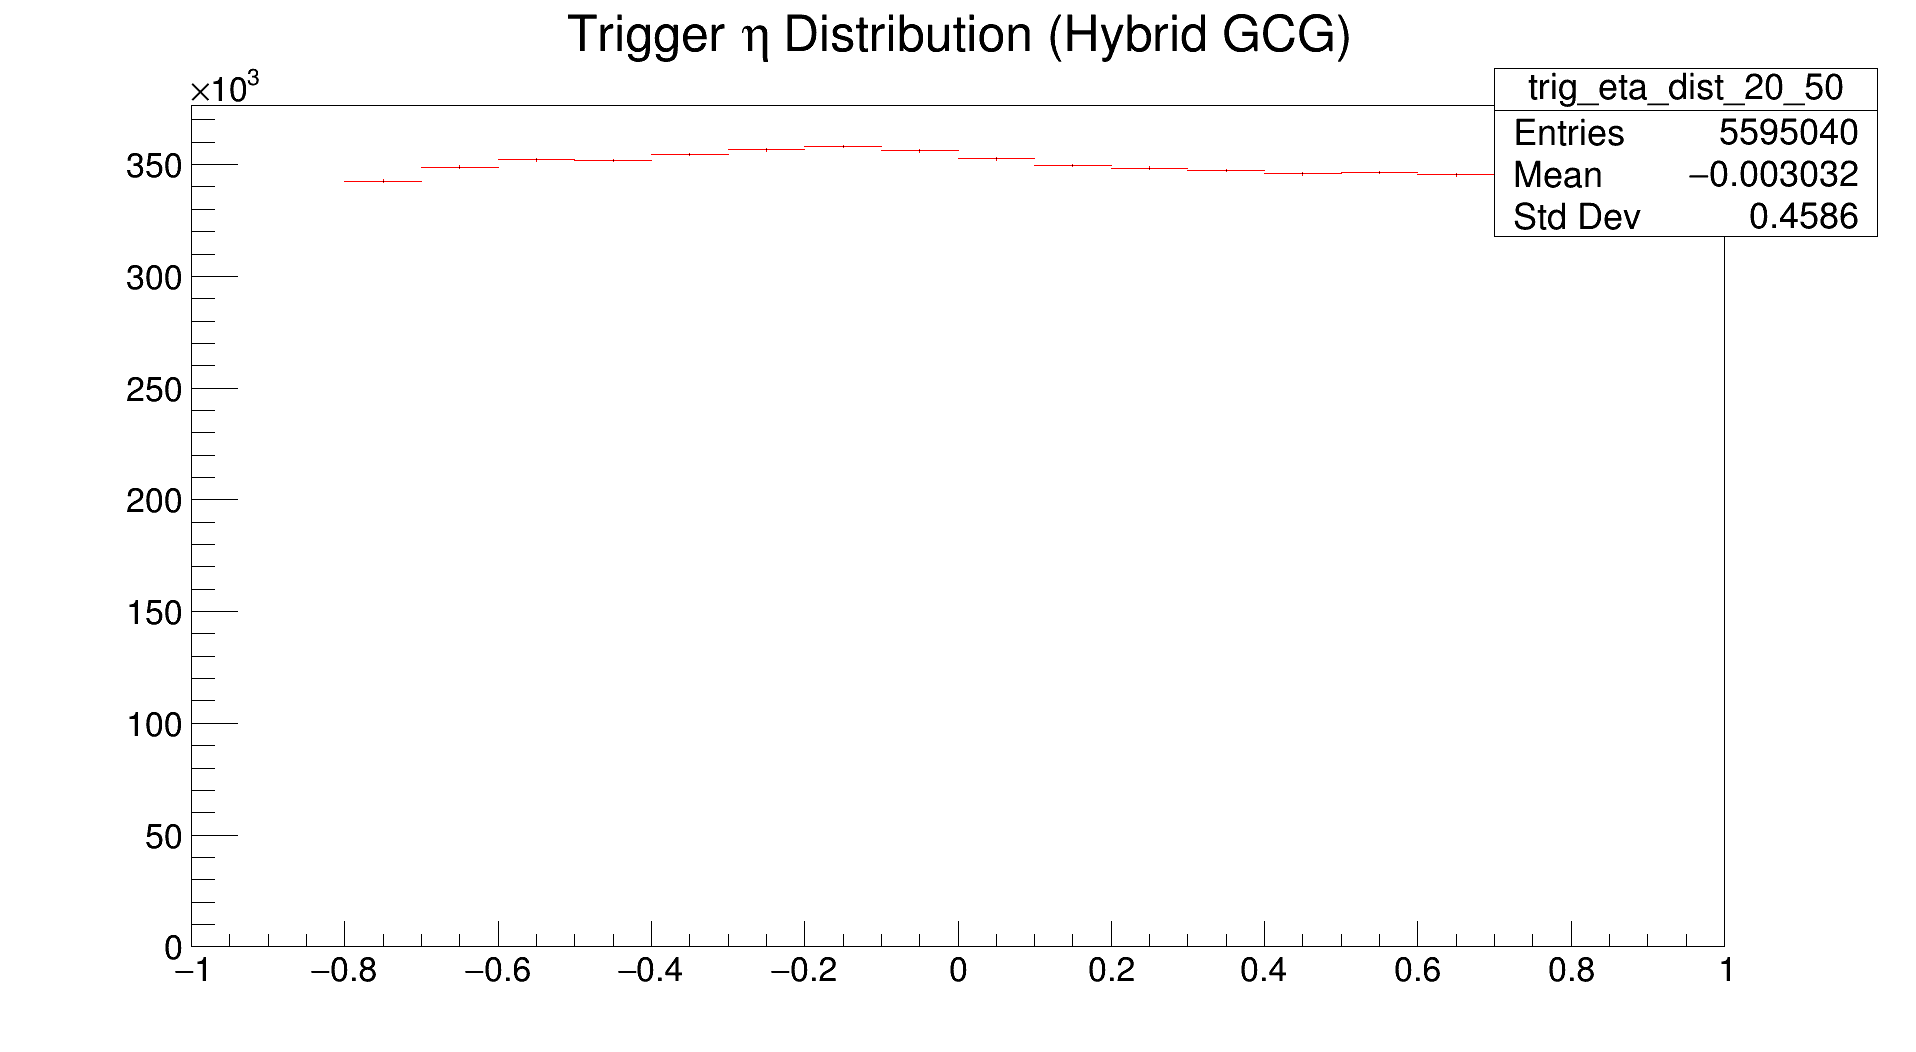

In [79]:
trig_eta_dist_20_50.Draw()
c.Draw()

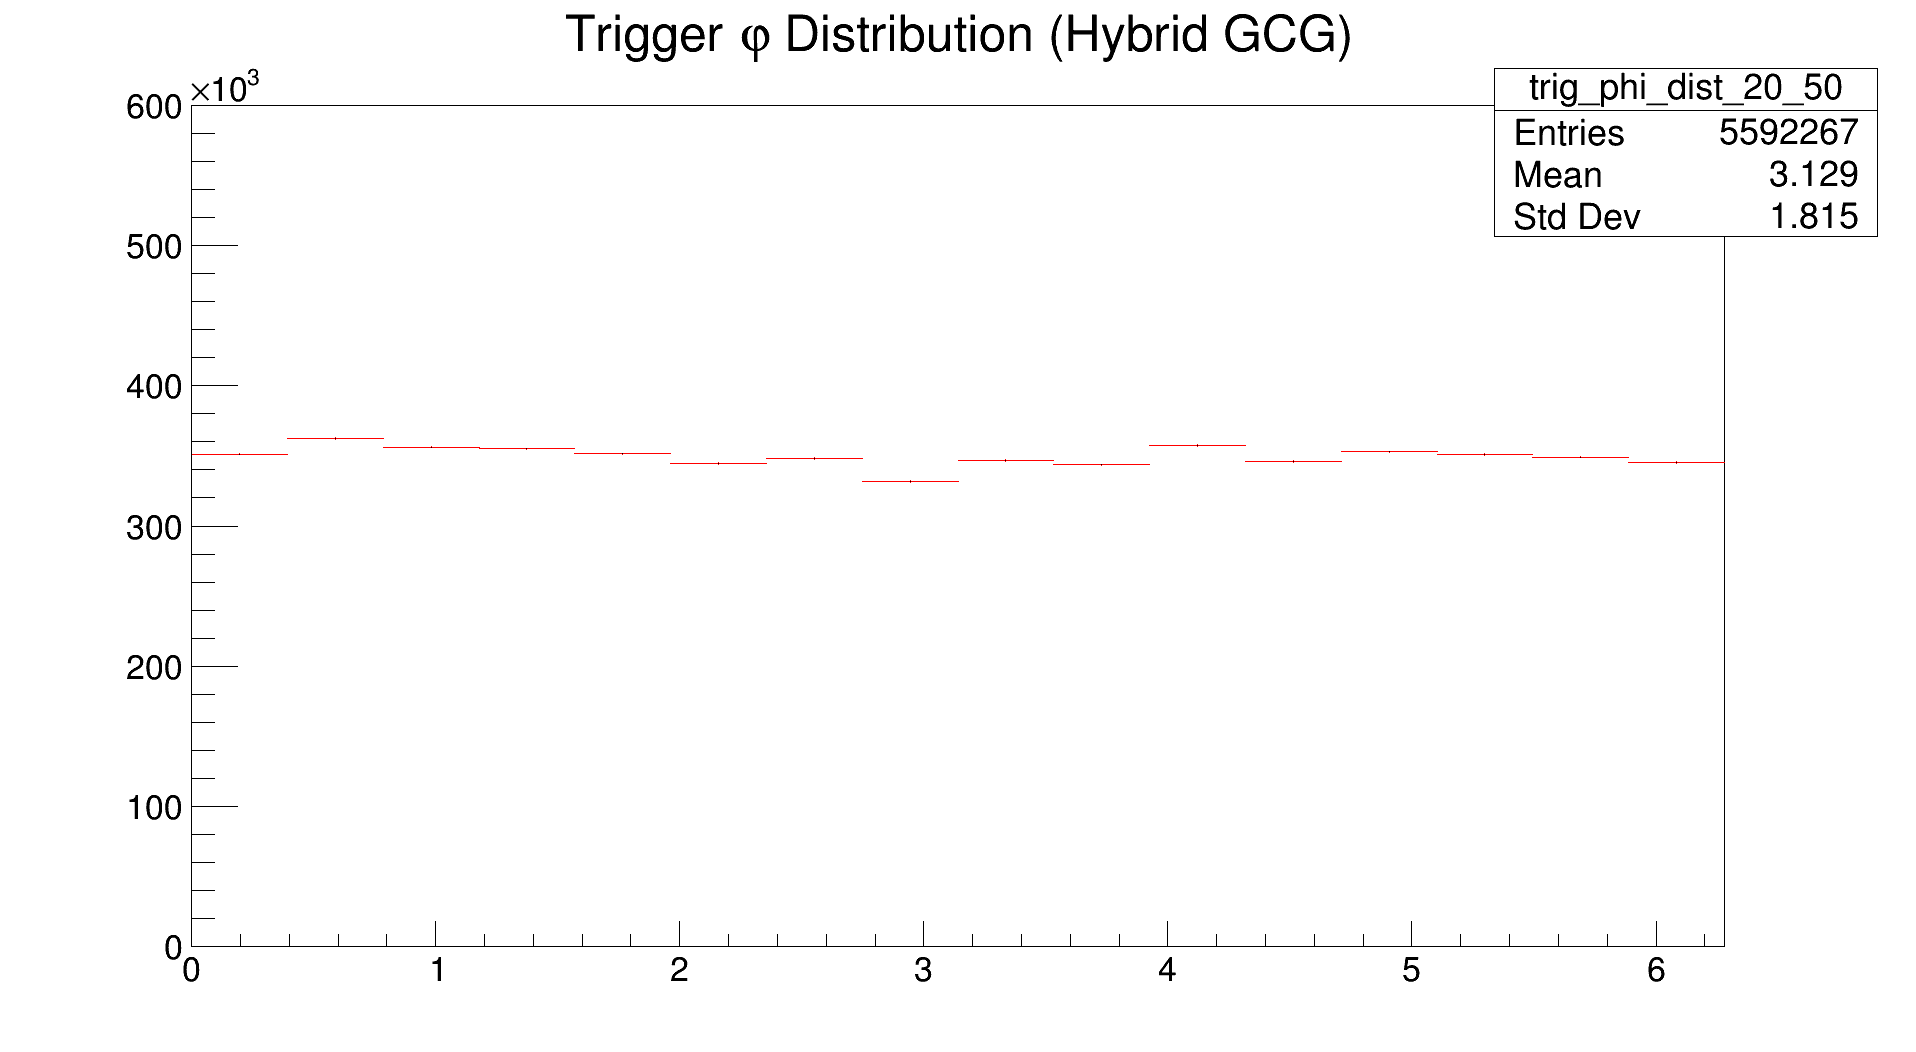

In [80]:
trig_phi_dist_20_50.GetYaxis().SetRangeUser(0, 600e3)
trig_phi_dist_20_50.Draw()
c.Draw()

### Signal analysis section

In [81]:
# eta cuts first
lambda_dist_20_50.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_20_50 = lambda_dist_20_50.Projection(3).Clone("lambda_mass_dist_20_50")

Warning in <TROOT::Append>: Replacing existing TH1: fTriggeredLambdaDist_proj_3 (Potential memory leak).


In [82]:
lambda_mass_dist_20_50.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_20_50.Sumw2()
lambda_mass_dist_20_50.SetLineWidth(2)
lambda_mass_dist_20_50.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_20_50.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

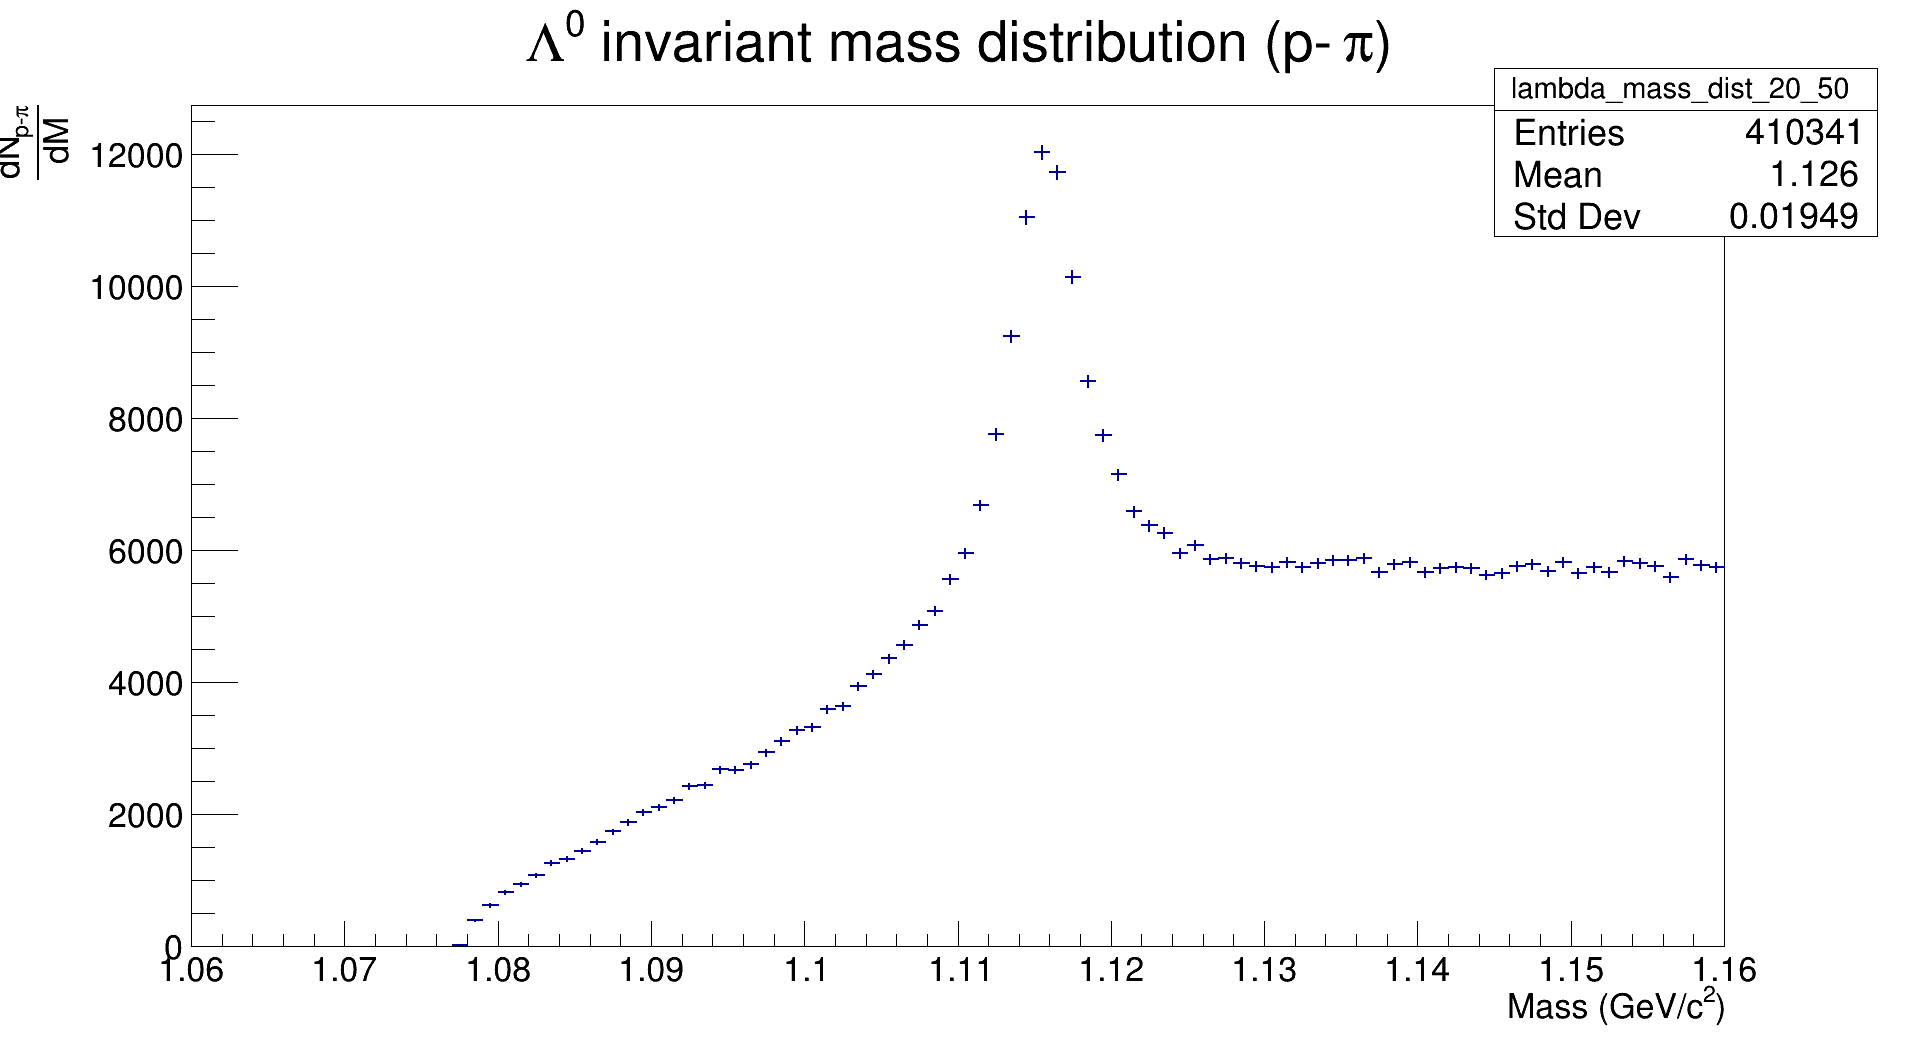

In [83]:
lambda_mass_dist_20_50.Draw()
c.Draw()

In [84]:
bin_1 = lambda_mass_dist_20_50.FindBin(1.09)
bin_2 = lambda_mass_dist_20_50.FindBin(1.15)
bin_3 = lambda_mass_dist_20_50.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_20_50.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_20_50.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_20_50.GetBinContent(bin_3)]
bg_starting_params_20_50 = get_parabola(point_one, point_two, point_three)

In [85]:
lambda_mass_fit_20_50 = rt.TF1("lambda_mass_fit_20_50", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_20_50.SetNpx(1000)
lambda_mass_fit_20_50.SetParameter(0, 1.36753e01)
lambda_mass_fit_20_50.FixParameter(1, 1.11581)
lambda_mass_fit_20_50.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_20_50.SetParameter(3, 6.04166e-03)
lambda_mass_fit_20_50.SetParameter(4, bg_starting_params_20_50[0])
lambda_mass_fit_20_50.SetParameter(5, bg_starting_params_20_50[1])
lambda_mass_fit_20_50.SetParameter(6, bg_starting_params_20_50[2])

 FCN=128.541 FROM MIGRAD    STATUS=FAILED        637 CALLS         638 TOTAL
                     EDM=22691.6    STRATEGY= 1      ERR MATRIX NOT POS-DEF
  EXT PARAMETER                APPROXIMATE        STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           6.88854e+01   1.30872e+00  -0.00000e+00  -2.14571e+00
   2  p1           1.11581e+00     fixed    
   3  p2           4.02546e-06   5.64283e-09   0.00000e+00  -2.53561e+09
   4  p3           5.83864e-03   1.22428e-04  -0.00000e+00  -3.34040e+04
   5  p4          -1.62108e+06   5.97114e+04  -0.00000e+00   1.93447e-01
   6  p5           2.83988e+06   1.06752e+05   0.00000e+00   2.14812e-01
   7  p6          -1.23936e+06   4.76865e+04  -0.00000e+00   2.38767e-01


Warning in <Fit>: Abnormal termination of minimization.


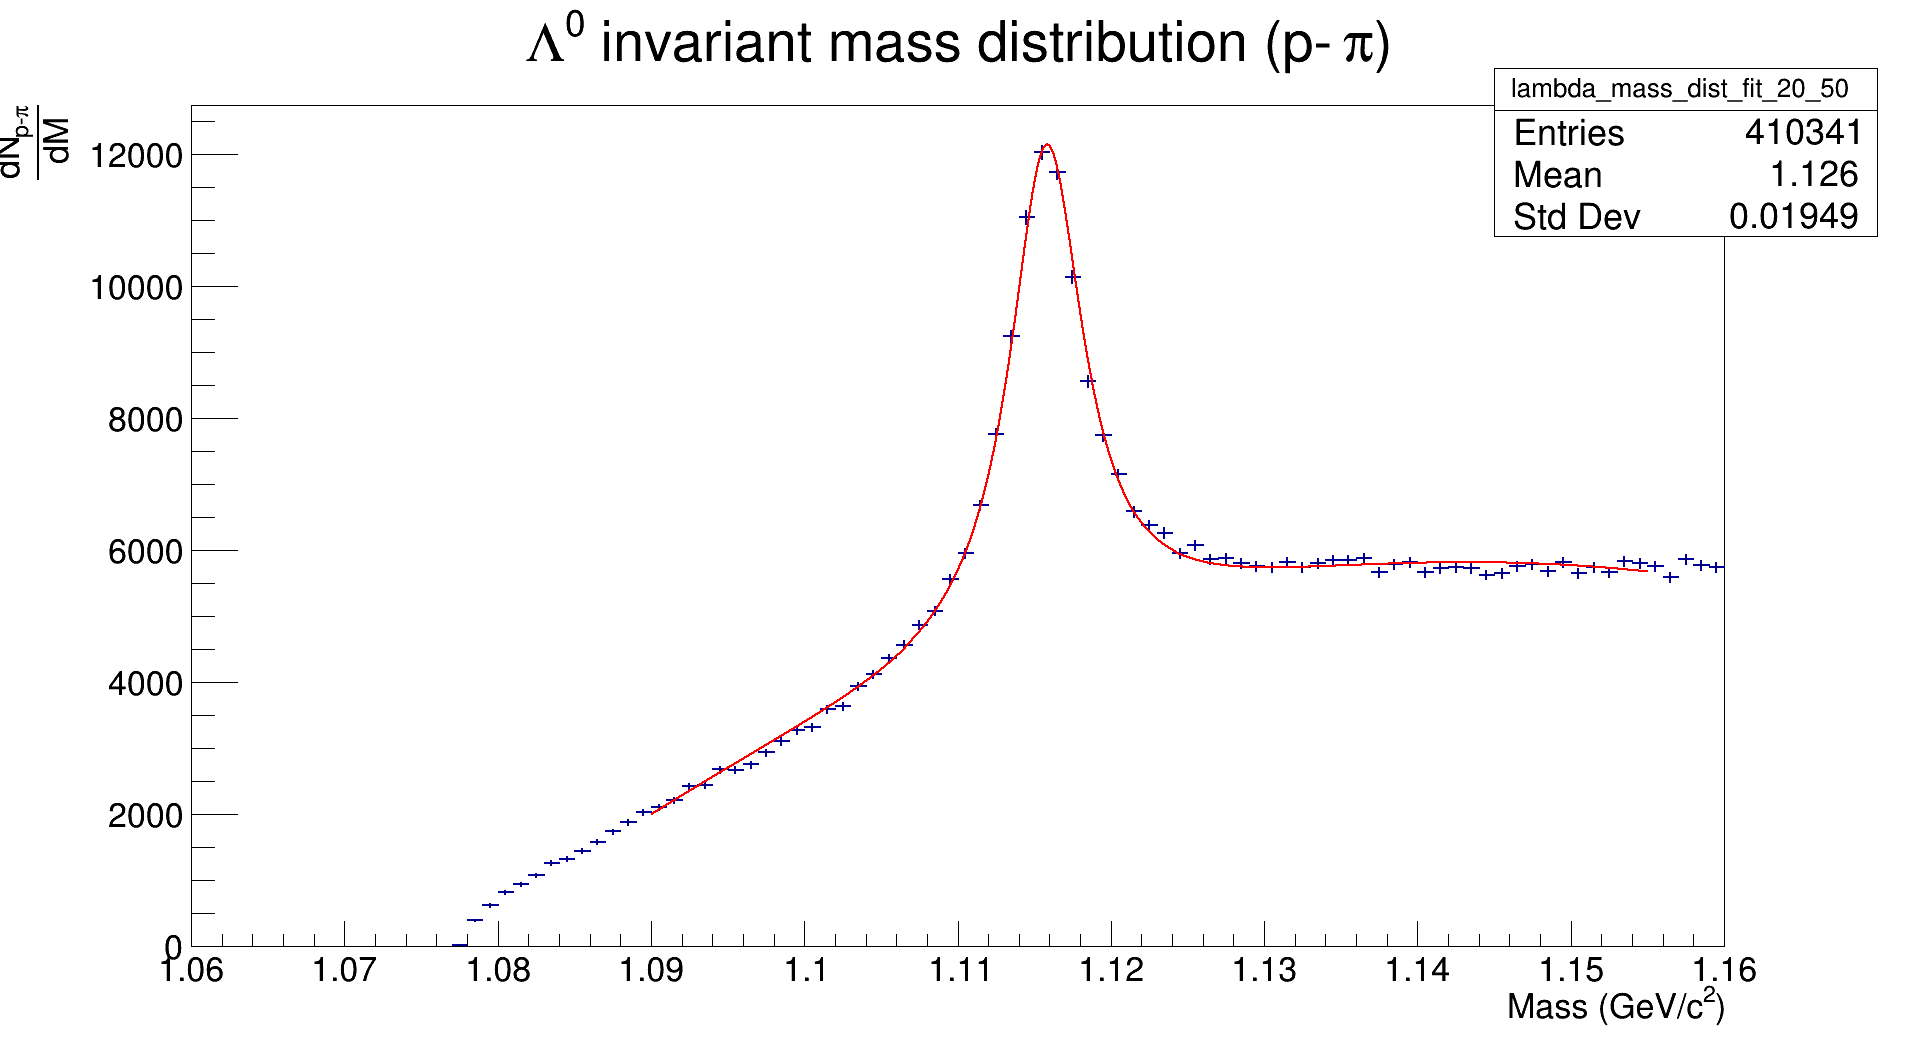

In [86]:
lambda_mass_dist_fit_20_50 = lambda_mass_dist_20_50.Clone("lambda_mass_dist_fit_20_50")
lambda_mass_dist_fit_20_50.Fit(lambda_mass_fit_20_50, "RS")
lambda_mass_dist_fit_20_50.Draw()
c.Draw()

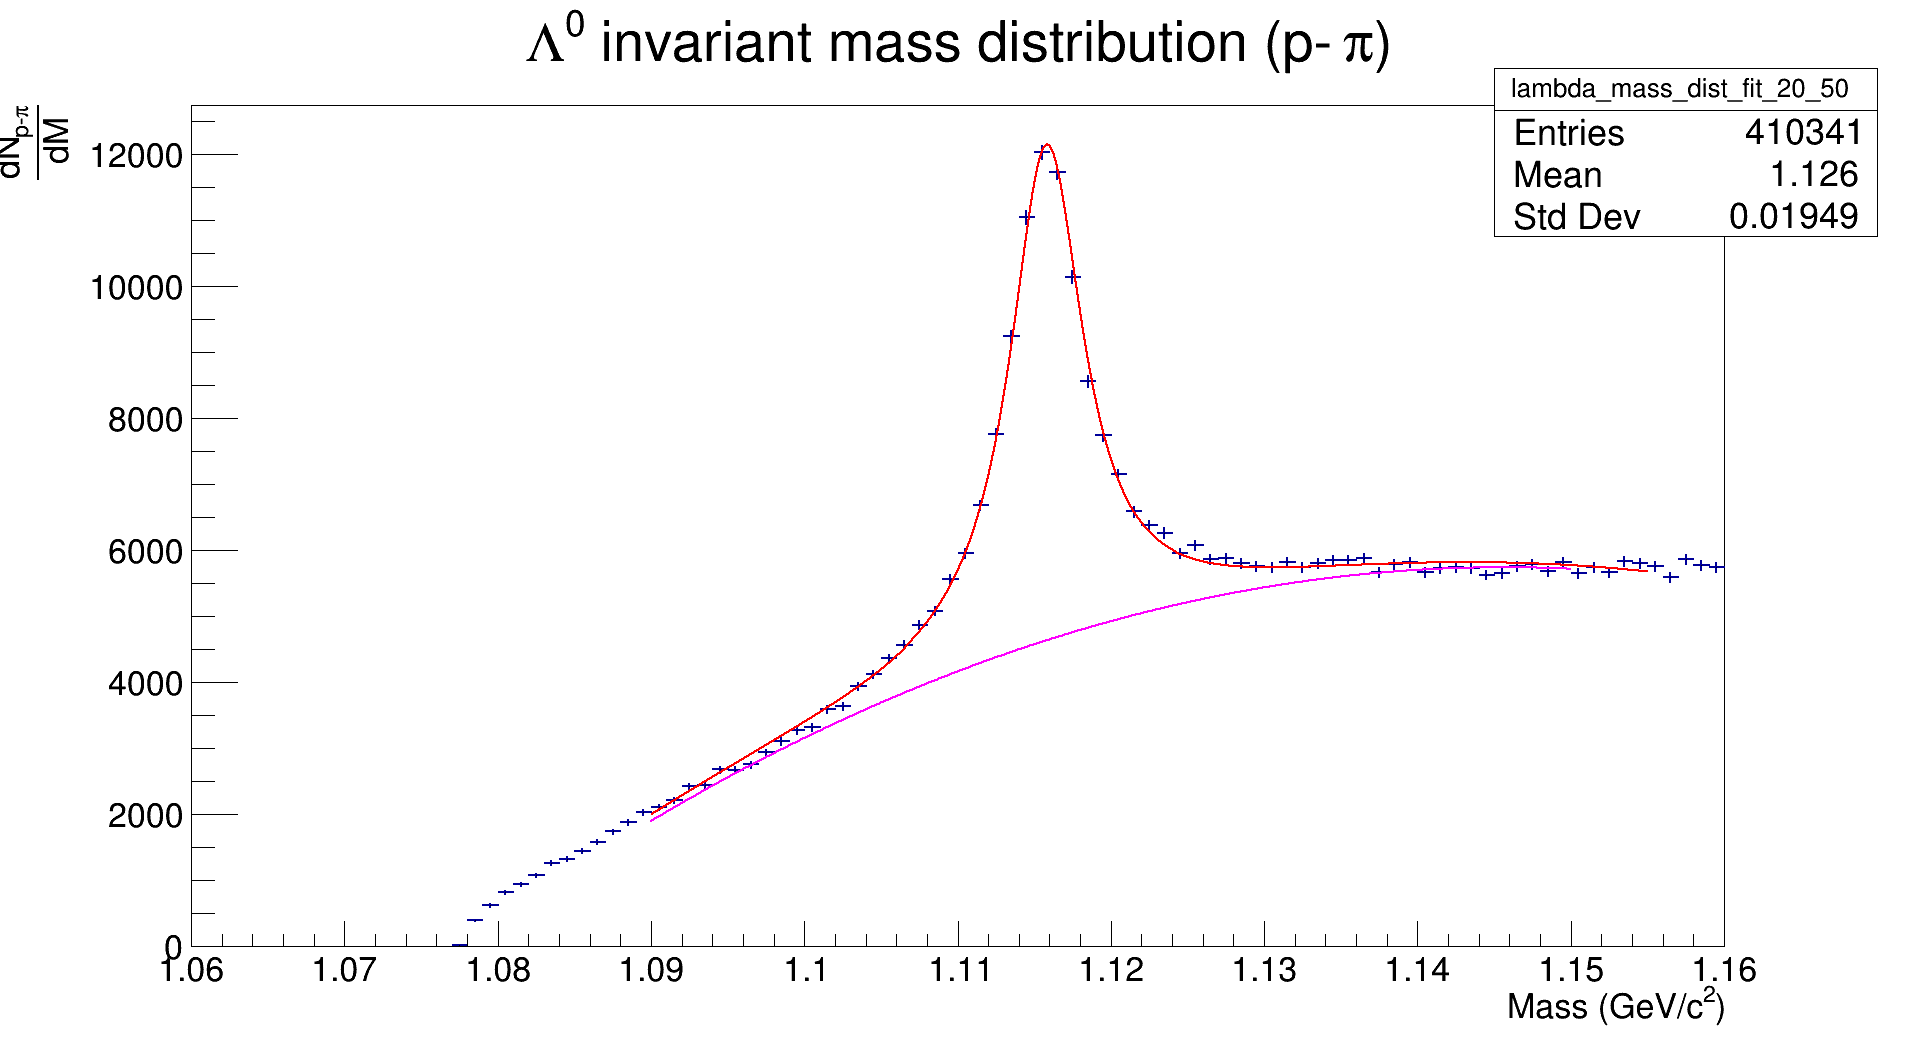

In [87]:
bg_fit_20_50 = rt.TF1("bg_fit_20_50", "pol2", 1.09, 1.15)
bg_fit_20_50.SetParameter(0, lambda_mass_fit_20_50.GetParameter(4))
bg_fit_20_50.SetParameter(1, lambda_mass_fit_20_50.GetParameter(5))
bg_fit_20_50.SetParameter(2, lambda_mass_fit_20_50.GetParameter(6))
bg_fit_20_50.SetNpx(1000)
bg_fit_20_50.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_20_50.Draw()
bg_fit_20_50.Draw("SAME")
c.Draw()

In [88]:
left_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MIN)
right_signal_bin_20_50 = lambda_mass_dist_fit_20_50.FindBin(SIG_MAX)

lambda_bg_20_50 = 0
lambda_total_20_50 = 0
for bin_num in range(left_signal_bin_20_50, right_signal_bin_20_50 + 1):
    bin_center = lambda_mass_dist_fit_20_50.GetBinCenter(bin_num)
    lambda_bg_20_50 += bg_fit_20_50.Eval(bin_center)
    lambda_total_20_50 += lambda_mass_dist_fit_20_50.GetBinContent(bin_num)

lambda_signal_20_50 = lambda_total_20_50 - lambda_bg_20_50
lambda_signal_total_ratio_20_50 = lambda_signal_20_50/lambda_total_20_50
lambda_signal_bg_ratio_20_50 = lambda_signal_20_50/lambda_bg_20_50
print(f"The 0-20 lambda signal is: {lambda_signal_20_50}")
print(f"The 0-20 lambda background is: {lambda_bg_20_50}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_20_50}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_20_50}")
print(f"The 0-20 lambda significance is: {lambda_signal_20_50/math.sqrt(lambda_signal_20_50 + lambda_bg_20_50)}")

The 0-20 lambda signal is: 53975.00241239951
The 0-20 lambda background is: 74005.99758760049
The 0-20 lambda S/B is: 0.72933281317517
The 0-20 lambda S/T is: 0.4217423087208219
The 0-20 lambda significance is: 150.87591633729122


### Mixed event correction section

In [89]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_20_50 = h_lambda_20_50.Projection(4, axes)
h_lambda_ls_20_50 = h_lambda_ls_20_50.Projection(4, axes)
h_lambda_mixed_20_50 = h_lambda_mixed_20_50.Projection(4, axes)
h_lambda_ls_mixed_20_50 = h_lambda_ls_mixed_20_50.Projection(4, axes)

In [90]:
h_h_20_50 = h_h_20_50.Projection(2, 3, 4)
h_h_mixed_20_50 = h_h_mixed_20_50.Projection(2, 3, 4)
h_h_20_50.Sumw2()
h_h_mixed_20_50.Sumw2()

Warning in <TROOT::Append>: Replacing existing TH1: fDphiHHEff_proj_2_3_4 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHHMixed_proj_2_3_4 (Potential memory leak).


In [91]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_20_50 = h_lambda_20_50.Projection(0, 1).Clone("h_lambda_2d_nomixcor_20_50")
h_lambda_ls_2d_nomixcor_20_50 = h_lambda_ls_20_50.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_20_50")
h_lambda_mixed_2d_20_50 = h_lambda_mixed_20_50.Projection(0, 1).Clone("h_lambda_mixed_2d_20_50")

Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_1_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLS_proj_2_3_4_5_proj_1_0 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_1_0 (Potential memory leak).


In [92]:
h_h_2d_nomixcor_20_50 = h_h_20_50.Project3D("xye").Clone("h_h_2d_nomixcor_20_50")
h_h_mixed_2d_20_50 = h_h_mixed_20_50.Project3D("xye").Clone("h_h_mixed_2d_20_50")

In [93]:
h_lambda_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_20_50.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

In [94]:
h_h_2d_nomixcor_20_50.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_20_50.GetYaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_20_50.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_20_50.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_20_50.GetYaxis().SetTitleOffset(1.3)

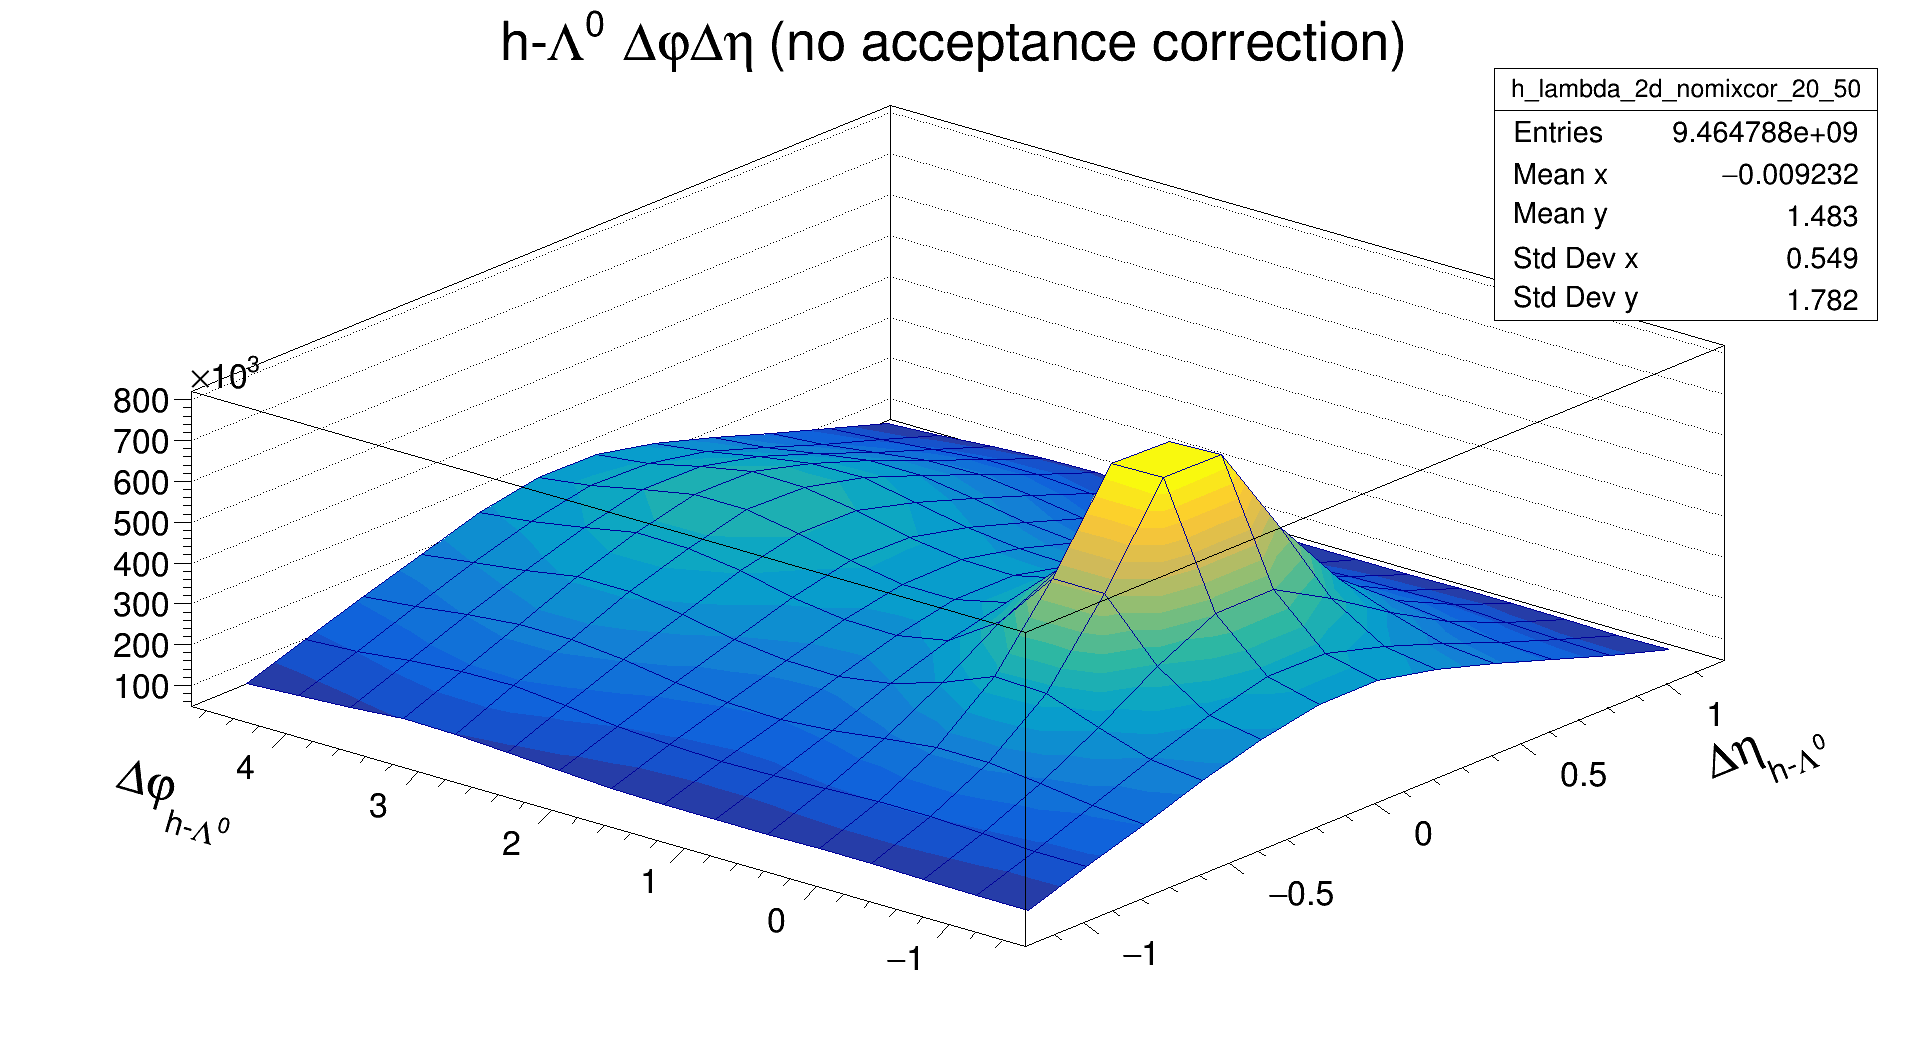

In [95]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

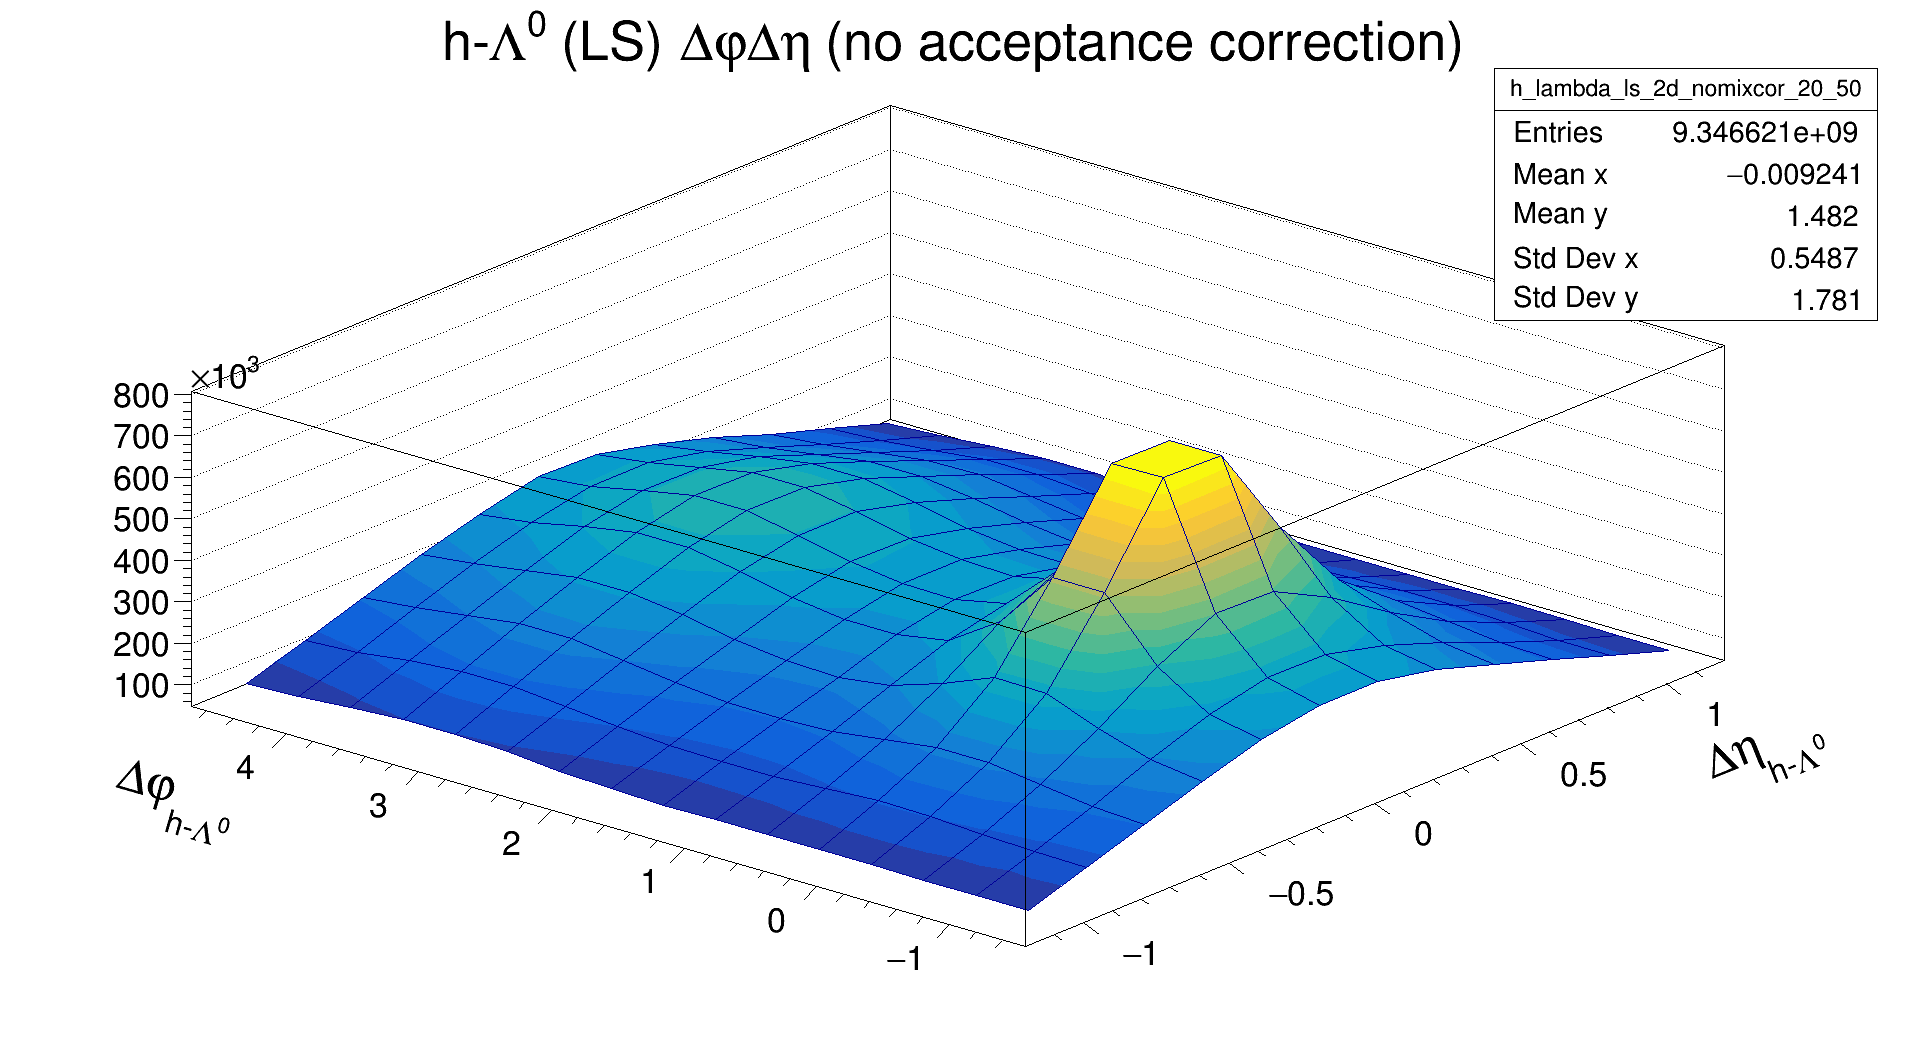

In [96]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_ls_2d_nomixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_ls_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

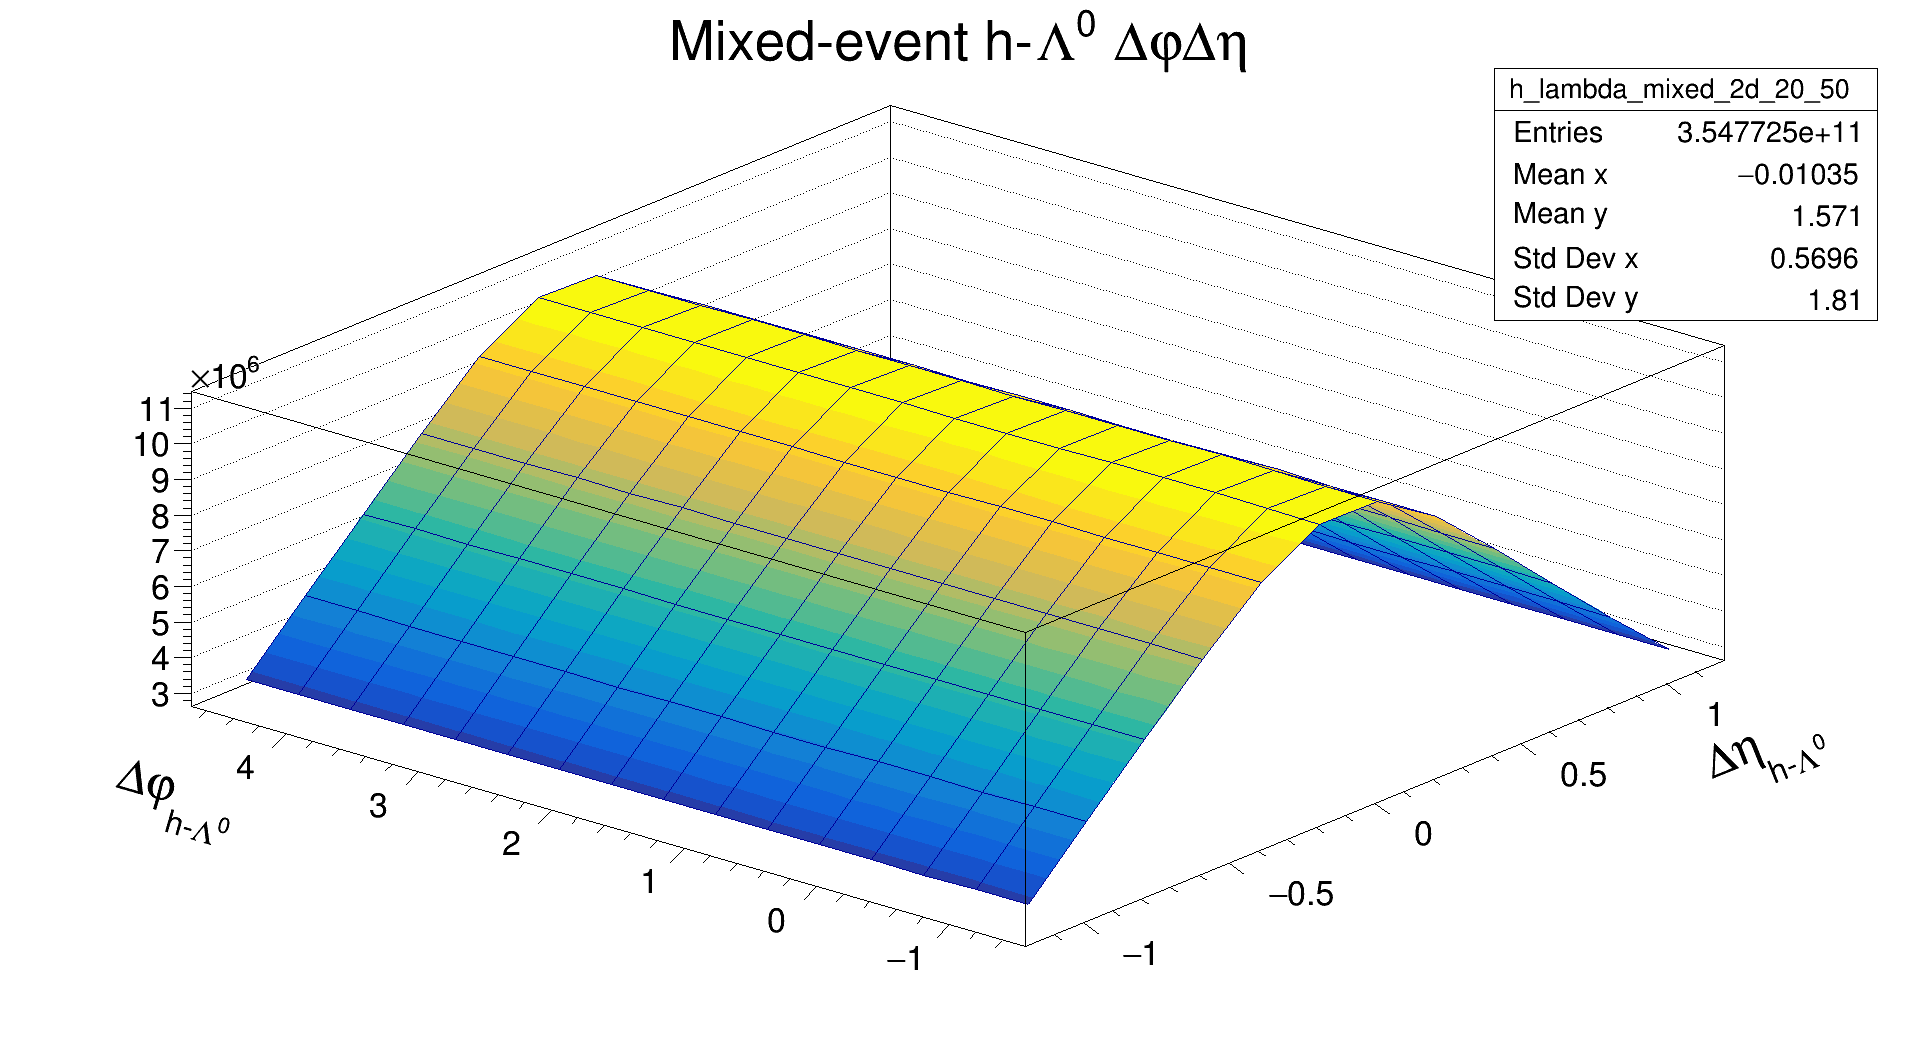

In [97]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_20_50.Draw("SURF1")
c.Draw()

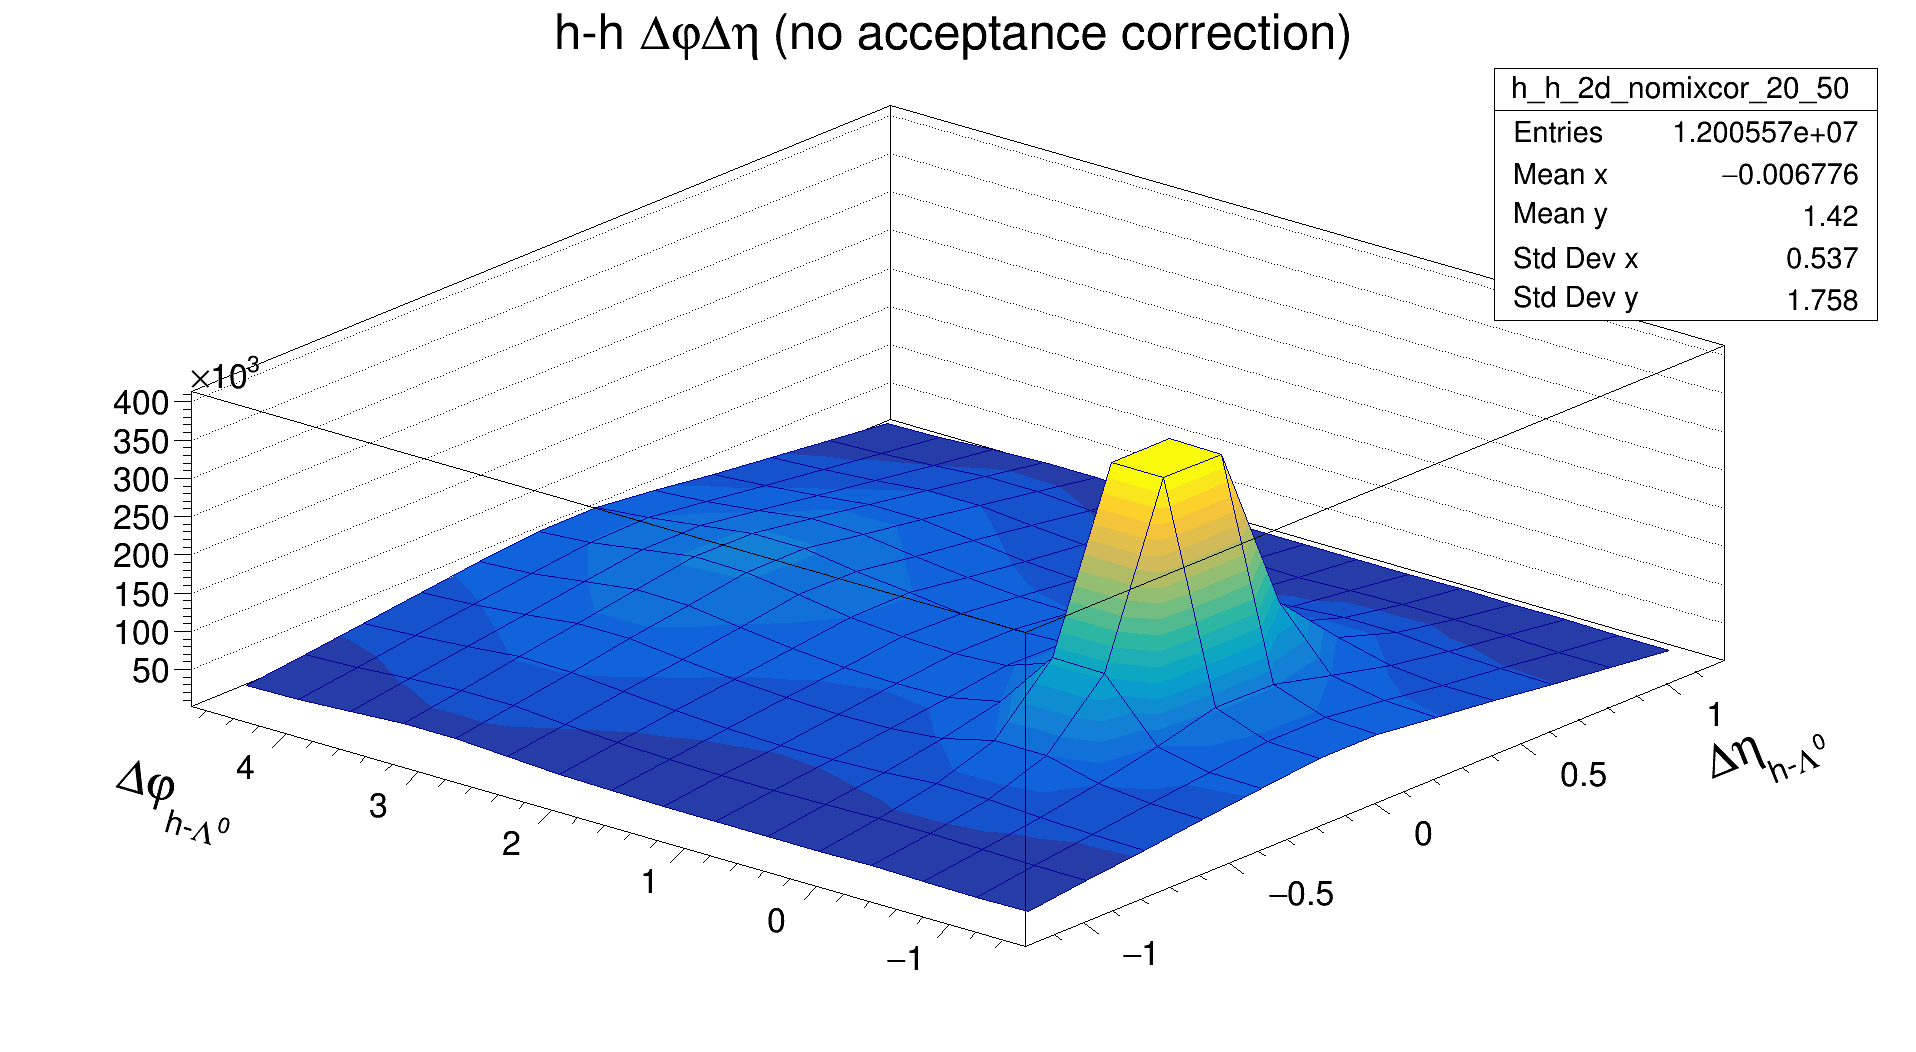

In [98]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_20_50.Draw("SURF1")
c.Draw()

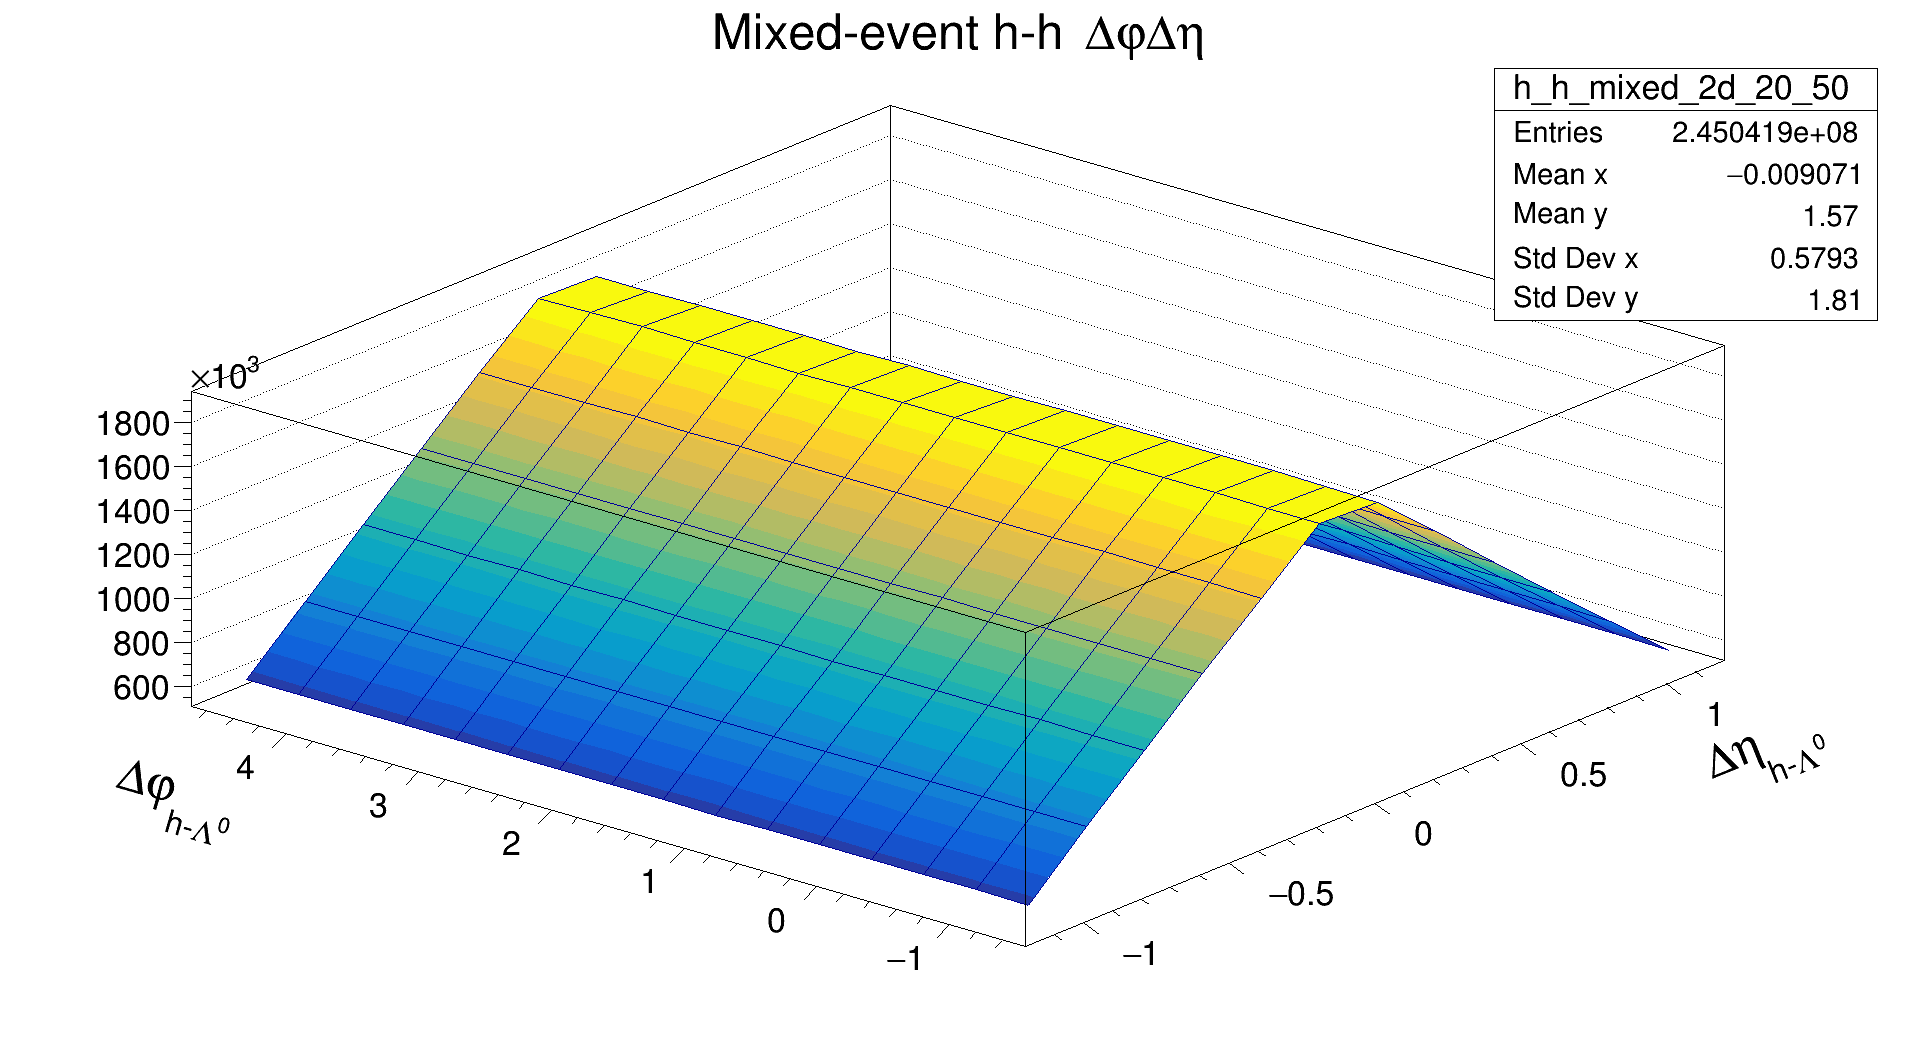

In [99]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_20_50.Draw("SURF1")
c.Draw()

In [100]:
h_lambda_2d_mixcor_lsb_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_20_50 = make_mixed_corrections(h_lambda_20_50, h_lambda_mixed_20_50, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_20_50 = make_mixed_corrections(h_lambda_ls_20_50, h_lambda_ls_mixed_20_50, RSB_MIN, RSB_MAX)

Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaEff_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLS_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDphiHLambdaLSMixed_proj_2_3_4_5_proj_0_1_3 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: fDp

In [101]:
h_h_2d_mixcor_20_50 = make_mixed_corrections(h_h_20_50, h_h_mixed_20_50, LSB_MIN, LSB_MAX, is_hh=True)

Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created
Warning in <TH3D::Sumw2>: Sum of squares of weights structure already created


In [102]:
h_lambda_2d_mixcor_lsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_20_50.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_20_50.GetYaxis().SetTitleOffset(1.3)

In [103]:
h_h_2d_mixcor_20_50.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_20_50.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_20_50.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_20_50.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_20_50.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_20_50.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_20_50.GetYaxis().SetTitleOffset(1.3)

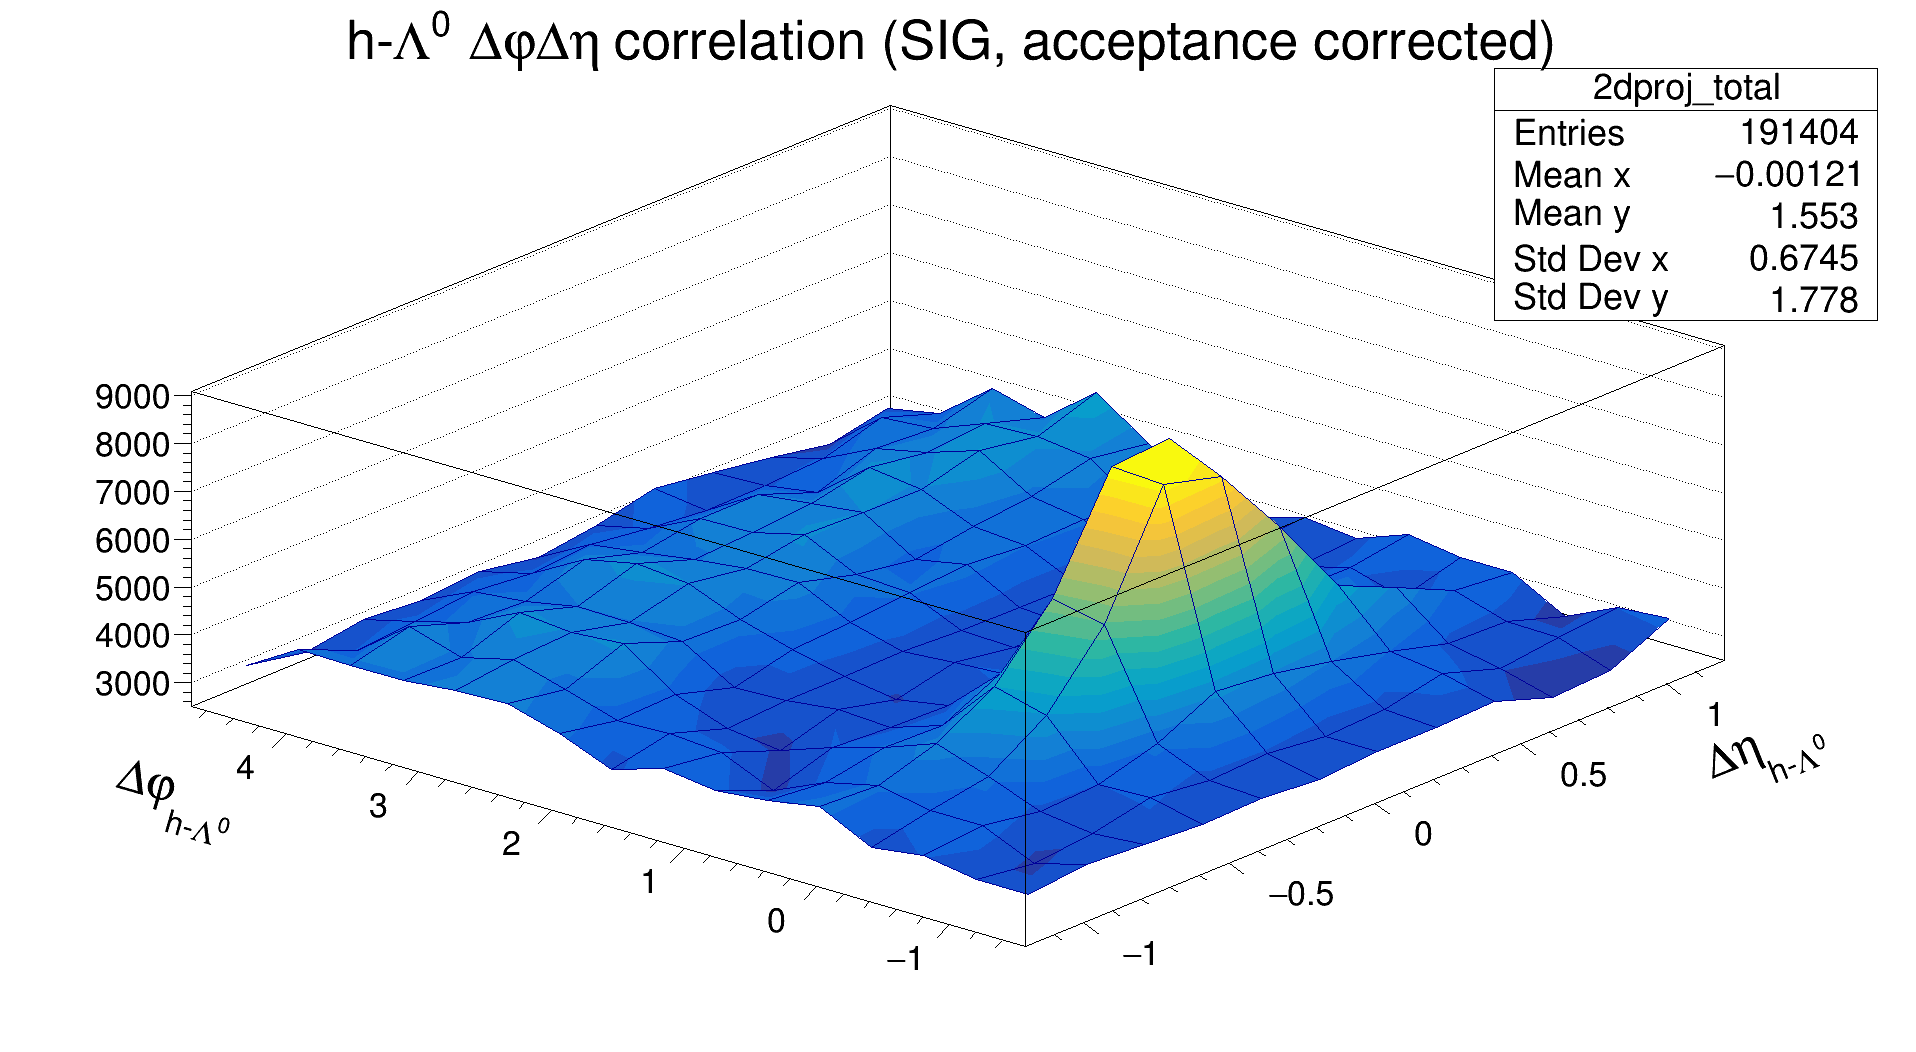

In [104]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_20_50.Draw("SURF1")
c.Draw()

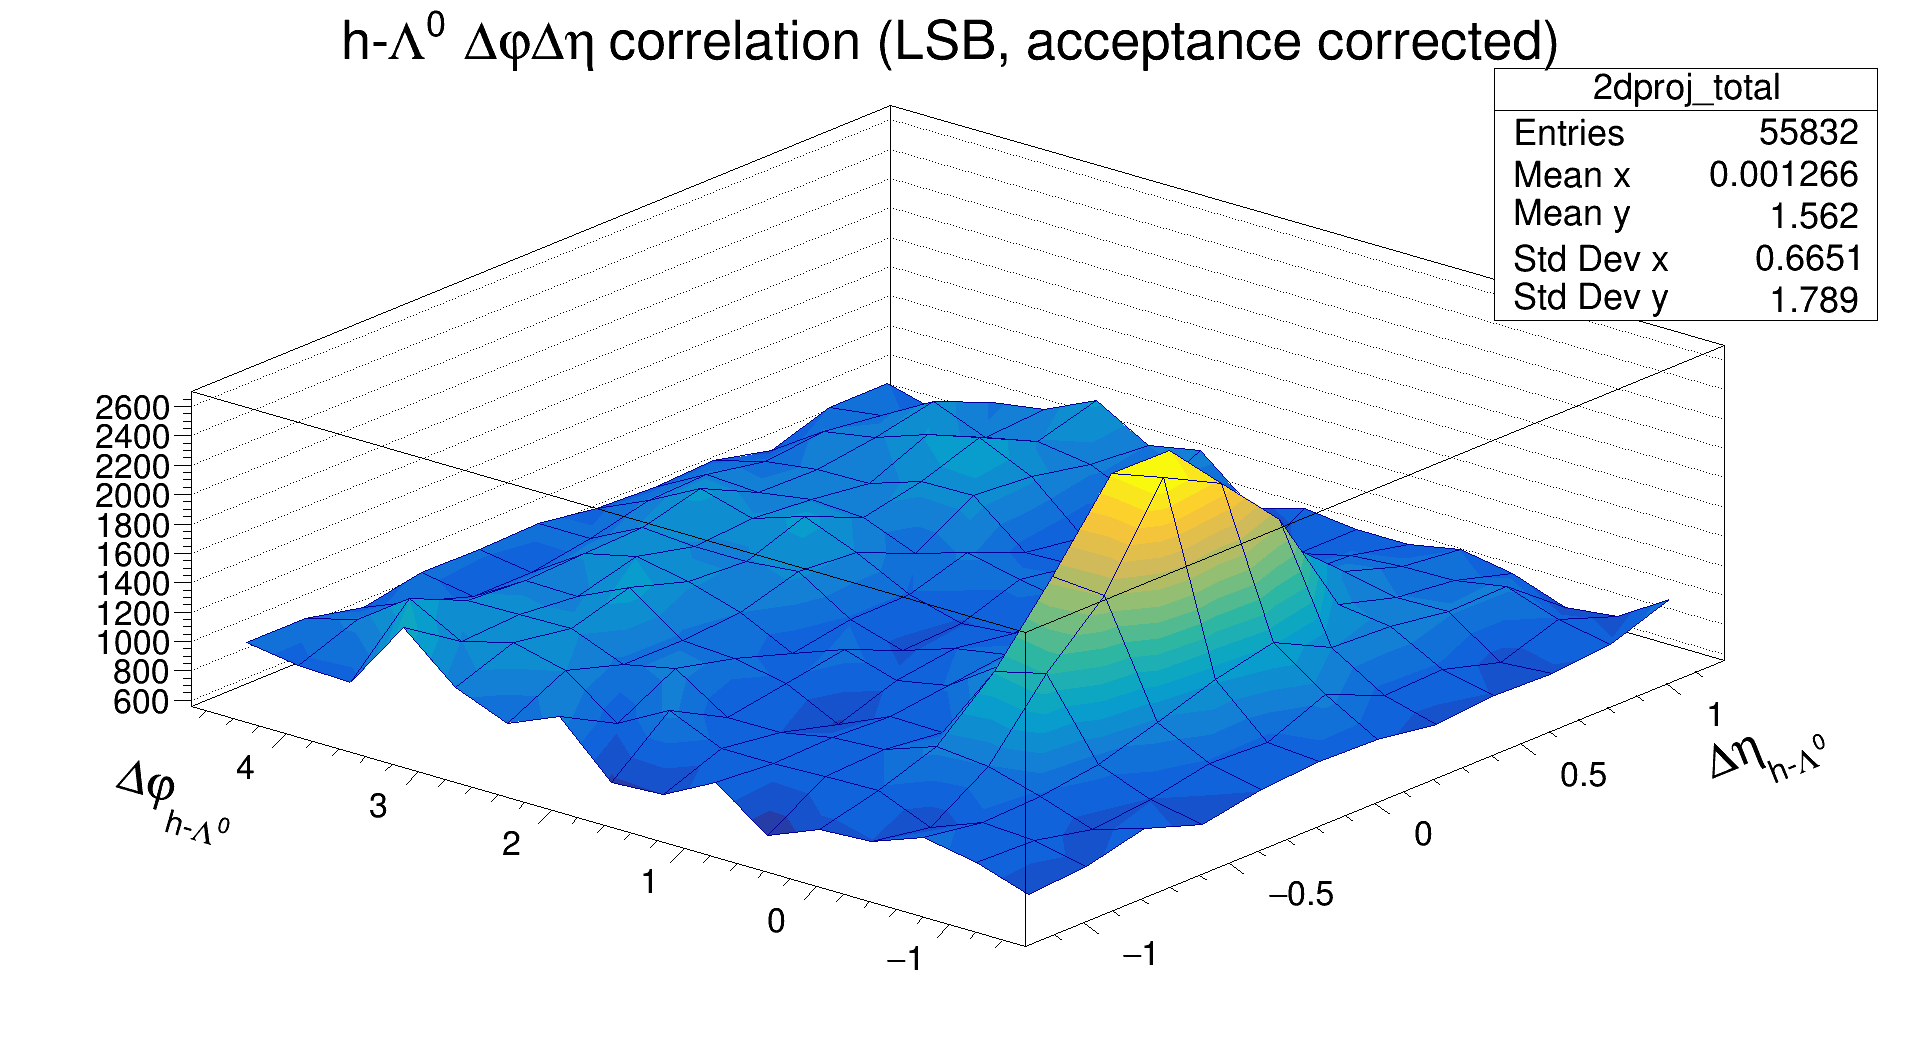

In [105]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_20_50.Draw("SURF1")
c.Draw()

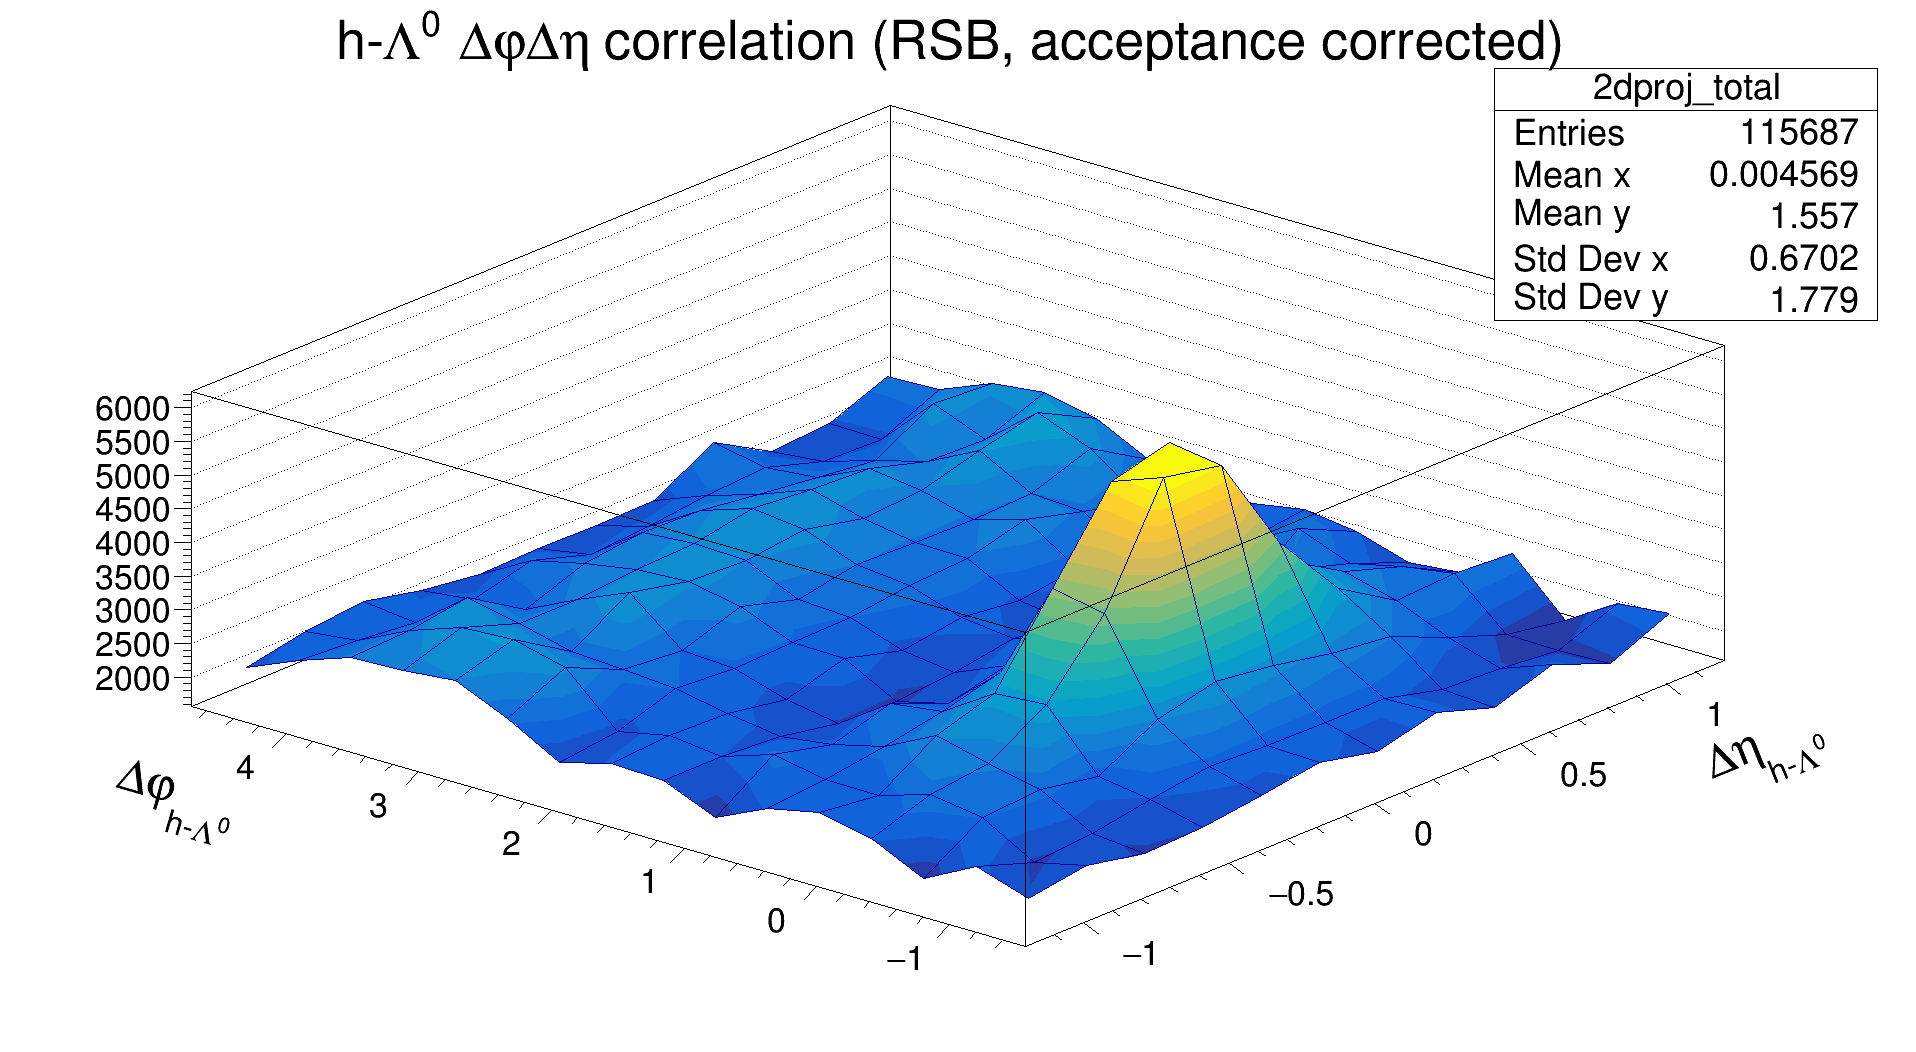

In [106]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_20_50.Draw("SURF1")
c.Draw()

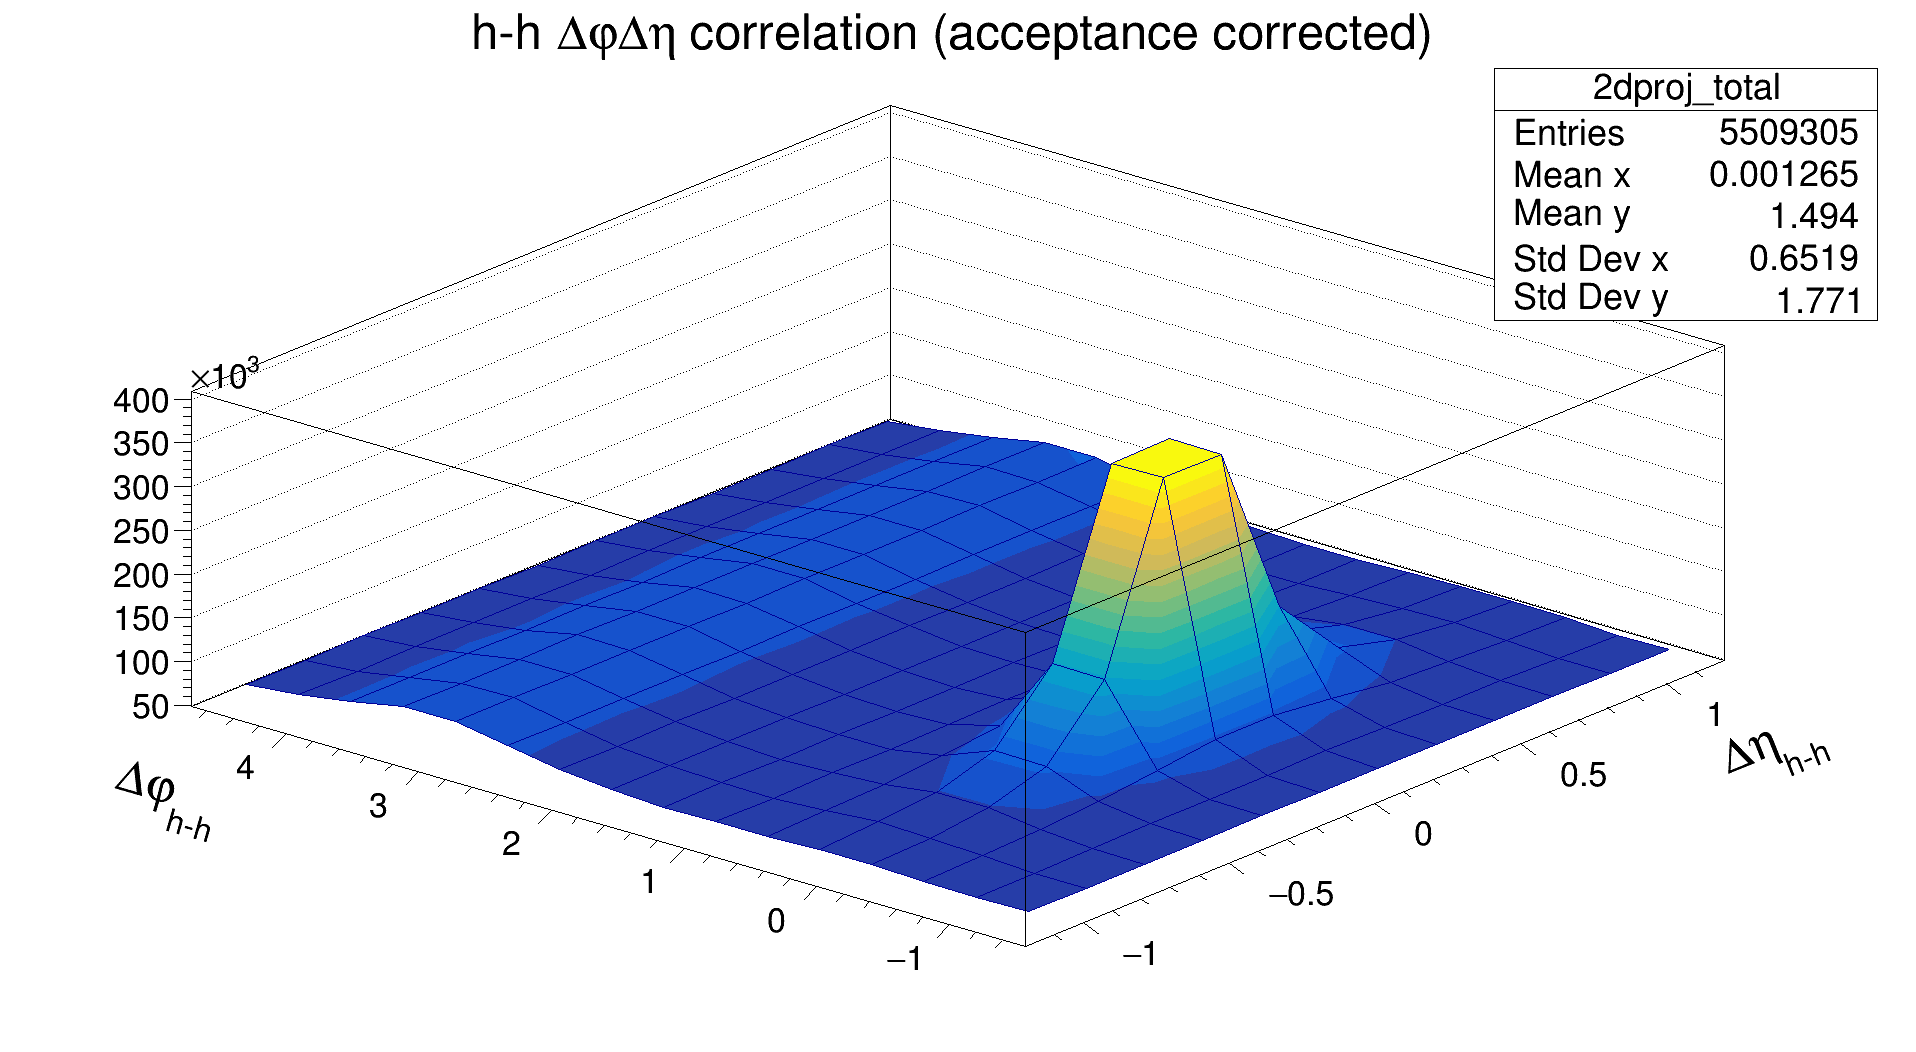

In [107]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_20_50.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_20_50.Draw("SURF1")
c.Draw()

In [108]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_2d_mixcor_sig_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_2d_mixcor_rsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_ls_2d_mixcor_lsb_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_ls_2d_mixcor_sig_20_50.Scale(1.0/num_trigs_20_50)
h_lambda_ls_2d_mixcor_rsb_20_50.Scale(1.0/num_trigs_20_50)
h_h_2d_mixcor_20_50.Scale(1.0/num_trigs_20_50)

### Sideband subtraction section

In [112]:
# First comparing left and right sidebands
h_lambda_lsb_dphi_20_50 = h_lambda_2d_mixcor_lsb_20_50.ProjectionY("h_lambda_lsb_dphi_20_50")
h_lambda_rsb_dphi_20_50 = h_lambda_2d_mixcor_rsb_20_50.ProjectionY("h_lambda_rsb_dphi_20_50")
h_lambda_sig_dphi_20_50 = h_lambda_2d_mixcor_sig_20_50.ProjectionY("h_lambda_sig_dphi_20_50")
h_lambda_lsb_dphi_20_50.Scale(1/h_lambda_lsb_dphi_20_50.Integral())
h_lambda_rsb_dphi_20_50.Scale(1/h_lambda_rsb_dphi_20_50.Integral())
h_lambda_sig_dphi_20_50.Scale(1/h_lambda_sig_dphi_20_50.Integral())

In [113]:
h_lambda_lsb_dphi_20_50.SetTitle("h-#Lambda^{0} LSB (blue) vs RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_20_50.SetLineColor(rt.kBlue)
h_lambda_rsb_dphi_20_50.SetLineColor(rt.kRed)
h_lambda_sig_dphi_20_50.SetLineColor(rt.kGreen + 2)
h_lambda_lsb_dphi_20_50.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_lsb_dphi_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_lsb_dphi_20_50.GetXaxis().SetTitleOffset(0.5)
h_lambda_lsb_dphi_20_50.SetStats(0)
h_lambda_rsb_dphi_20_50.SetStats(0)
h_lambda_sig_dphi_20_50.SetStats(0)

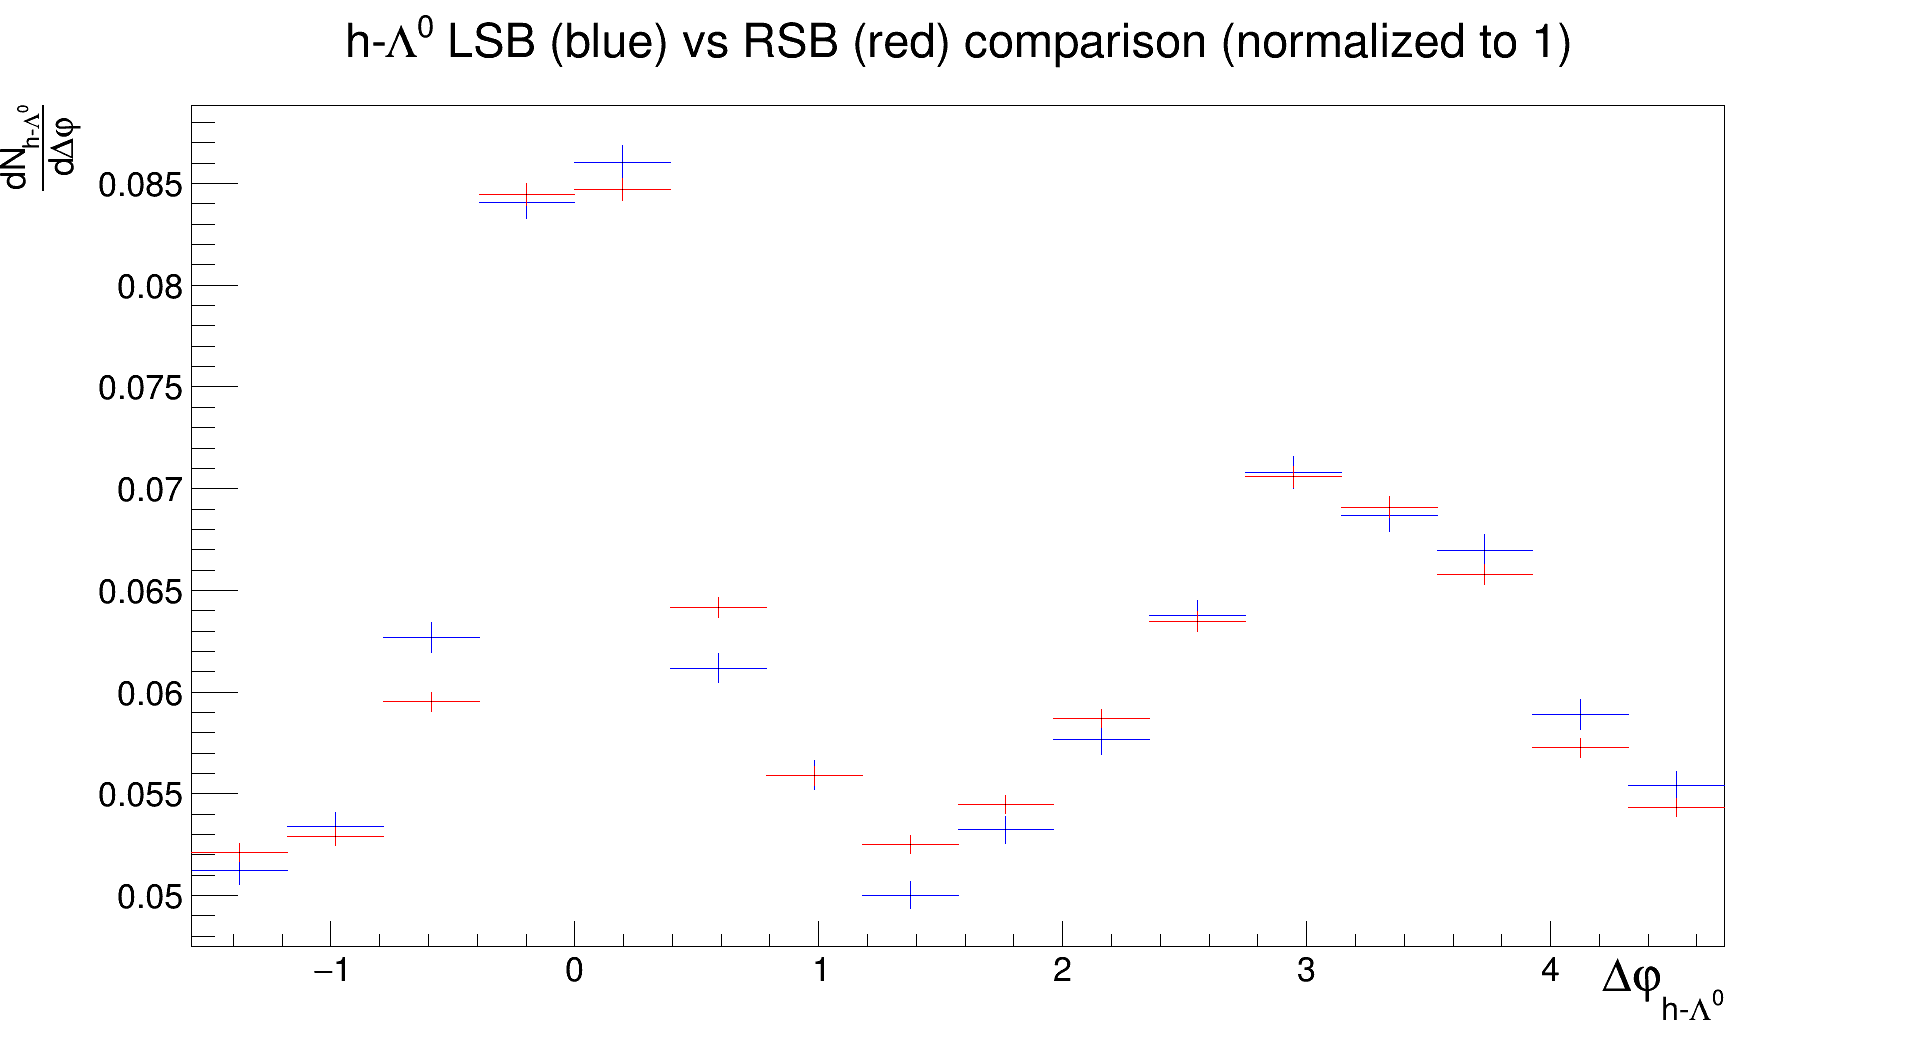

In [114]:
h_lambda_lsb_dphi_20_50.Draw()
h_lambda_rsb_dphi_20_50.Draw("SAME")
c.Draw()

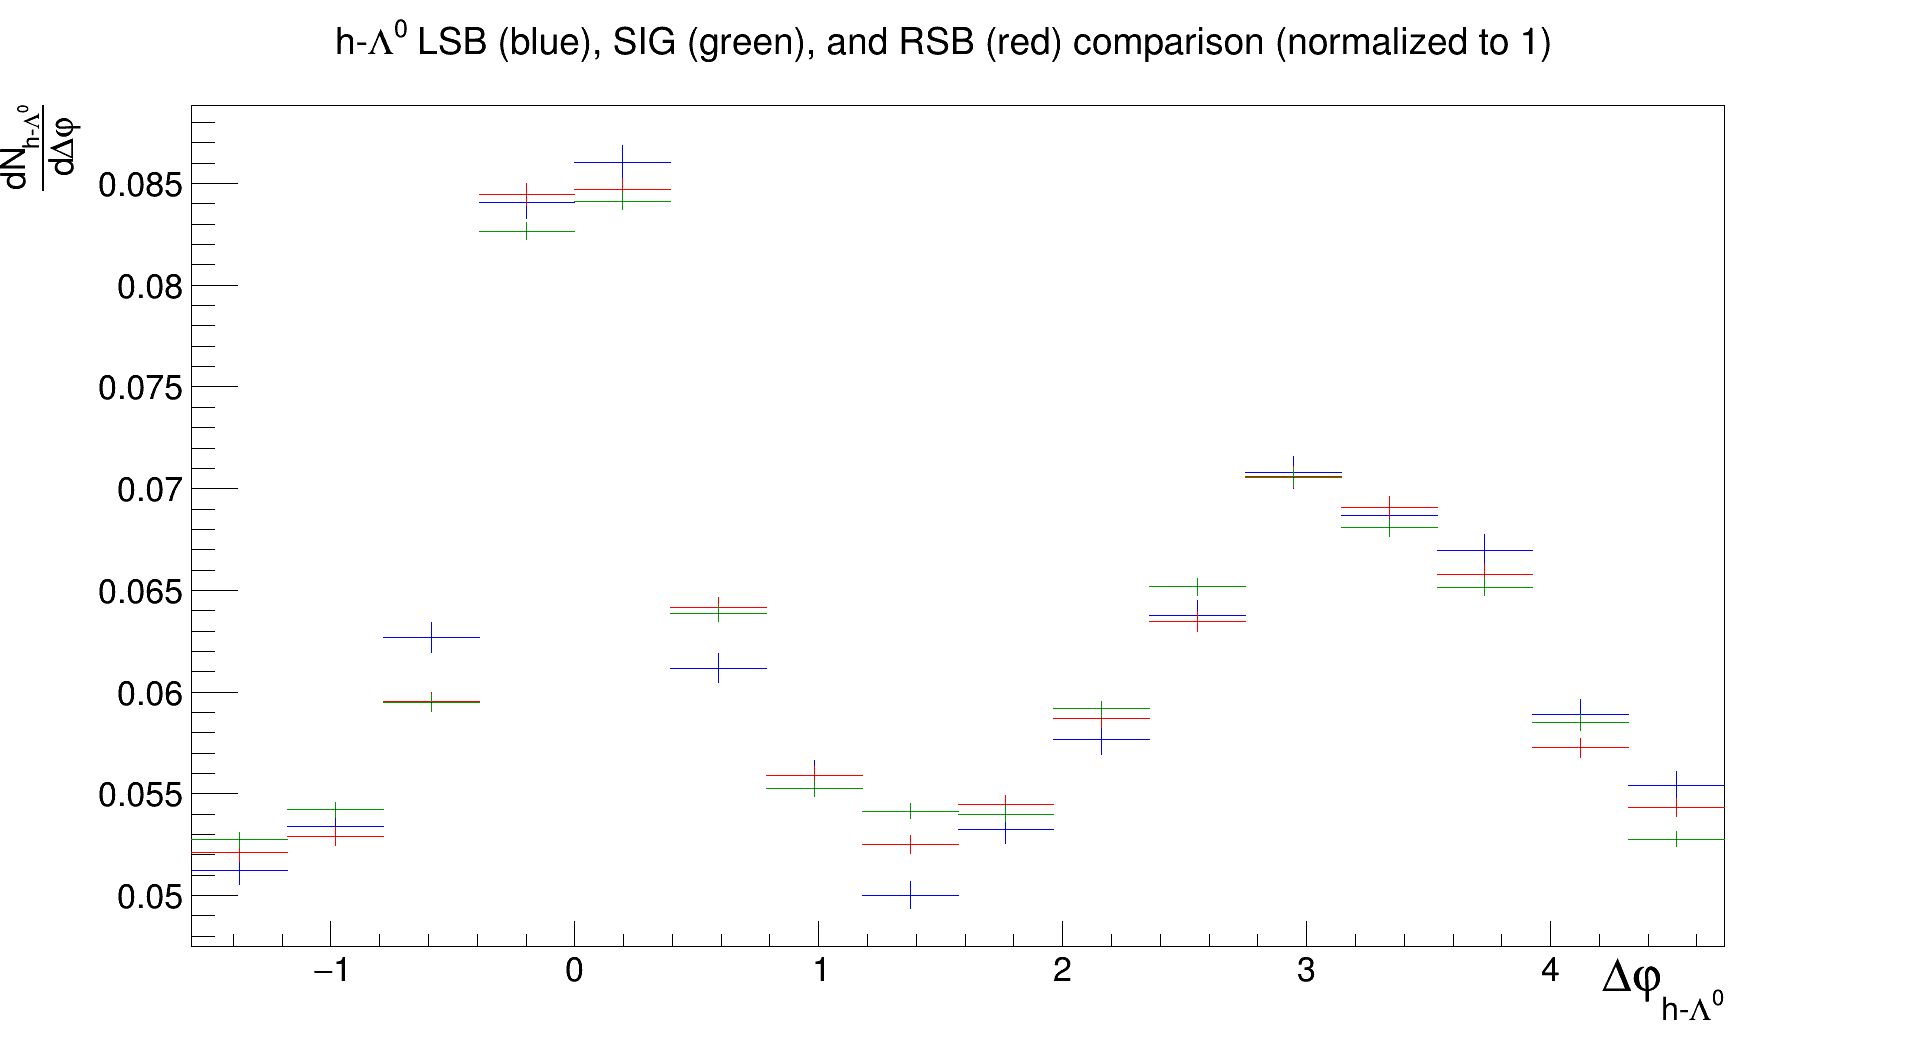

In [115]:
h_lambda_lsb_dphi_20_50.SetTitle("h-#Lambda^{0} LSB (blue), SIG (green), and RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_20_50.Draw()
h_lambda_rsb_dphi_20_50.Draw("SAME")
h_lambda_sig_dphi_20_50.Draw("SAME")
c.Draw()

In [116]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_20_50 = h_lambda_2d_mixcor_sig_20_50.Clone("h_lambda_2d_subtracted_20_50")
bg_integral_20_50 = (1 - lambda_signal_total_ratio_20_50)*h_lambda_2d_subtracted_20_50.Integral()
h_lambda_2d_subtracted_20_50.Add(h_lambda_2d_mixcor_rsb_20_50, -bg_integral_20_50)

True

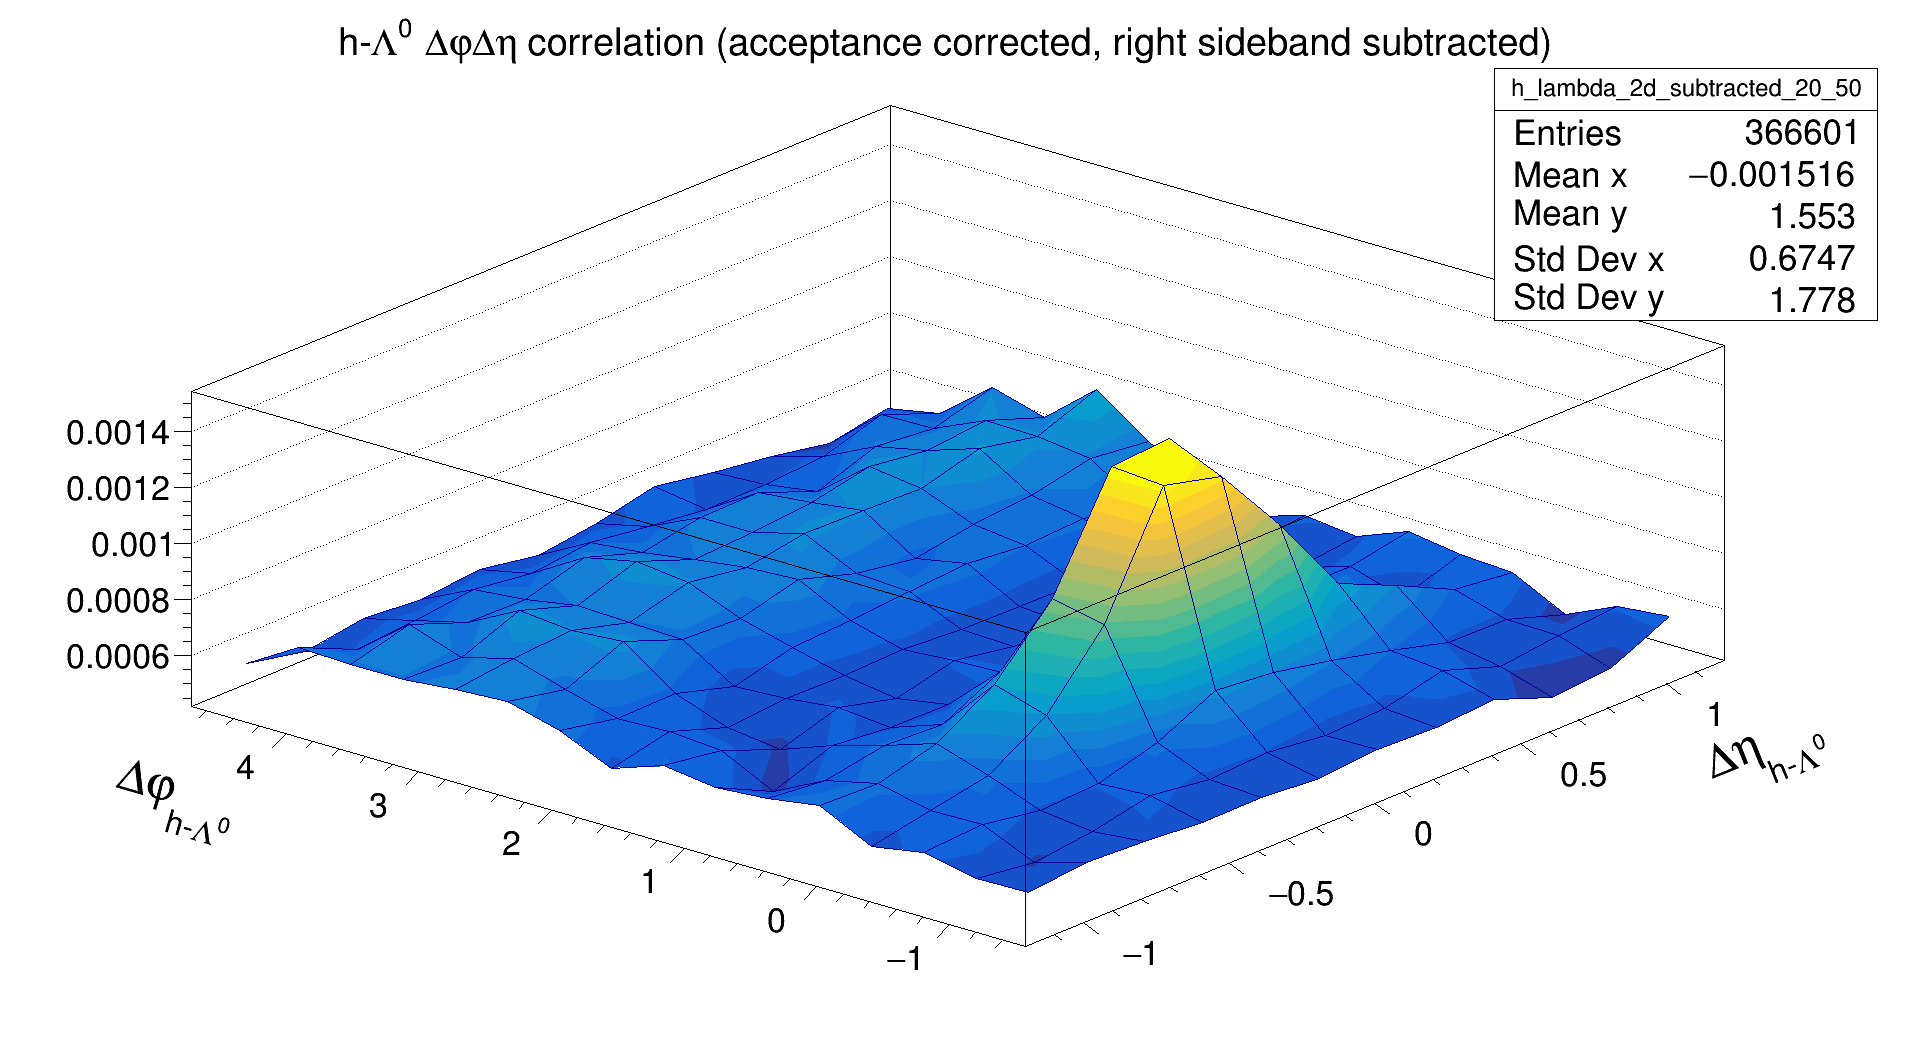

In [117]:
h_lambda_2d_subtracted_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_20_50.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [118]:
h_lambda_dphi_subtracted_20_50 = h_lambda_2d_subtracted_20_50.ProjectionY("h_lambda_dphi_subtracted_20_50")
h_lambda_dphi_subtracted_20_50.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_lambda_dphi_subtracted_20_50.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_20_50.SetLineWidth(3)
h_lambda_dphi_subtracted_20_50.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_20_50.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_20_50.GetXaxis().SetTitleOffset(0.5)

In [119]:
ue_line_20_50 = rt.TF1("ue_line_20_50", "pol0", -2, 6)
ue_upper_line_20_50 = rt.TF1("ue_upper_line_20_50", "pol0", -2, 6)
ue_lower_line_20_50 = rt.TF1("ue_lower_line_20_50", "pol0", -2, 6)
zero_line_20_50 = rt.TF1("zero_line_20_50", "pol0", -2, 6)
zero_upper_line_20_50 = rt.TF1("zero_upper_line_20_50", "pol0", -2, 6)
zero_lower_line_20_50 = rt.TF1("zero_lower_line_20_50", "pol0", -2, 6)
ue_avg_20_50 = (h_lambda_dphi_subtracted_20_50.GetBinContent(1) 
               + h_lambda_dphi_subtracted_20_50.GetBinContent(8)
               + h_lambda_dphi_subtracted_20_50.GetBinContent(9)
               + h_lambda_dphi_subtracted_20_50.GetBinContent(16))/4

ue_avg_error_20_50 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_20_50.GetBinError(1)**2 
               + h_lambda_dphi_subtracted_20_50.GetBinError(8)**2
               + h_lambda_dphi_subtracted_20_50.GetBinError(9)**2
               + h_lambda_dphi_subtracted_20_50.GetBinError(16)**2))


ue_line_20_50.SetParameter(0, ue_avg_20_50)
ue_line_20_50.SetLineColor(rt.kViolet - 6)
ue_line_20_50.SetLineWidth(3)
ue_line_20_50.SetLineStyle(rt.kSolid)

ue_upper_line_20_50.SetParameter(0, ue_avg_20_50 + ue_avg_error_20_50)
ue_upper_line_20_50.SetLineColor(rt.kViolet - 6)
ue_upper_line_20_50.SetLineStyle(rt.kDashed)

ue_lower_line_20_50.SetParameter(0, ue_avg_20_50 - ue_avg_error_20_50)
ue_lower_line_20_50.SetLineColor(rt.kViolet - 6)
ue_lower_line_20_50.SetLineStyle(rt.kDashed)

zero_line_20_50.SetParameter(0, 0)
zero_line_20_50.SetLineColor(rt.kViolet - 6)
zero_line_20_50.SetLineWidth(3)
zero_line_20_50.SetLineStyle(rt.kSolid)
zero_upper_line_20_50.SetParameter(0, ue_avg_error_20_50)
zero_upper_line_20_50.SetLineColor(rt.kViolet - 6)
zero_upper_line_20_50.SetLineStyle(rt.kDashed)
zero_lower_line_20_50.SetParameter(0, -ue_avg_error_20_50)
zero_lower_line_20_50.SetLineColor(rt.kViolet - 6)
zero_lower_line_20_50.SetLineStyle(rt.kDashed)

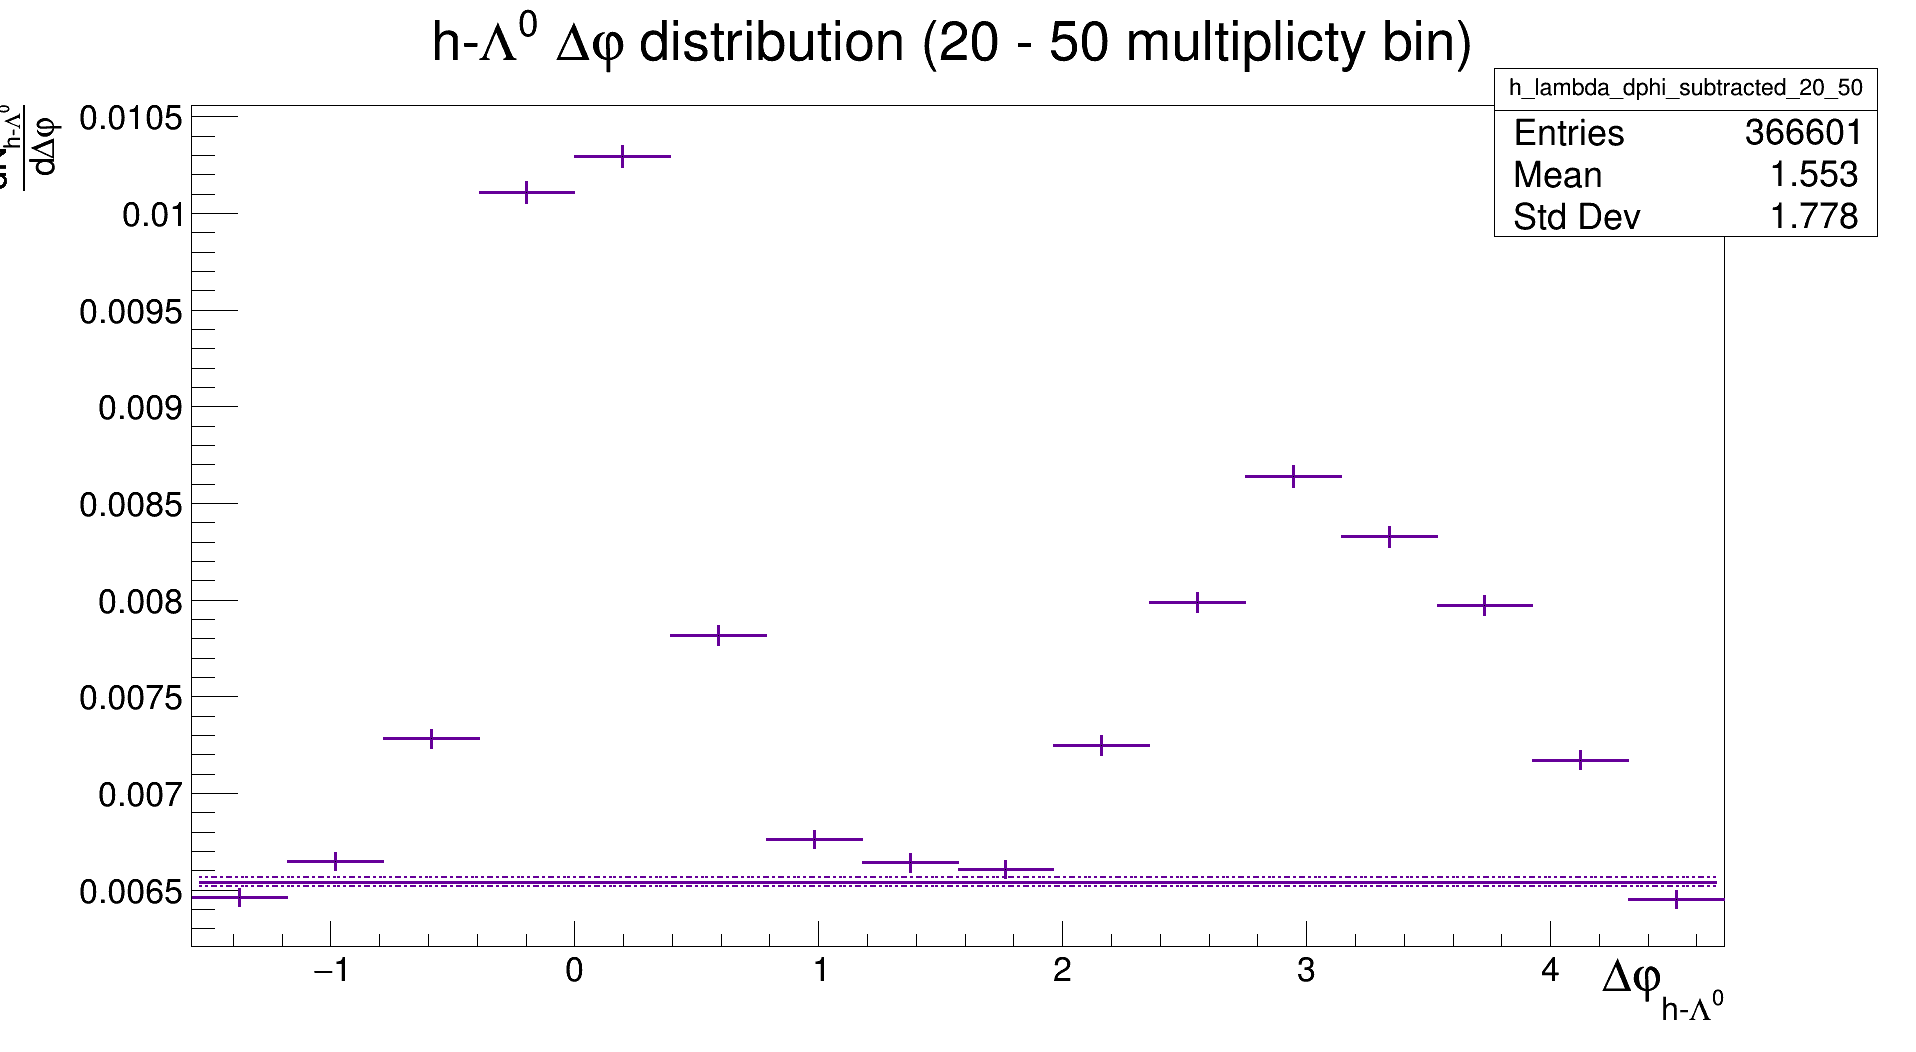

In [120]:
h_lambda_dphi_subtracted_20_50.Draw()
ue_line_20_50.Draw("SAME")
ue_upper_line_20_50.Draw("SAME")
ue_lower_line_20_50.Draw("SAME")
c.Draw()

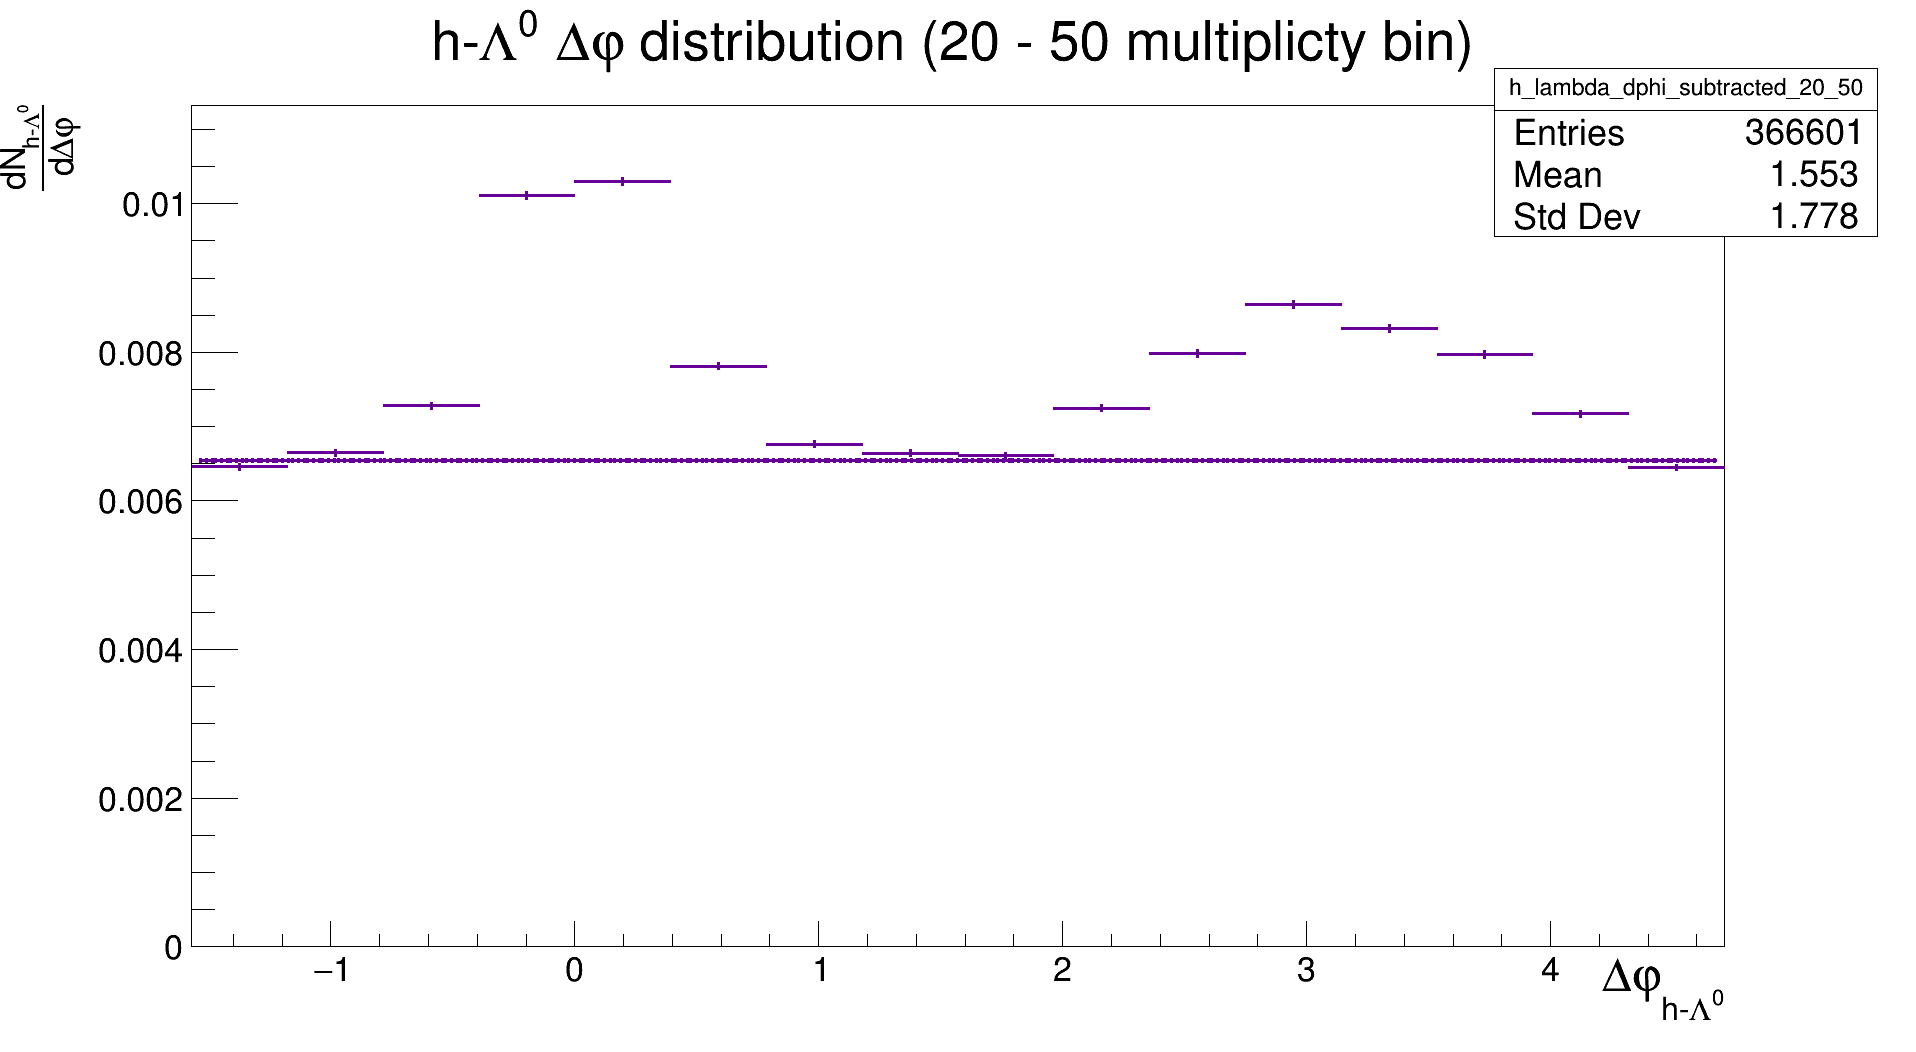

In [121]:
h_lambda_dphi_subtracted_20_50.GetYaxis().SetRangeUser(0, h_lambda_dphi_subtracted_20_50.GetMaximum()*1.1)
h_lambda_dphi_subtracted_20_50.Draw()
ue_line_20_50.Draw("SAME")
ue_upper_line_20_50.Draw("SAME")
ue_lower_line_20_50.Draw("SAME")
c.Draw()

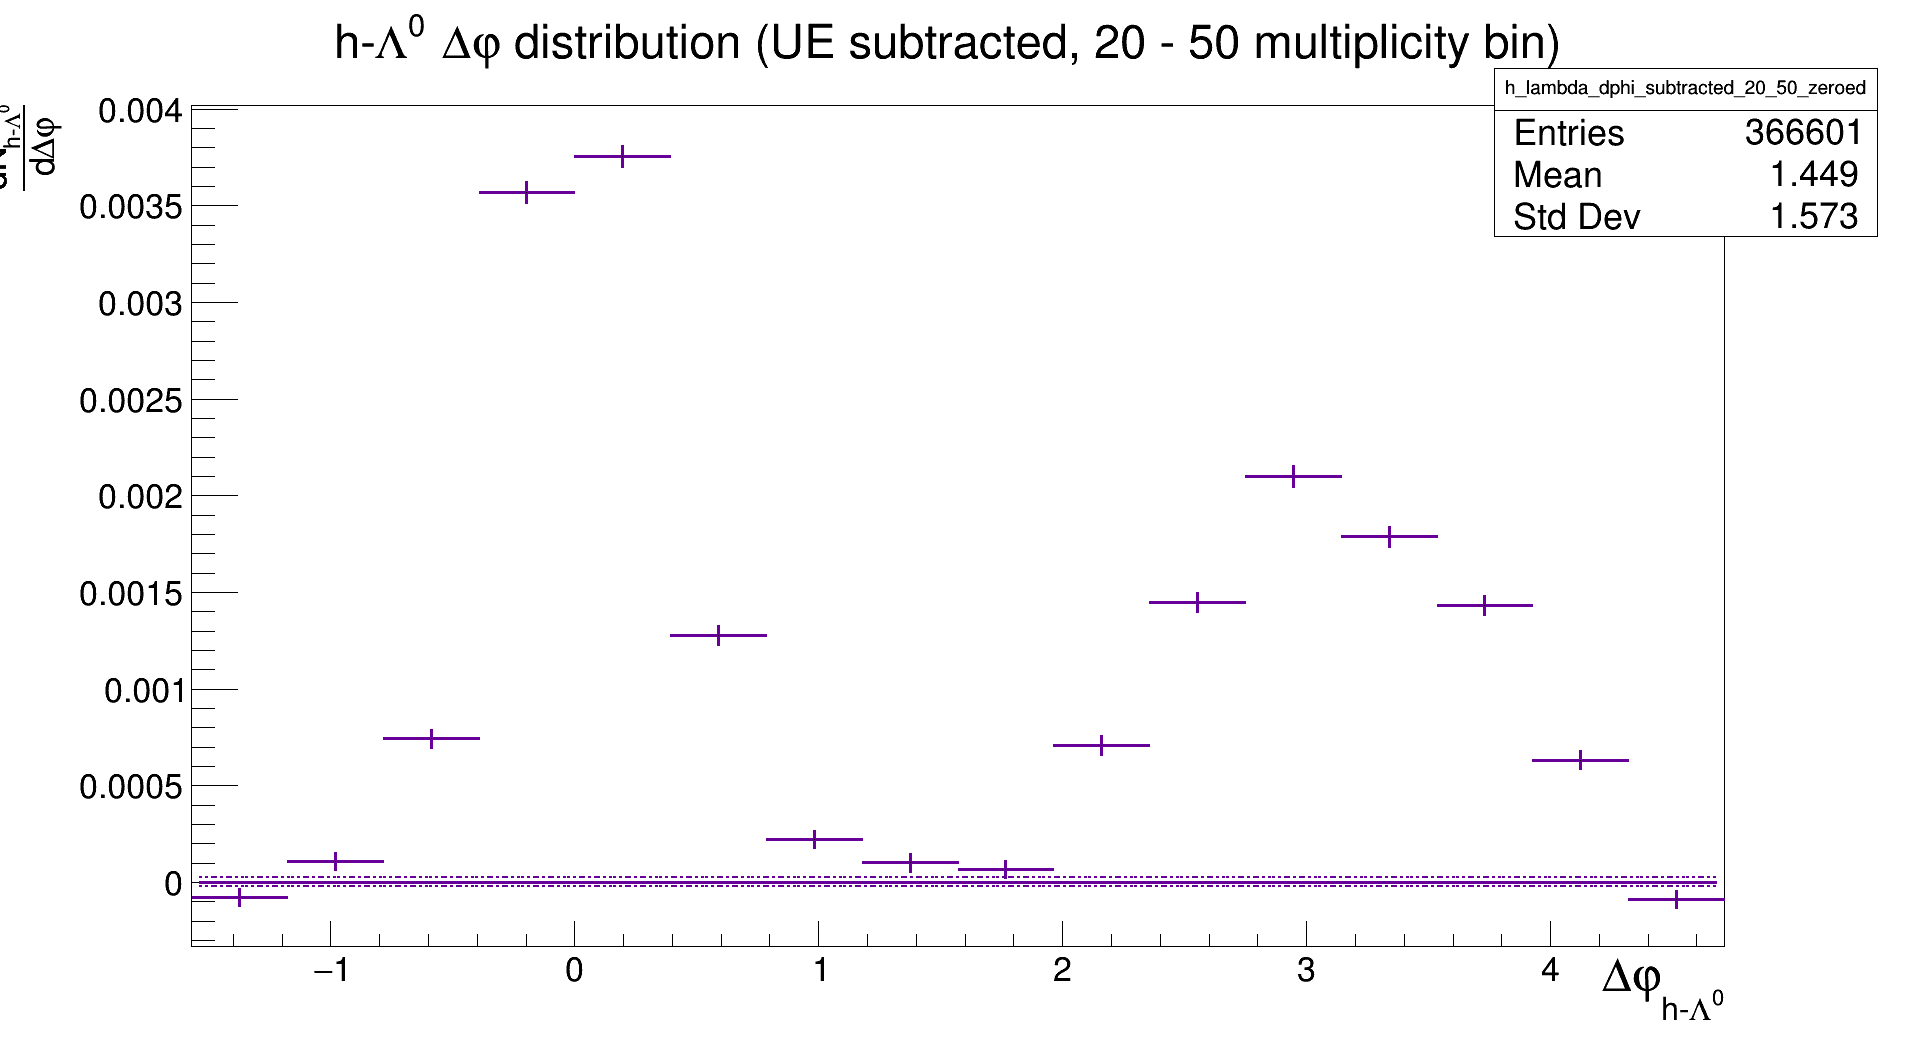

In [122]:
h_lambda_dphi_subtracted_20_50_zeroed = h_lambda_dphi_subtracted_20_50.Clone("h_lambda_dphi_subtracted_20_50_zeroed")
h_lambda_dphi_subtracted_20_50_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 20 - 50 multiplicity bin)")
h_lambda_dphi_subtracted_20_50_zeroed.Add(ue_line_20_50, -1)
h_lambda_dphi_subtracted_20_50_zeroed.Draw()
zero_line_20_50.Draw("SAME")
zero_upper_line_20_50.Draw("SAME")
zero_lower_line_20_50.Draw("SAME")
c.Draw()

In [123]:
DPHI_BINS = h_lambda_dphi_subtracted_20_50.GetNbinsX()

In [124]:
h_lambda_total_integral_20_50 = 0
h_lambda_near_integral_20_50 = 0
h_lambda_away_integral_20_50 = 0
h_lambda_ue_integral_20_50 = ue_avg_20_50*DPHI_BINS

h_lambda_total_integral_error_20_50 = 0
h_lambda_near_integral_error_20_50 = 0
h_lambda_away_integral_error_20_50 = 0
h_lambda_ue_integral_error_20_50 = ue_avg_error_20_50*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_20_50 += h_lambda_dphi_subtracted_20_50.GetBinContent(bin_num)
    h_lambda_total_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
    if bin_num < 9:
        h_lambda_near_integral_20_50 += (h_lambda_dphi_subtracted_20_50.GetBinContent(bin_num) - ue_avg_20_50)
        h_lambda_near_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
        h_lambda_near_integral_error_20_50 += ue_avg_error_20_50**2
    else:
        h_lambda_away_integral_20_50 += (h_lambda_dphi_subtracted_20_50.GetBinContent(bin_num) - ue_avg_20_50)
        h_lambda_away_integral_error_20_50 += h_lambda_dphi_subtracted_20_50.GetBinError(bin_num)**2
        h_lambda_away_integral_error_20_50 += ue_avg_error_20_50**2
h_lambda_total_integral_error_20_50 = math.sqrt(h_lambda_total_integral_error_20_50)
h_lambda_near_integral_error_20_50 = math.sqrt(h_lambda_near_integral_error_20_50)
h_lambda_away_integral_error_20_50 = math.sqrt(h_lambda_away_integral_error_20_50)

In [125]:
h_h_dphi_20_50 = h_h_2d_mixcor_20_50.ProjectionY("h_h_dphi_20_50")
h_h_dphi_20_50.SetTitle("h-h #Delta#varphi distribution (20 - 50 multiplicty bin)")
h_h_dphi_20_50.SetLineColor(rt.kBlue)
h_h_dphi_20_50.SetLineWidth(3)
h_h_dphi_20_50.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_20_50.GetXaxis().SetTitleSize(0.05)
h_h_dphi_20_50.GetXaxis().SetTitleOffset(0.5)

In [126]:
hh_ue_line_20_50 = rt.TF1("hh_ue_line_20_50", "pol0", -2, 6)
hh_ue_upper_line_20_50 = rt.TF1("hh_ue_upper_line_20_50", "pol0", -2, 6)
hh_ue_lower_line_20_50 = rt.TF1("hh_ue_lower_line_20_50", "pol0", -2, 6)
hh_zero_line_20_50 = rt.TF1("hh_zero_line_20_50", "pol0", -2, 6)
hh_zero_upper_line_20_50 = rt.TF1("hh_zero_upper_line_20_50", "pol0", -2, 6)
hh_zero_lower_line_20_50 = rt.TF1("hh_zero_lower_line_20_50", "pol0", -2, 6)
hh_ue_avg_20_50 = (h_h_dphi_20_50.GetBinContent(1) 
               + h_h_dphi_20_50.GetBinContent(8)
               + h_h_dphi_20_50.GetBinContent(9)
               + h_h_dphi_20_50.GetBinContent(16))/4

hh_ue_avg_error_20_50 = (1/4)*(math.sqrt(h_h_dphi_20_50.GetBinError(1)**2 
               + h_h_dphi_20_50.GetBinError(8)**2
               + h_h_dphi_20_50.GetBinError(9)**2
               + h_h_dphi_20_50.GetBinError(16)**2))


hh_ue_line_20_50.SetParameter(0, hh_ue_avg_20_50)
hh_ue_line_20_50.SetLineColor(rt.kBlue)
hh_ue_line_20_50.SetLineWidth(3)
hh_ue_line_20_50.SetLineStyle(rt.kSolid)

hh_ue_upper_line_20_50.SetParameter(0, hh_ue_avg_20_50 + hh_ue_avg_error_20_50)
hh_ue_upper_line_20_50.SetLineColor(rt.kBlue)
hh_ue_upper_line_20_50.SetLineStyle(rt.kDashed)

hh_ue_lower_line_20_50.SetParameter(0, hh_ue_avg_20_50 - hh_ue_avg_error_20_50)
hh_ue_lower_line_20_50.SetLineColor(rt.kBlue)
hh_ue_lower_line_20_50.SetLineStyle(rt.kDashed)

hh_zero_line_20_50.SetParameter(0, 0)
hh_zero_line_20_50.SetLineColor(rt.kBlue)
hh_zero_line_20_50.SetLineWidth(3)
hh_zero_line_20_50.SetLineStyle(rt.kSolid)
hh_zero_upper_line_20_50.SetParameter(0, hh_ue_avg_error_20_50)
hh_zero_upper_line_20_50.SetLineColor(rt.kBlue)
hh_zero_upper_line_20_50.SetLineStyle(rt.kDashed)
hh_zero_lower_line_20_50.SetParameter(0, -hh_ue_avg_error_20_50)
hh_zero_lower_line_20_50.SetLineColor(rt.kBlue)
hh_zero_lower_line_20_50.SetLineStyle(rt.kDashed)

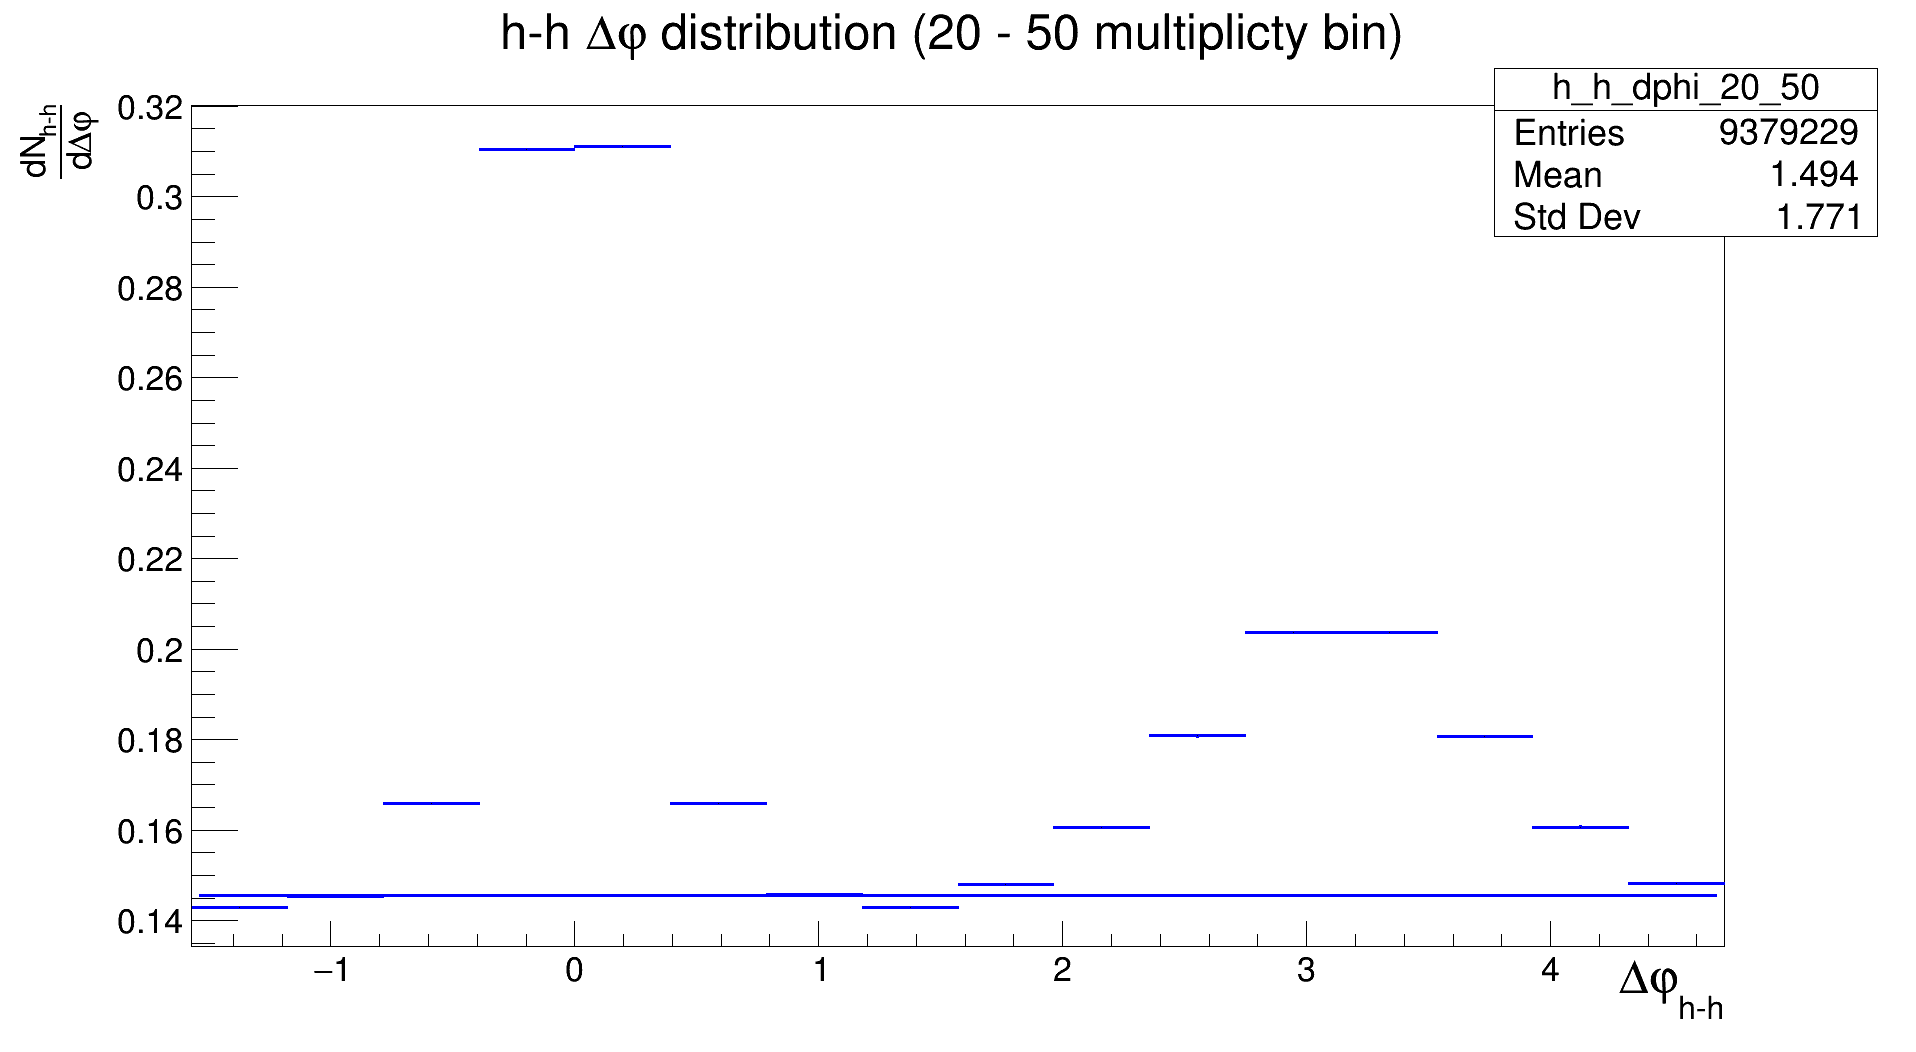

In [127]:
h_h_dphi_20_50.Draw()
hh_ue_line_20_50.Draw("SAME")
hh_ue_upper_line_20_50.Draw("SAME")
hh_ue_lower_line_20_50.Draw("SAME")
c.Draw()

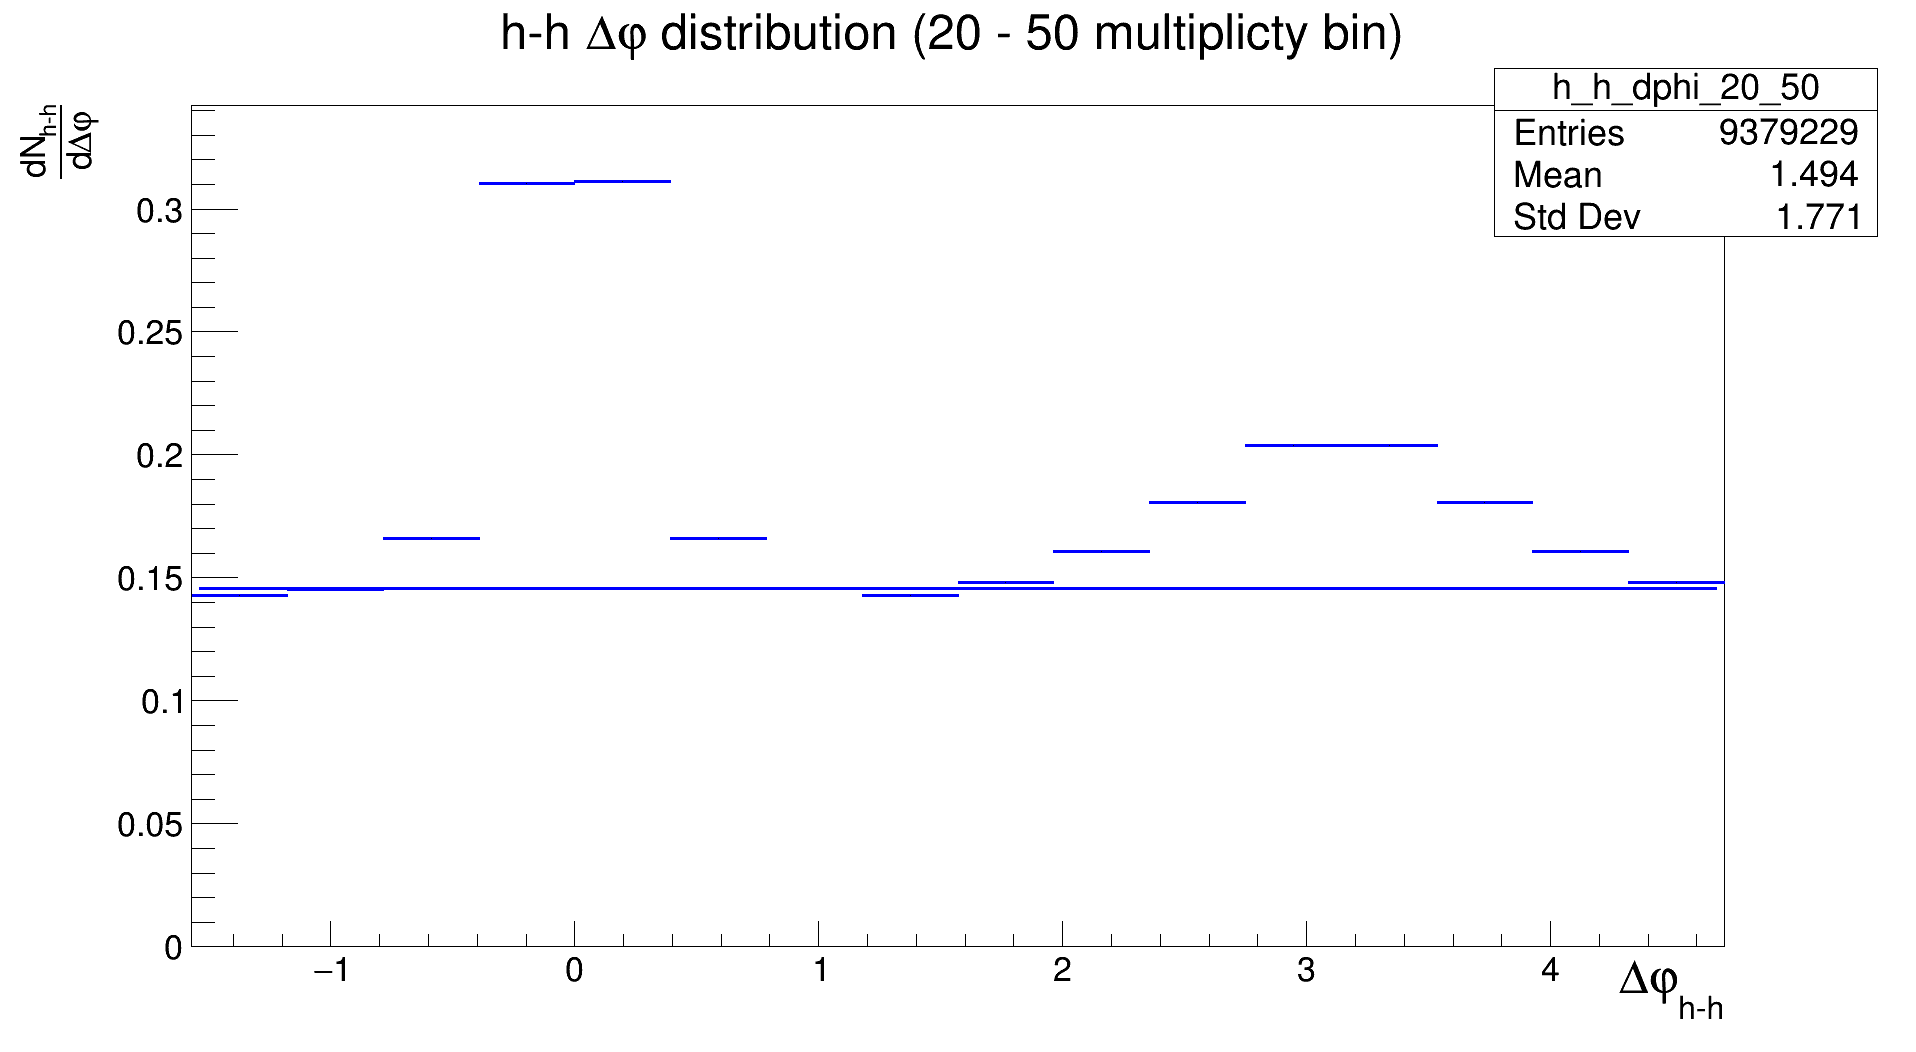

In [128]:
h_h_dphi_20_50.GetYaxis().SetRangeUser(0, h_h_dphi_20_50.GetMaximum()*1.1)
h_h_dphi_20_50.Draw()
hh_ue_line_20_50.Draw("SAME")
hh_ue_upper_line_20_50.Draw("SAME")
hh_ue_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_20_50_zeroed = h_h_dphi_20_50.Clone("h_h_dphi_20_50_zeroed")
h_h_dphi_20_50_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 20 - 50 multiplicity bin)")
h_h_dphi_20_50_zeroed.Add(hh_ue_line_20_50, -1)
h_h_dphi_20_50_zeroed.Draw()
hh_zero_line_20_50.Draw("SAME")
hh_zero_upper_line_20_50.Draw("SAME")
hh_zero_lower_line_20_50.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_20_50 = 0
h_h_near_integral_20_50 = 0
h_h_away_integral_20_50 = 0
h_h_ue_integral_20_50 = hh_ue_avg_20_50*DPHI_BINS

h_h_total_integral_error_20_50 = 0
h_h_near_integral_error_20_50 = 0
h_h_away_integral_error_20_50 = 0
h_h_ue_integral_error_20_50 = hh_ue_avg_error_20_50*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_20_50 += h_h_dphi_20_50.GetBinContent(bin_num)
    h_h_total_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
    if bin_num < 9:
        h_h_near_integral_20_50 += (h_h_dphi_20_50.GetBinContent(bin_num) - hh_ue_avg_20_50)
        h_h_near_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
        h_h_near_integral_error_20_50 += hh_ue_avg_error_20_50**2
    else:
        h_h_away_integral_20_50 += (h_h_dphi_20_50.GetBinContent(bin_num) - hh_ue_avg_20_50)
        h_h_away_integral_error_20_50 += h_h_dphi_20_50.GetBinError(bin_num)**2
        h_h_away_integral_error_20_50 += hh_ue_avg_error_20_50**2
h_h_total_integral_error_20_50 = math.sqrt(h_h_total_integral_error_20_50)
h_h_near_integral_error_20_50 = math.sqrt(h_h_near_integral_error_20_50)
h_h_away_integral_error_20_50 = math.sqrt(h_h_away_integral_error_20_50)

In [ ]:
near_ratio_20_50 = h_lambda_near_integral_20_50/h_h_near_integral_20_50
away_ratio_20_50 = h_lambda_away_integral_20_50/h_h_away_integral_20_50
ue_ratio_20_50 = h_lambda_ue_integral_20_50/h_h_ue_integral_20_50
total_ratio_20_50 = h_lambda_total_integral_20_50/h_h_total_integral_20_50

near_ratio_error_20_50 = near_ratio_20_50*math.sqrt((h_lambda_near_integral_error_20_50/h_lambda_near_integral_20_50)**2
                                                 + (h_h_near_integral_error_20_50/h_h_near_integral_20_50)**2)
away_ratio_error_20_50 = away_ratio_20_50*math.sqrt((h_lambda_away_integral_error_20_50/h_lambda_away_integral_20_50)**2
                                                 + (h_h_away_integral_error_20_50/h_h_away_integral_20_50)**2)
ue_ratio_error_20_50 = ue_ratio_20_50*math.sqrt((h_lambda_ue_integral_error_20_50/h_lambda_ue_integral_20_50)**2
                                                 + (h_h_ue_integral_error_20_50/h_h_ue_integral_20_50)**2)
total_ratio_error_20_50 = total_ratio_20_50*math.sqrt((h_lambda_total_integral_error_20_50/h_lambda_total_integral_20_50)**2
                                                 + (h_h_total_integral_error_20_50/h_h_total_integral_20_50)**2)

# 50 - 80 setup

In [ ]:
input_file_50_80 = rt.TFile("../online/output/cent_50_80.root")
input_list_50_80 = input_file_50_80.Get("h-lambda")
input_file_50_80.Close()

In [ ]:
trig_dist_50_80 = input_list_50_80.FindObject("fTriggerDist")
lambda_dist_50_80 = input_list_50_80.FindObject("fTriggeredLambdaDist")

In [ ]:
h_h_50_80 = input_list_50_80.FindObject("fDphiHHEff")
h_h_mixed_50_80 = input_list_50_80.FindObject("fDphiHHMixed")

In [ ]:
h_lambda_50_80 = input_list_50_80.FindObject("fDphiHLambdaEff")
h_lambda_ls_50_80 = input_list_50_80.FindObject("fDphiHLambdaLS")
h_lambda_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaMixed")
h_lambda_ls_mixed_50_80 = input_list_50_80.FindObject("fDphiHLambdaLSMixed")

In [ ]:
# Setting the trigger Pt (this is never changed again)
trig_dist_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_h_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(0).SetRangeUser(TRIG_PT_LOW, TRIG_PT_HIGH)

In [ ]:
# Setting the associated Pt (this is never changed again)
lambda_dist_50_80.GetAxis(0).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_h_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)
h_lambda_ls_mixed_50_80.GetAxis(1).SetRangeUser(ASSOC_PT_LOW, ASSOC_PT_HIGH)

In [ ]:
trig_pt_dist_50_80 = trig_dist_50_80.Projection(0).Clone("trig_pt_dist_50_80")
trig_phi_dist_50_80 = trig_dist_50_80.Projection(1).Clone("trig_phi_dist_50_80")
trig_eta_dist_50_80 = trig_dist_50_80.Projection(2).Clone("trig_eta_dist_50_80")
trig_2d_dist_50_80 = trig_dist_50_80.Projection(0, 3).Clone("trig_2d_dist_50_80")

trig_pt_dist_50_80.SetTitle("Trigger #font[12]{p}_{T} Distribution (Hybrid GCG)")
trig_pt_dist_50_80.Sumw2()
trig_pt_dist_50_80.SetLineColor(rt.kRed)

trig_phi_dist_50_80.SetTitle("Trigger #varphi Distribution (Hybrid GCG)")
trig_phi_dist_50_80.Sumw2()
trig_phi_dist_50_80.SetLineColor(rt.kRed)

trig_eta_dist_50_80.SetTitle("Trigger #eta Distribution (Hybrid GCG)")
trig_eta_dist_50_80.Sumw2()
trig_eta_dist_50_80.SetLineColor(rt.kRed)

In [ ]:
num_trigs_50_80 = trig_2d_dist_50_80.Integral()

In [ ]:
trig_pt_dist_50_80.Draw()
c.Draw()

In [ ]:
trig_eta_dist_50_80.Draw()
c.Draw()

In [ ]:
trig_phi_dist_50_80.GetYaxis().SetRangeUser(0, 600e3)
trig_phi_dist_50_80.Draw()
c.Draw()

### Signal analysis section

In [ ]:
# eta cuts first
lambda_dist_50_80.GetAxis(2).SetRangeUser(-0.8, 0.8)
lambda_mass_dist_50_80 = lambda_dist_50_80.Projection(3).Clone("lambda_mass_dist_50_80")

In [ ]:
lambda_mass_dist_50_80.SetTitle("#Lambda^{0} invariant mass distribution (p-#pi)")
lambda_mass_dist_50_80.Sumw2()
lambda_mass_dist_50_80.SetLineWidth(2)
lambda_mass_dist_50_80.GetXaxis().SetTitle("Mass (GeV/c^{2})")
lambda_mass_dist_50_80.GetYaxis().SetTitle("#frac{dN_{p-#pi}}{dM}")

In [ ]:
lambda_mass_dist_50_80.Draw()
c.Draw()

In [ ]:
bin_1 = lambda_mass_dist_50_80.FindBin(1.09)
bin_2 = lambda_mass_dist_50_80.FindBin(1.15)
bin_3 = lambda_mass_dist_50_80.FindBin(1.16 - EPSILON)
point_one = [1.09, lambda_mass_dist_50_80.GetBinContent(bin_1)]
point_two = [1.15, lambda_mass_dist_50_80.GetBinContent(bin_2)]
point_three = [1.16, lambda_mass_dist_50_80.GetBinContent(bin_3)]
bg_starting_params_50_80 = get_parabola(point_one, point_two, point_three)

In [ ]:
lambda_mass_fit_50_80 = rt.TF1("lambda_mass_fit_50_80", "[0]*TMath::Voigt(x - [1], [2], [3], 4) + pol2(4)", 1.09, 1.155)
lambda_mass_fit_50_80.SetNpx(1000)
lambda_mass_fit_50_80.SetParameter(0, 1.36753e01)
lambda_mass_fit_50_80.FixParameter(1, 1.11581)
lambda_mass_fit_50_80.SetParameter(2, 1.00576e-05 )
lambda_mass_fit_50_80.SetParameter(3, 6.04166e-03)
lambda_mass_fit_50_80.SetParameter(4, bg_starting_params_50_80[0])
lambda_mass_fit_50_80.SetParameter(5, bg_starting_params_50_80[1])
lambda_mass_fit_50_80.SetParameter(6, bg_starting_params_50_80[2])

In [ ]:
lambda_mass_dist_fit_50_80 = lambda_mass_dist_50_80.Clone("lambda_mass_dist_fit_50_80")
lambda_mass_dist_fit_50_80.Fit(lambda_mass_fit_50_80, "RS")
lambda_mass_dist_fit_50_80.Draw()
c.Draw()

In [ ]:
bg_fit_50_80 = rt.TF1("bg_fit_50_80", "pol2", 1.09, 1.15)
bg_fit_50_80.SetParameter(0, lambda_mass_fit_50_80.GetParameter(4))
bg_fit_50_80.SetParameter(1, lambda_mass_fit_50_80.GetParameter(5))
bg_fit_50_80.SetParameter(2, lambda_mass_fit_50_80.GetParameter(6))
bg_fit_50_80.SetNpx(1000)
bg_fit_50_80.SetLineColor(rt.kMagenta)
lambda_mass_dist_fit_50_80.Draw()
bg_fit_50_80.Draw("SAME")
c.Draw()

In [ ]:
left_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MIN)
right_signal_bin_50_80 = lambda_mass_dist_fit_50_80.FindBin(SIG_MAX)

lambda_bg_50_80 = 0
lambda_total_50_80 = 0
for bin_num in range(left_signal_bin_50_80, right_signal_bin_50_80 + 1):
    bin_center = lambda_mass_dist_fit_50_80.GetBinCenter(bin_num)
    lambda_bg_50_80 += bg_fit_50_80.Eval(bin_center)
    lambda_total_50_80 += lambda_mass_dist_fit_50_80.GetBinContent(bin_num)

lambda_signal_50_80 = lambda_total_50_80 - lambda_bg_50_80
lambda_signal_total_ratio_50_80 = lambda_signal_50_80/lambda_total_50_80
lambda_signal_bg_ratio_50_80 = lambda_signal_50_80/lambda_bg_50_80
print(f"The 0-20 lambda signal is: {lambda_signal_50_80}")
print(f"The 0-20 lambda background is: {lambda_bg_50_80}")
print(f"The 0-20 lambda S/B is: {lambda_signal_bg_ratio_50_80}")
print(f"The 0-20 lambda S/T is: {lambda_signal_total_ratio_50_80}")
print(f"The 0-20 lambda significance is: {lambda_signal_50_80/math.sqrt(lambda_signal_50_80 + lambda_bg_50_80)}")

### Mixed event correction section

In [ ]:
axes = arr.array('i', [2, 3, 4, 5])
h_lambda_50_80 = h_lambda_50_80.Projection(4, axes)
h_lambda_ls_50_80 = h_lambda_ls_50_80.Projection(4, axes)
h_lambda_mixed_50_80 = h_lambda_mixed_50_80.Projection(4, axes)
h_lambda_ls_mixed_50_80 = h_lambda_ls_mixed_50_80.Projection(4, axes)

In [ ]:
h_h_50_80 = h_h_50_80.Projection(2, 3, 4)
h_h_mixed_50_80 = h_h_mixed_50_80.Projection(2, 3, 4)
h_h_50_80.Sumw2()
h_h_mixed_50_80.Sumw2()

In [ ]:
# Setting up 2-d correlation plots before the mixed event correction
h_lambda_2d_nomixcor_50_80 = h_lambda_50_80.Projection(0, 1).Clone("h_lambda_2d_nomixcor_50_80")
h_lambda_ls_2d_nomixcor_50_80 = h_lambda_ls_50_80.Projection(0, 1).Clone("h_lambda_ls_2d_nomixcor_50_80")
h_lambda_mixed_2d_50_80 = h_lambda_mixed_50_80.Projection(0, 1).Clone("h_lambda_mixed_2d_50_80")

In [ ]:
h_h_2d_nomixcor_50_80 = h_h_50_80.Project3D("xye").Clone("h_h_2d_nomixcor_50_80")
h_h_mixed_2d_50_80 = h_h_mixed_50_80.Project3D("xye").Clone("h_h_mixed_2d_50_80")

In [ ]:
h_lambda_2d_nomixcor_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_50_80.SetTitle("h-#Lambda^{0} (LS) #Delta#varphi#Delta#eta (no acceptance correction)")
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_ls_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_50_80.SetTitle("Mixed-event h-#Lambda^{0} #Delta#varphi#Delta#eta")
h_lambda_mixed_2d_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_mixed_2d_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_mixed_2d_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_mixed_2d_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_nomixcor_50_80.SetTitle("h-h #Delta#varphi#Delta#eta (no acceptance correction)")
h_h_2d_nomixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_2d_nomixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_2d_nomixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_h_2d_nomixcor_50_80.GetYaxis().SetTitleOffset(1.3)
h_h_mixed_2d_50_80.SetTitle("Mixed-event h-h #Delta#varphi#Delta#eta")
h_h_mixed_2d_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_h_mixed_2d_50_80.GetXaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_mixed_2d_50_80.GetYaxis().SetTitleSize(0.05)
h_h_mixed_2d_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_nomixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_nomixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_ls_2d_nomixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_ls_2d_nomixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_mixed_2d_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_mixed_2d_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_nomixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_nomixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_mixed_2d_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_mixed_2d_50_80.Draw("SURF1")
c.Draw()

In [ ]:
h_lambda_2d_mixcor_lsb_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, LSB_MIN, LSB_MAX)
h_lambda_2d_mixcor_sig_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, SIG_MIN, SIG_MAX)
h_lambda_2d_mixcor_rsb_50_80 = make_mixed_corrections(h_lambda_50_80, h_lambda_mixed_50_80, RSB_MIN, RSB_MAX)
h_lambda_ls_2d_mixcor_lsb_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, LSB_MIN, LSB_MAX)
h_lambda_ls_2d_mixcor_sig_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, SIG_MIN, SIG_MAX)
h_lambda_ls_2d_mixcor_rsb_50_80 = make_mixed_corrections(h_lambda_ls_50_80, h_lambda_ls_mixed_50_80, RSB_MIN, RSB_MAX)

In [ ]:
h_h_2d_mixcor_50_80 = make_mixed_corrections(h_h_50_80, h_h_mixed_50_80, LSB_MIN, LSB_MAX, is_hh=True)

In [ ]:
h_lambda_2d_mixcor_lsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (LSB, acceptance corrected)")
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_lsb_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_sig_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (SIG, acceptance corrected)")
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_sig_50_80.GetYaxis().SetTitleOffset(1.3)

h_lambda_2d_mixcor_rsb_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (RSB, acceptance corrected)")
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitle("#Delta#eta_{h-#Lambda^{0}}")
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetTitleOffset(1.3)
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitleSize(0.05)
h_lambda_2d_mixcor_rsb_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
h_h_2d_mixcor_50_80.SetTitle("h-h #Delta#varphi#Delta#eta correlation (acceptance corrected)")
h_h_2d_mixcor_50_80.GetYaxis().SetTitle("#Delta#varphi_{h-h}")
h_h_2d_mixcor_50_80.GetXaxis().SetTitle("#Delta#eta_{h-h}")
h_h_2d_mixcor_50_80.GetXaxis().SetTitleSize(0.05)
h_h_2d_mixcor_50_80.GetXaxis().SetTitleOffset(1.3)
h_h_2d_mixcor_50_80.GetYaxis().SetTitleSize(0.05)
h_h_2d_mixcor_50_80.GetYaxis().SetTitleOffset(1.3)

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_sig_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_sig_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_lsb_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_lsb_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_lambda_2d_mixcor_rsb_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_lambda_2d_mixcor_rsb_50_80.Draw("SURF1")
c.Draw()

In [ ]:
c.SetTheta(50)
c.SetPhi(50)
h_h_2d_mixcor_50_80.GetXaxis().SetRangeUser(-DELTA_ETA_MAX, DELTA_ETA_MAX)
h_h_2d_mixcor_50_80.Draw("SURF1")
c.Draw()

In [ ]:
# per-trigger normalization done here
h_lambda_2d_mixcor_lsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_2d_mixcor_sig_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_2d_mixcor_rsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_ls_2d_mixcor_lsb_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_ls_2d_mixcor_sig_50_80.Scale(1.0/num_trigs_50_80)
h_lambda_ls_2d_mixcor_rsb_50_80.Scale(1.0/num_trigs_50_80)
h_h_2d_mixcor_50_80.Scale(1.0/num_trigs_50_80)

### Sideband subtraction section

In [ ]:
# First comparing left and right sidebands
h_lambda_lsb_dphi_50_80 = h_lambda_2d_mixcor_lsb_50_80.ProjectionY("h_lambda_lsb_dphi_50_80")
h_lambda_rsb_dphi_50_80 = h_lambda_2d_mixcor_rsb_50_80.ProjectionY("h_lambda_rsb_dphi_50_80")
h_lambda_sig_dphi_50_80 = h_lambda_2d_mixcor_sig_50_80.ProjectionY("h_lambda_sig_dphi_50_80")
h_lambda_lsb_dphi_50_80.Scale(1/h_lambda_lsb_dphi_50_80.Integral())
h_lambda_rsb_dphi_50_80.Scale(1/h_lambda_rsb_dphi_50_80.Integral())
h_lambda_sig_dphi_50_80.Scale(1/h_lambda_sig_dphi_50_80.Integral())

In [ ]:
h_lambda_lsb_dphi_50_80.SetTitle("h-#Lambda^{0} LSB (blue) vs RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_50_80.SetLineColor(rt.kBlue)
h_lambda_rsb_dphi_50_80.SetLineColor(rt.kRed)
h_lambda_sig_dphi_50_80.SetLineColor(rt.kGreen + 2)
h_lambda_lsb_dphi_50_80.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_lsb_dphi_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_lsb_dphi_50_80.GetXaxis().SetTitleOffset(0.5)
h_lambda_lsb_dphi_50_80.SetStats(0)
h_lambda_rsb_dphi_50_80.SetStats(0)
h_lambda_sig_dphi_50_80.SetStats(0)

In [ ]:
h_lambda_lsb_dphi_50_80.Draw()
h_lambda_rsb_dphi_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_lsb_dphi_50_80.SetTitle("h-#Lambda^{0} LSB (blue), SIG (green), and RSB (red) comparison (normalized to 1)")
h_lambda_lsb_dphi_50_80.Draw()
h_lambda_rsb_dphi_50_80.Draw("SAME")
h_lambda_sig_dphi_50_80.Draw("SAME")
c.Draw()

In [ ]:
# using RSB for sideband subtraction
h_lambda_2d_subtracted_50_80 = h_lambda_2d_mixcor_sig_50_80.Clone("h_lambda_2d_subtracted_50_80")
bg_integral_50_80 = (1 - lambda_signal_total_ratio_50_80)*h_lambda_2d_subtracted_50_80.Integral()
h_lambda_2d_subtracted_50_80.Add(h_lambda_2d_mixcor_rsb_50_80, -bg_integral_50_80)

In [ ]:
h_lambda_2d_subtracted_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi#Delta#eta correlation (acceptance corrected, right sideband subtracted)")
h_lambda_2d_subtracted_50_80.Draw("SURF1")
c.Draw()

### Integral and ratio section

In [ ]:
h_lambda_dphi_subtracted_50_80 = h_lambda_2d_subtracted_50_80.ProjectionY("h_lambda_dphi_subtracted_50_80")
h_lambda_dphi_subtracted_50_80.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_lambda_dphi_subtracted_50_80.SetLineColor(rt.kViolet - 6)
h_lambda_dphi_subtracted_50_80.SetLineWidth(3)
h_lambda_dphi_subtracted_50_80.GetYaxis().SetTitle("#frac{dN_{h-#Lambda^{0}}}{d#Delta#varphi}")
h_lambda_dphi_subtracted_50_80.GetXaxis().SetTitleSize(0.05)
h_lambda_dphi_subtracted_50_80.GetXaxis().SetTitleOffset(0.5)

In [ ]:
ue_line_50_80 = rt.TF1("ue_line_50_80", "pol0", -2, 6)
ue_upper_line_50_80 = rt.TF1("ue_upper_line_50_80", "pol0", -2, 6)
ue_lower_line_50_80 = rt.TF1("ue_lower_line_50_80", "pol0", -2, 6)
zero_line_50_80 = rt.TF1("zero_line_50_80", "pol0", -2, 6)
zero_upper_line_50_80 = rt.TF1("zero_upper_line_50_80", "pol0", -2, 6)
zero_lower_line_50_80 = rt.TF1("zero_lower_line_50_80", "pol0", -2, 6)
ue_avg_50_80 = (h_lambda_dphi_subtracted_50_80.GetBinContent(1) 
               + h_lambda_dphi_subtracted_50_80.GetBinContent(8)
               + h_lambda_dphi_subtracted_50_80.GetBinContent(9)
               + h_lambda_dphi_subtracted_50_80.GetBinContent(16))/4

ue_avg_error_50_80 = (1/4)*(math.sqrt(h_lambda_dphi_subtracted_50_80.GetBinError(1)**2 
               + h_lambda_dphi_subtracted_50_80.GetBinError(8)**2
               + h_lambda_dphi_subtracted_50_80.GetBinError(9)**2
               + h_lambda_dphi_subtracted_50_80.GetBinError(16)**2))


ue_line_50_80.SetParameter(0, ue_avg_50_80)
ue_line_50_80.SetLineColor(rt.kViolet - 6)
ue_line_50_80.SetLineWidth(3)
ue_line_50_80.SetLineStyle(rt.kSolid)

ue_upper_line_50_80.SetParameter(0, ue_avg_50_80 + ue_avg_error_50_80)
ue_upper_line_50_80.SetLineColor(rt.kViolet - 6)
ue_upper_line_50_80.SetLineStyle(rt.kDashed)

ue_lower_line_50_80.SetParameter(0, ue_avg_50_80 - ue_avg_error_50_80)
ue_lower_line_50_80.SetLineColor(rt.kViolet - 6)
ue_lower_line_50_80.SetLineStyle(rt.kDashed)

zero_line_50_80.SetParameter(0, 0)
zero_line_50_80.SetLineColor(rt.kViolet - 6)
zero_line_50_80.SetLineWidth(3)
zero_line_50_80.SetLineStyle(rt.kSolid)
zero_upper_line_50_80.SetParameter(0, ue_avg_error_50_80)
zero_upper_line_50_80.SetLineColor(rt.kViolet - 6)
zero_upper_line_50_80.SetLineStyle(rt.kDashed)
zero_lower_line_50_80.SetParameter(0, -ue_avg_error_50_80)
zero_lower_line_50_80.SetLineColor(rt.kViolet - 6)
zero_lower_line_50_80.SetLineStyle(rt.kDashed)

In [ ]:
h_lambda_dphi_subtracted_50_80.Draw()
ue_line_50_80.Draw("SAME")
ue_upper_line_50_80.Draw("SAME")
ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_50_80.GetYaxis().SetRangeUser(0, h_lambda_dphi_subtracted_50_80.GetMaximum()*1.1)
h_lambda_dphi_subtracted_50_80.Draw()
ue_line_50_80.Draw("SAME")
ue_upper_line_50_80.Draw("SAME")
ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_lambda_dphi_subtracted_50_80_zeroed = h_lambda_dphi_subtracted_50_80.Clone("h_lambda_dphi_subtracted_50_80_zeroed")
h_lambda_dphi_subtracted_50_80_zeroed.SetTitle("h-#Lambda^{0} #Delta#varphi distribution (UE subtracted, 50 - 80 multiplicity bin)")
h_lambda_dphi_subtracted_50_80_zeroed.Add(ue_line_50_80, -1)
h_lambda_dphi_subtracted_50_80_zeroed.Draw()
zero_line_50_80.Draw("SAME")
zero_upper_line_50_80.Draw("SAME")
zero_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
DPHI_BINS = h_lambda_dphi_subtracted_50_80.GetNbinsX()

In [ ]:
h_lambda_total_integral_50_80 = 0
h_lambda_near_integral_50_80 = 0
h_lambda_away_integral_50_80 = 0
h_lambda_ue_integral_50_80 = ue_avg_50_80*DPHI_BINS 

h_lambda_total_integral_error_50_80 = 0
h_lambda_near_integral_error_50_80 = 0
h_lambda_away_integral_error_50_80 = 0
h_lambda_ue_integral_error_50_80 = ue_avg_error_50_80*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_lambda_total_integral_50_80 += h_lambda_dphi_subtracted_50_80.GetBinContent(bin_num)
    h_lambda_total_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
    if bin_num < 9:
        h_lambda_near_integral_50_80 += (h_lambda_dphi_subtracted_50_80.GetBinContent(bin_num) - ue_avg_50_80)
        h_lambda_near_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
        h_lambda_near_integral_error_50_80 += ue_avg_error_50_80**2
    else:
        h_lambda_away_integral_50_80 += (h_lambda_dphi_subtracted_50_80.GetBinContent(bin_num) - ue_avg_50_80)
        h_lambda_away_integral_error_50_80 += h_lambda_dphi_subtracted_50_80.GetBinError(bin_num)**2
        h_lambda_away_integral_error_50_80 += ue_avg_error_50_80**2
h_lambda_total_integral_error_50_80 = math.sqrt(h_lambda_total_integral_error_50_80)
h_lambda_near_integral_error_50_80 = math.sqrt(h_lambda_near_integral_error_50_80)
h_lambda_away_integral_error_50_80 = math.sqrt(h_lambda_away_integral_error_50_80)

In [ ]:
h_h_dphi_50_80 = h_h_2d_mixcor_50_80.ProjectionY("h_h_dphi_50_80")
h_h_dphi_50_80.SetTitle("h-h #Delta#varphi distribution (50 - 80 multiplicty bin)")
h_h_dphi_50_80.SetLineColor(rt.kBlue)
h_h_dphi_50_80.SetLineWidth(3)
h_h_dphi_50_80.GetYaxis().SetTitle("#frac{dN_{h-h}}{d#Delta#varphi}")
h_h_dphi_50_80.GetXaxis().SetTitleSize(0.05)
h_h_dphi_50_80.GetXaxis().SetTitleOffset(0.5)

In [ ]:
hh_ue_line_50_80 = rt.TF1("hh_ue_line_50_80", "pol0", -2, 6)
hh_ue_upper_line_50_80 = rt.TF1("hh_ue_upper_line_50_80", "pol0", -2, 6)
hh_ue_lower_line_50_80 = rt.TF1("hh_ue_lower_line_50_80", "pol0", -2, 6)
hh_zero_line_50_80 = rt.TF1("hh_zero_line_50_80", "pol0", -2, 6)
hh_zero_upper_line_50_80 = rt.TF1("hh_zero_upper_line_50_80", "pol0", -2, 6)
hh_zero_lower_line_50_80 = rt.TF1("hh_zero_lower_line_50_80", "pol0", -2, 6)
hh_ue_avg_50_80 = (h_h_dphi_50_80.GetBinContent(1) 
               + h_h_dphi_50_80.GetBinContent(8)
               + h_h_dphi_50_80.GetBinContent(9)
               + h_h_dphi_50_80.GetBinContent(16))/4

hh_ue_avg_error_50_80 = (1/4)*(math.sqrt(h_h_dphi_50_80.GetBinError(1)**2 
               + h_h_dphi_50_80.GetBinError(8)**2
               + h_h_dphi_50_80.GetBinError(9)**2
               + h_h_dphi_50_80.GetBinError(16)**2))


hh_ue_line_50_80.SetParameter(0, hh_ue_avg_50_80)
hh_ue_line_50_80.SetLineColor(rt.kBlue)
hh_ue_line_50_80.SetLineWidth(3)
hh_ue_line_50_80.SetLineStyle(rt.kSolid)

hh_ue_upper_line_50_80.SetParameter(0, hh_ue_avg_50_80 + hh_ue_avg_error_50_80)
hh_ue_upper_line_50_80.SetLineColor(rt.kBlue)
hh_ue_upper_line_50_80.SetLineStyle(rt.kDashed)

hh_ue_lower_line_50_80.SetParameter(0, hh_ue_avg_50_80 - hh_ue_avg_error_50_80)
hh_ue_lower_line_50_80.SetLineColor(rt.kBlue)
hh_ue_lower_line_50_80.SetLineStyle(rt.kDashed)

hh_zero_line_50_80.SetParameter(0, 0)
hh_zero_line_50_80.SetLineColor(rt.kBlue)
hh_zero_line_50_80.SetLineWidth(3)
hh_zero_line_50_80.SetLineStyle(rt.kSolid)
hh_zero_upper_line_50_80.SetParameter(0, hh_ue_avg_error_50_80)
hh_zero_upper_line_50_80.SetLineColor(rt.kBlue)
hh_zero_upper_line_50_80.SetLineStyle(rt.kDashed)
hh_zero_lower_line_50_80.SetParameter(0, -hh_ue_avg_error_50_80)
hh_zero_lower_line_50_80.SetLineColor(rt.kBlue)
hh_zero_lower_line_50_80.SetLineStyle(rt.kDashed)

In [ ]:
h_h_dphi_50_80.Draw()
hh_ue_line_50_80.Draw("SAME")
hh_ue_upper_line_50_80.Draw("SAME")
hh_ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_50_80.GetYaxis().SetRangeUser(0, h_h_dphi_50_80.GetMaximum()*1.1)
h_h_dphi_50_80.Draw()
hh_ue_line_50_80.Draw("SAME")
hh_ue_upper_line_50_80.Draw("SAME")
hh_ue_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_dphi_50_80_zeroed = h_h_dphi_50_80.Clone("h_h_dphi_50_80_zeroed")
h_h_dphi_50_80_zeroed.SetTitle("h-h #Delta#varphi distribution (UE subtracted, 50 - 80 multiplicity bin)")
h_h_dphi_50_80_zeroed.Add(hh_ue_line_50_80, -1)
h_h_dphi_50_80_zeroed.Draw()
hh_zero_line_50_80.Draw("SAME")
hh_zero_upper_line_50_80.Draw("SAME")
hh_zero_lower_line_50_80.Draw("SAME")
c.Draw()

In [ ]:
h_h_total_integral_50_80 = 0
h_h_near_integral_50_80 = 0
h_h_away_integral_50_80 = 0
h_h_ue_integral_50_80 = hh_ue_avg_50_80*DPHI_BINS

h_h_total_integral_error_50_80 = 0
h_h_near_integral_error_50_80 = 0
h_h_away_integral_error_50_80 = 0
h_h_ue_integral_error_50_80 = hh_ue_avg_error_50_80*DPHI_BINS

for bin_num in range(1, DPHI_BINS + 1):
    h_h_total_integral_50_80 += h_h_dphi_50_80.GetBinContent(bin_num)
    h_h_total_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
    if bin_num < 9:
        h_h_near_integral_50_80 += (h_h_dphi_50_80.GetBinContent(bin_num) - hh_ue_avg_50_80)
        h_h_near_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
        h_h_near_integral_error_50_80 += hh_ue_avg_error_50_80**2
    else:
        h_h_away_integral_50_80 += (h_h_dphi_50_80.GetBinContent(bin_num) - hh_ue_avg_50_80)
        h_h_away_integral_error_50_80 += h_h_dphi_50_80.GetBinError(bin_num)**2
        h_h_away_integral_error_50_80 += hh_ue_avg_error_50_80**2
h_h_total_integral_error_50_80 = math.sqrt(h_h_total_integral_error_50_80)
h_h_near_integral_error_50_80 = math.sqrt(h_h_near_integral_error_50_80)
h_h_away_integral_error_50_80 = math.sqrt(h_h_away_integral_error_50_80)

In [ ]:
near_ratio_50_80 = h_lambda_near_integral_50_80/h_h_near_integral_50_80
away_ratio_50_80 = h_lambda_away_integral_50_80/h_h_away_integral_50_80
ue_ratio_50_80 = h_lambda_ue_integral_50_80/h_h_ue_integral_50_80
total_ratio_50_80 = h_lambda_total_integral_50_80/h_h_total_integral_50_80

near_ratio_error_50_80 = near_ratio_50_80*math.sqrt((h_lambda_near_integral_error_50_80/h_lambda_near_integral_50_80)**2
                                                 + (h_h_near_integral_error_50_80/h_h_near_integral_50_80)**2)
away_ratio_error_50_80 = away_ratio_50_80*math.sqrt((h_lambda_away_integral_error_50_80/h_lambda_away_integral_50_80)**2
                                                 + (h_h_away_integral_error_50_80/h_h_away_integral_50_80)**2)
ue_ratio_error_50_80 = ue_ratio_50_80*math.sqrt((h_lambda_ue_integral_error_50_80/h_lambda_ue_integral_50_80)**2
                                                 + (h_h_ue_integral_error_50_80/h_h_ue_integral_50_80)**2)
total_ratio_error_50_80 = total_ratio_50_80*math.sqrt((h_lambda_total_integral_error_50_80/h_lambda_total_integral_50_80)**2
                                                 + (h_h_total_integral_error_50_80/h_h_total_integral_50_80)**2)

# Final ratio vs multiplicity 

In [ ]:
ratio_canvas = rt.TCanvas("ratio_canvas", "Ratio vs Mult Canvas", 55, 55, 1920, 1080)

In [ ]:
mult_list = arr.array('d', [35, 65, 90])
mult_error_list = arr.array('d', [15, 15, 10])

near_ratio_list = arr.array('d', [near_ratio_50_80, near_ratio_20_50, near_ratio_0_20])
near_ratio_error_list = arr.array('d', [near_ratio_error_0_20, near_ratio_error_20_50, near_ratio_error_50_80])

away_ratio_list = arr.array('d', [away_ratio_50_80, away_ratio_20_50, away_ratio_0_20])
away_ratio_error_list = arr.array('d', [away_ratio_error_50_80, away_ratio_error_20_50, away_ratio_error_0_20])

ue_ratio_list = arr.array('d', [ue_ratio_50_80, ue_ratio_20_50, ue_ratio_0_20])
ue_ratio_error_list = arr.array('d', [ue_ratio_error_50_80, ue_ratio_error_20_50, ue_ratio_error_0_20])

total_ratio_list = arr.array('d', [total_ratio_50_80, total_ratio_20_50, total_ratio_0_20])
total_ratio_error_list = arr.array('d', [total_ratio_error_50_80, total_ratio_error_20_50, total_ratio_error_0_20])

In [ ]:
near_ratio_graph = rt.TGraphErrors(3, mult_list, near_ratio_list, mult_error_list, near_ratio_error_list)
near_ratio_graph.SetMarkerStyle(20)
near_ratio_graph.SetMarkerSize(2)
near_ratio_graph.SetMarkerColor(rt.kRed+1)
near_ratio_graph.SetLineColor(rt.kRed+2)
near_ratio_graph.SetLineWidth(2)
near_ratio_graph.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_graph.GetXaxis().SetTitleSize(0.05)
near_ratio_graph.GetXaxis().SetLabelSize(0.04)
near_ratio_graph.GetXaxis().SetTitleOffset(0.9)
near_ratio_graph.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_graph.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_graph.GetYaxis().SetTitleSize(0.04)
near_ratio_graph.GetYaxis().SetTitleOffset(1.5)
near_ratio_graph.GetYaxis().SetRangeUser(0.0002, 0.0035)

In [ ]:
away_ratio_graph = rt.TGraphErrors(3, mult_list, away_ratio_list, mult_error_list, away_ratio_error_list)
away_ratio_graph.SetMarkerStyle(21)
away_ratio_graph.SetMarkerSize(2)
away_ratio_graph.SetMarkerColor(rt.kBlue+1)
away_ratio_graph.SetLineColor(rt.kBlue+2)
away_ratio_graph.SetLineWidth(2)

In [ ]:
ue_ratio_graph = rt.TGraphErrors(3, mult_list, ue_ratio_list, mult_error_list, ue_ratio_error_list)
ue_ratio_graph.SetMarkerStyle(22)
ue_ratio_graph.SetMarkerSize(2)
ue_ratio_graph.SetMarkerColor(rt.kGreen+2)
ue_ratio_graph.SetLineColor(rt.kGreen+3)
ue_ratio_graph.SetLineWidth(2)

In [ ]:
total_ratio_graph = rt.TGraphErrors(3, mult_list, total_ratio_list, mult_error_list, total_ratio_error_list)
total_ratio_graph.SetMarkerStyle(29)
total_ratio_graph.SetMarkerSize(2)
total_ratio_graph.SetMarkerColor(rt.kMagenta+2)
total_ratio_graph.SetLineColor(rt.kMagenta+3)
total_ratio_graph.SetLineWidth(2)
total_ratio_graph.SetFillColor(rt.kMagenta+1)
total_ratio_graph.SetFillStyle(3144)

In [ ]:
ratios_legend = rt.TLegend(0.183, 0.686, 0.461, 0.928)
ratios_legend.SetMargin(0.35)
ratios_legend.AddEntry(ue_ratio_graph, "Underlying Event", "pl")
ratios_legend.AddEntry(away_ratio_graph, "Away-side (Jet)", "pl")
ratios_legend.AddEntry(near_ratio_graph, "Near-side (Jet)", "pl")
ratios_legend.AddEntry(total_ratio_graph, "Total (Jet + UE)", "f")
ratios_legend.SetLineWidth(0)

In [ ]:
pt_range_label = rt.TPaveText(0.6687, 0.6585, 0.9282, 0.7979, "NDC")
pt_range_label.AddText("trigger: 4.0 < p_{T}^{h} < 8.0 GeV/c")
pt_range_label.AddText("assoc: 2.0 < p_{T}^{#Lambda} < 4.0 GeV/c")
pt_range_label.SetTextSizePixels(18)
pt_range_label.SetFillColor(rt.kWhite)
pt_range_label.SetBorderSize(0)

In [ ]:
alice_data_label = rt.TPaveText(0.6982, 0.8258, 0.8987, 0.9251, "NDC")
alice_data_label.AddText("ALICE")
alice_data_label.AddText("p-Pb #sqrt{s_{NN}} = 5.02 TeV")
alice_data_label.GetLine(0).SetTextSizePixels(32)
alice_data_label.GetLine(1).SetTextSizePixels(24)
alice_data_label.SetBorderSize(0)
alice_data_label.SetFillColor(rt.kWhite)

In [ ]:
mult_bin_widths = arr.array('d', [0.0, 20.0, 50.0, 80.0, 100.0])
near_ratio_hist = rt.TH1D("near_ratio_hist", "", 4, mult_bin_widths)
for i in range(3):
    near_ratio_hist.SetBinContent(i+2, near_ratio_list[i])
    near_ratio_hist.SetBinError(i+2, near_ratio_error_list[i])
near_ratio_hist.SetMarkerStyle(20)
near_ratio_hist.SetMarkerSize(1)
near_ratio_hist.SetMarkerColor(rt.kRed+1)
near_ratio_hist.SetLineColor(rt.kRed+2)
near_ratio_hist.SetLineWidth(2)
near_ratio_hist.GetXaxis().SetTitle("Multiplicity Percentile")
near_ratio_hist.GetXaxis().SetTitleSize(0.05)
near_ratio_hist.GetXaxis().SetLabelSize(0.04)
near_ratio_hist.GetXaxis().SetTitleOffset(1.2)
near_ratio_hist.GetXaxis().SetRangeUser(0.0, 100.0)
near_ratio_hist.GetYaxis().SetTitle("Yield Ratio #left(#frac{h-#Lambda}{h-h}#right)")
near_ratio_hist.GetYaxis().SetTitleSize(0.04)
near_ratio_hist.GetYaxis().SetTitleOffset(1.5)
near_ratio_hist.GetYaxis().SetRangeUser(0.0, 0.1)
near_ratio_hist.SetStats(0)

In [ ]:
ratio_canvas.cd()
ratio_canvas.SetMargin(0.126, 0.05, 0.125, 0.05)
near_ratio_hist.Draw("PE")
near_ratio_hist.GetXaxis().SetLabelOffset(999)
near_ratio_hist.GetXaxis().SetTickSize(0)
rt.gPad.Update()
new_axis = rt.TGaxis(rt.gPad.GetUxmax(),
        rt.gPad.GetUymin(),
        rt.gPad.GetUxmin(),
        rt.gPad.GetUymin(),
        near_ratio_hist.GetXaxis().GetXmin(),
        near_ratio_hist.GetXaxis().GetXmax(),
        510,"-")
new_axis.SetLabelOffset(-0.03)
new_axis.Draw()
near_ratio_graph.Draw("P")
away_ratio_graph.Draw("P")
ue_ratio_graph.Draw("P")
total_ratio_graph.Draw("P")
ratios_legend.Draw()
pt_range_label.Draw()
alice_data_label.Draw()
ratio_canvas.Draw()